# Subspace-constrained Reconstruction for T1 Mapping in BART

This tutorial uses the BART command-line inteface (CLI) (http://mrirecon.github.io/bart/) and presents how to use BART for T1 Mapping using subspace-constrained reconstruction.

First we need to define a helper function to visualize our data arrays.

Author: Xiaoqing Wang (xiaoqing.wang@med.uni-goettingen.de)

In [113]:
echo "BART version"
bart version

# BASH function to write BART file to png,
# display the png, and then remove it
function imshow () {
    bart toimg -W $1 $1.png > /dev/null
    cat $1.png | display
}
export -f imshow

# BASH function to visualize timesteps of BART cfl file
function show_timesteps () {

    data=$1
    shift
    pos=("$@")

    ind=0

    for t in "${pos[@]}"
    do
       bart slice 5 $t $data _slice$ind
       ind=$((ind+1))
    done

    bart join 6 `seq -f "_slice%g" 0 $((ind-1))` _slices

    bart reshape $(bart bitmask 1 6) $((DIM*ind)) 1 {_,}slices

    imshow slices
}
export -f show_timesteps

BART version
v0.7.00


### 1. Simulations

### 1.1 Simulate the IR radial FLASH raw data using the phantom tool in BART

Similar to the previous example,  we can create a numerical phantom with the inversion-recovery radial FLASH acquisition

In [114]:
TR=0.0041
DIM=384
SPOKES=1
REP=1020
NC=8
NBR=$((DIM/2))

# create trajectory
bart traj -x $DIM -y $SPOKES -t $REP -c -r -G _traj
bart transpose 5 10 {_,}traj
bart scale 0.5 traj traj1

# create geometry basis functions
bart phantom -s$NC -T -k -b -t traj1 _basis_geom

# create simulation basis functions
bart signal -F -I -n$REP -r$TR  -1 3:3:1 -2 1:1:1 _basis_simu_water
bart signal -F -I -n$REP -r$TR  -1 0.2:2.2:10 -2 0.045:0.045:1 _basis_simu_tubes

bart scale 1. _basis_simu_tubes _basis_simu_sdim_tubes
bart join 6 _basis_simu{_water,_sdim_tubes,}

# create simulated dataset
bart fmac -s $(bart bitmask 6) _basis_geom _basis_simu phantom_ksp
bart phantom -x$NBR -T mask

In [115]:
# add noise to the simulated dataset 
bart noise -n500 phantom_ksp phantom_ksp_noisy

In [116]:
# create the reference T1 (noiseless) 
bart index 6 10 tmp_T1s
bart scale 0.2 tmp_T1s tmp_T1s_1
bart ones 7 1 1 1 1 1 1 10 tmp_ones_T1s
bart saxpy 0.2 tmp_ones_T1s tmp_T1s_1 tmp_T1s_2
bart ones 7 1 1 1 1 1 1 1 tmp_ones_T1s_1
bart scale 3.0 tmp_ones_T1s_1 tmp_ones_T1s_2
bart join 6 tmp_ones_T1s_2 tmp_T1s_2 ref_T1s
bart phantom -T -b -x$NBR phan_T1
bart fmac -s $(bart bitmask 6) phan_T1 ref_T1s phan_ref_T1s
bart invert phan_ref_T1s phan_ref_R1s

#### 1.2 Coil sensitivity estimation (by NLINV) using steady-state data

In [117]:
bart extract 5 $((REP-400)) $REP traj traj_state
bart extract 5 $((REP-400)) $REP phantom_ksp_noisy phantom_ksp_state
bart transpose 2 5 traj_state traj_state1
bart transpose 2 5 phantom_ksp_state phantom_ksp_state1

ITER=8
DEBUG=4
bart nlinv -d$DEBUG -i$ITER -a1000 -t traj_state1 phantom_ksp_state1 reco sens_nlinv
bart resize -c 0 $DIM 1 $DIM sens_nlinv sens_nlinv1
bart scale 100. sens_nlinv1 sens

Est. image size: 384 384 1
nufft kernel dims: [  1 384 400   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
nufft psf dims:    [768 768   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
nufft traj dims:   [  3 384 400   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
Allocating 153600 (vs. 743424) + 589824
ksp : [  1 384 400   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
cim : [768 768   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
traj: [  3 384 400   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
ksp : [  1 384 400   8   1   1   1   1   1   1   1   1   1   1   1   1 ]
cim : [768 768   1   8   1   1   1   1   1   1   1   1   1   1   1   1 ]
traj: [  3 384 400   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
Scaling: 0.000025
Step: 0, Res: 100.000000
	 cg:   1
Step: 1, Res: 139.117664
	 cg:   1
Step: 2, Res: 79.569087
	 cg:   1
Step: 3, Res: 85.407712
	 cg:   2
Step: 4, Res: 74.252201
	 cg:   3
Step: 5, Res: 57.388450

### 1.3 Linear subspace reconstruction

### 1.3.1 Prepare time vector and reshape data

In [118]:
# time vector
TR1=4100
bart index 5 $((REP/nspokes_per_frame)) tmp1
bart scale $(($nspokes_per_frame * $TR1)) tmp1 tmp2
bart ones 6 1 1 1 1 1 $((REP/nspokes_per_frame)) tmp1
bart saxpy $((($nspokes_per_frame / 2) * $TR1)) tmp1 tmp2 tmp3
bart scale 0.000001 tmp3 TI

# data binning
nspokes_per_frame=10
bart reshape $(bart bitmask 4 5) $nspokes_per_frame $((REP/nspokes_per_frame)) traj traj1
bart transpose 4 2 traj1 traj

bart reshape $(bart bitmask 4 5) $nspokes_per_frame $((REP/nspokes_per_frame)) phantom_ksp_noisy phantom_ksp_2
bart transpose 4 2 phantom_ksp_2 phantom_ksp

### 1.3.2 Generate the dictionary, perform SVD and create the orthogonal temporal basis

In [119]:
# Generate the dictionary, perform SVD and
nR1s=1000
nMss=100
TR2=0.041
bart signal -F -I -1 5e-3:5:$nR1s -3 1e-2:1:$nMss -r$TR2 -n$((REP/nspokes_per_frame)) dicc

bart reshape $(bart bitmask 6 7) $((nR1s * nMss)) 1 dicc dicc1
bart squeeze dicc1 dicc2
bart svd -e dicc2 U S V

In [120]:
# create the orthogonal temporal basis
nCoe=4 # use 4 coefficient maps
bart extract 1 0 $nCoe U basis
bart transpose 1 6 basis basis1
bart transpose 0 5 basis1 basis_${nCoe}

### 1.3.3 Perform subspace-constrained reconstruction with joint l1-Wavelet constraints on the coefficient maps

In [121]:
ITER=100
REG=0.0005

bart pics -SeH -d5 -RW:$(bart bitmask 0 1):$(bart bitmask 6):$REG -i$ITER -t traj -B basis_${nCoe} phantom_ksp sens subspace_reco
bart resize -c 0 $NBR 1 $NBR subspace_reco tmp
bart fmac mask tmp tmp_masked

Basis: [384 384   1   8   1 102   4   1   1   1   1   1   1   1   1   1 ]
Max:   [384 384   1   8   1   1   4   1   1   1   1   1   1   1   1   1 ]
Hogwild stepsize
[  1 384  10   8   1 102   4   1   1   1   1   1   1   1   1   1 ]
[384 384   1   8   1   1   4   1   1   1   1   1   1   1   1   1 ]
ksp : [  1 384  10   8   1 102   4   1   1   1   1   1   1   1   1   1 ]
cim : [384 384   1   8   1   1   4   1   1   1   1   1   1   1   1   1 ]
traj: [  3 384  10   1   1 102   1   1   1   1   1   1   1   1   1   1 ]
wgh : [  1 384  10   1   1 102   1   1   1   1   1   1   1   1   1   1 ]
bas : [  1   1   1   1   1 102   4   1   1   1   1   1   1   1   1   1 ]
NUFFT: Toeplitz mode
psf_dims: [384 384   1   1   1 102   1   1   1   1   1   1   1   1   1   1 ]
nufft kernel dims: [  1 384  10   1   1   4   4   1   1   1   1   1   1   1   1   1   1 102 ]
nufft psf dims:    [768 768   1   1   1   4   4   1   1   1   1   1   1   1   1   1   1   1 ]
nufft traj dims:   [  3 384  10   1   1   1   1   

In [122]:
bart reshape $(bart bitmask 1 6) $((NBR*nCoe)) 1 tmp_masked subspace_maps

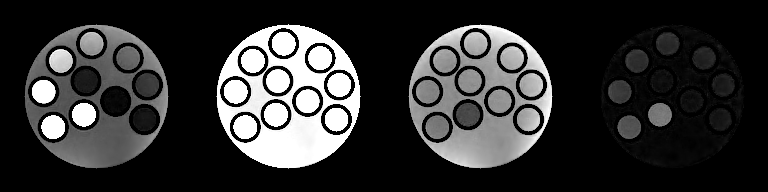

In [123]:
imshow subspace_maps

### 1.3.4 Project the reconstructed coefficient maps to images and perform pixel-wise fitting to obtain T1 map

In [124]:
bart fmac -s $(bart bitmask 6) basis_${nCoe} tmp_masked imgs
python3 mapping_piecewise.py imgs T1 TI maps

bart extract 2 0 3 maps tmp1
bart transpose 2 6 tmp1 tmp2

bart looklocker -t0.0 -D0.0 tmp2 tmp3
bart scale 0.5 tmp3 T1map
bart fmac mask T1map subspace_T1map 

Pixel: (0, 0)
Pixel: (0, 1)
Pixel: (0, 2)
Pixel: (0, 3)
Pixel: (0, 4)
Pixel: (0, 5)
Pixel: (0, 6)
Pixel: (0, 7)
Pixel: (0, 8)
Pixel: (0, 9)
Pixel: (0, 10)
Pixel: (0, 11)
Pixel: (0, 12)
Pixel: (0, 13)
Pixel: (0, 14)
Pixel: (0, 15)
Pixel: (0, 16)
Pixel: (0, 17)
Pixel: (0, 18)
Pixel: (0, 19)
Pixel: (0, 20)
Pixel: (0, 21)
Pixel: (0, 22)
Pixel: (0, 23)
Pixel: (0, 24)
Pixel: (0, 25)
Pixel: (0, 26)
Pixel: (0, 27)
Pixel: (0, 28)
Pixel: (0, 29)
Pixel: (0, 30)
Pixel: (0, 31)
Pixel: (0, 32)
Pixel: (0, 33)
Pixel: (0, 34)
Pixel: (0, 35)
Pixel: (0, 36)
Pixel: (0, 37)
Pixel: (0, 38)
Pixel: (0, 39)
Pixel: (0, 40)
Pixel: (0, 41)
Pixel: (0, 42)
Pixel: (0, 43)
Pixel: (0, 44)
Pixel: (0, 45)
Pixel: (0, 46)
Pixel: (0, 47)
Pixel: (0, 48)
Pixel: (0, 49)
Pixel: (0, 50)
Pixel: (0, 51)
Pixel: (0, 52)
Pixel: (0, 53)
Pixel: (0, 54)
Pixel: (0, 55)
Pixel: (0, 56)
Pixel: (0, 57)
Pixel: (0, 58)
Pixel: (0, 59)
Pixel: (0, 60)
Pixel: (0, 61)
Pixel: (0, 62)
Pixel: (0, 63)
Pixel: (0, 64)
Pixel: (0, 65)
Pixel: (0, 66)
Pixel

Pixel: (2, 149)
Pixel: (2, 150)
Pixel: (2, 151)
Pixel: (2, 152)
Pixel: (2, 153)
Pixel: (2, 154)
Pixel: (2, 155)
Pixel: (2, 156)
Pixel: (2, 157)
Pixel: (2, 158)
Pixel: (2, 159)
Pixel: (2, 160)
Pixel: (2, 161)
Pixel: (2, 162)
Pixel: (2, 163)
Pixel: (2, 164)
Pixel: (2, 165)
Pixel: (2, 166)
Pixel: (2, 167)
Pixel: (2, 168)
Pixel: (2, 169)
Pixel: (2, 170)
Pixel: (2, 171)
Pixel: (2, 172)
Pixel: (2, 173)
Pixel: (2, 174)
Pixel: (2, 175)
Pixel: (2, 176)
Pixel: (2, 177)
Pixel: (2, 178)
Pixel: (2, 179)
Pixel: (2, 180)
Pixel: (2, 181)
Pixel: (2, 182)
Pixel: (2, 183)
Pixel: (2, 184)
Pixel: (2, 185)
Pixel: (2, 186)
Pixel: (2, 187)
Pixel: (2, 188)
Pixel: (2, 189)
Pixel: (2, 190)
Pixel: (2, 191)
Pixel: (3, 0)
Pixel: (3, 1)
Pixel: (3, 2)
Pixel: (3, 3)
Pixel: (3, 4)
Pixel: (3, 5)
Pixel: (3, 6)
Pixel: (3, 7)
Pixel: (3, 8)
Pixel: (3, 9)
Pixel: (3, 10)
Pixel: (3, 11)
Pixel: (3, 12)
Pixel: (3, 13)
Pixel: (3, 14)
Pixel: (3, 15)
Pixel: (3, 16)
Pixel: (3, 17)
Pixel: (3, 18)
Pixel: (3, 19)
Pixel: (3, 20)
Pixel: 

Pixel: (5, 106)
Pixel: (5, 107)
Pixel: (5, 108)
Pixel: (5, 109)
Pixel: (5, 110)
Pixel: (5, 111)
Pixel: (5, 112)
Pixel: (5, 113)
Pixel: (5, 114)
Pixel: (5, 115)
Pixel: (5, 116)
Pixel: (5, 117)
Pixel: (5, 118)
Pixel: (5, 119)
Pixel: (5, 120)
Pixel: (5, 121)
Pixel: (5, 122)
Pixel: (5, 123)
Pixel: (5, 124)
Pixel: (5, 125)
Pixel: (5, 126)
Pixel: (5, 127)
Pixel: (5, 128)
Pixel: (5, 129)
Pixel: (5, 130)
Pixel: (5, 131)
Pixel: (5, 132)
Pixel: (5, 133)
Pixel: (5, 134)
Pixel: (5, 135)
Pixel: (5, 136)
Pixel: (5, 137)
Pixel: (5, 138)
Pixel: (5, 139)
Pixel: (5, 140)
Pixel: (5, 141)
Pixel: (5, 142)
Pixel: (5, 143)
Pixel: (5, 144)
Pixel: (5, 145)
Pixel: (5, 146)
Pixel: (5, 147)
Pixel: (5, 148)
Pixel: (5, 149)
Pixel: (5, 150)
Pixel: (5, 151)
Pixel: (5, 152)
Pixel: (5, 153)
Pixel: (5, 154)
Pixel: (5, 155)
Pixel: (5, 156)
Pixel: (5, 157)
Pixel: (5, 158)
Pixel: (5, 159)
Pixel: (5, 160)
Pixel: (5, 161)
Pixel: (5, 162)
Pixel: (5, 163)
Pixel: (5, 164)
Pixel: (5, 165)
Pixel: (5, 166)
Pixel: (5, 167)
Pixel: (

Pixel: (8, 61)
Pixel: (8, 62)
Pixel: (8, 63)
Pixel: (8, 64)
Pixel: (8, 65)
Pixel: (8, 66)
Pixel: (8, 67)
Pixel: (8, 68)
Pixel: (8, 69)
Pixel: (8, 70)
Pixel: (8, 71)
Pixel: (8, 72)
Pixel: (8, 73)
Pixel: (8, 74)
Pixel: (8, 75)
Pixel: (8, 76)
Pixel: (8, 77)
Pixel: (8, 78)
Pixel: (8, 79)
Pixel: (8, 80)
Pixel: (8, 81)
Pixel: (8, 82)
Pixel: (8, 83)
Pixel: (8, 84)
Pixel: (8, 85)
Pixel: (8, 86)
Pixel: (8, 87)
Pixel: (8, 88)
Pixel: (8, 89)
Pixel: (8, 90)
Pixel: (8, 91)
Pixel: (8, 92)
Pixel: (8, 93)
Pixel: (8, 94)
Pixel: (8, 95)
Pixel: (8, 96)
Pixel: (8, 97)
Pixel: (8, 98)
Pixel: (8, 99)
Pixel: (8, 100)
Pixel: (8, 101)
Pixel: (8, 102)
Pixel: (8, 103)
Pixel: (8, 104)
Pixel: (8, 105)
Pixel: (8, 106)
Pixel: (8, 107)
Pixel: (8, 108)
Pixel: (8, 109)
Pixel: (8, 110)
Pixel: (8, 111)
Pixel: (8, 112)
Pixel: (8, 113)
Pixel: (8, 114)
Pixel: (8, 115)
Pixel: (8, 116)
Pixel: (8, 117)
Pixel: (8, 118)
Pixel: (8, 119)
Pixel: (8, 120)
Pixel: (8, 121)
Pixel: (8, 122)
Pixel: (8, 123)
Pixel: (8, 124)
Pixel: (8, 125)

Pixel: (11, 2)
Pixel: (11, 3)
Pixel: (11, 4)
Pixel: (11, 5)
Pixel: (11, 6)
Pixel: (11, 7)
Pixel: (11, 8)
Pixel: (11, 9)
Pixel: (11, 10)
Pixel: (11, 11)
Pixel: (11, 12)
Pixel: (11, 13)
Pixel: (11, 14)
Pixel: (11, 15)
Pixel: (11, 16)
Pixel: (11, 17)
Pixel: (11, 18)
Pixel: (11, 19)
Pixel: (11, 20)
Pixel: (11, 21)
Pixel: (11, 22)
Pixel: (11, 23)
Pixel: (11, 24)
Pixel: (11, 25)
Pixel: (11, 26)
Pixel: (11, 27)
Pixel: (11, 28)
Pixel: (11, 29)
Pixel: (11, 30)
Pixel: (11, 31)
Pixel: (11, 32)
Pixel: (11, 33)
Pixel: (11, 34)
Pixel: (11, 35)
Pixel: (11, 36)
Pixel: (11, 37)
Pixel: (11, 38)
Pixel: (11, 39)
Pixel: (11, 40)
Pixel: (11, 41)
Pixel: (11, 42)
Pixel: (11, 43)
Pixel: (11, 44)
Pixel: (11, 45)
Pixel: (11, 46)
Pixel: (11, 47)
Pixel: (11, 48)
Pixel: (11, 49)
Pixel: (11, 50)
Pixel: (11, 51)
Pixel: (11, 52)
Pixel: (11, 53)
Pixel: (11, 54)
Pixel: (11, 55)
Pixel: (11, 56)
Pixel: (11, 57)
Pixel: (11, 58)
Pixel: (11, 59)
Pixel: (11, 60)
Pixel: (11, 61)
Pixel: (11, 62)
Pixel: (11, 63)
Pixel: (11, 64)


Pixel: (13, 120)
Pixel: (13, 121)
Pixel: (13, 122)
Pixel: (13, 123)
Pixel: (13, 124)
Pixel: (13, 125)
Pixel: (13, 126)
Pixel: (13, 127)
Pixel: (13, 128)
Pixel: (13, 129)
Pixel: (13, 130)
Pixel: (13, 131)
Pixel: (13, 132)
Pixel: (13, 133)
Pixel: (13, 134)
Pixel: (13, 135)
Pixel: (13, 136)
Pixel: (13, 137)
Pixel: (13, 138)
Pixel: (13, 139)
Pixel: (13, 140)
Pixel: (13, 141)
Pixel: (13, 142)
Pixel: (13, 143)
Pixel: (13, 144)
Pixel: (13, 145)
Pixel: (13, 146)
Pixel: (13, 147)
Pixel: (13, 148)
Pixel: (13, 149)
Pixel: (13, 150)
Pixel: (13, 151)
Pixel: (13, 152)
Pixel: (13, 153)
Pixel: (13, 154)
Pixel: (13, 155)
Pixel: (13, 156)
Pixel: (13, 157)
Pixel: (13, 158)
Pixel: (13, 159)
Pixel: (13, 160)
Pixel: (13, 161)
Pixel: (13, 162)
Pixel: (13, 163)
Pixel: (13, 164)
Pixel: (13, 165)
Pixel: (13, 166)
Pixel: (13, 167)
Pixel: (13, 168)
Pixel: (13, 169)
Pixel: (13, 170)
Pixel: (13, 171)
Pixel: (13, 172)
Pixel: (13, 173)
Pixel: (13, 174)
Pixel: (13, 175)
Pixel: (13, 176)
Pixel: (13, 177)
Pixel: (13, 17

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Pixel: (28, 55)
Pixel: (28, 56)
Pixel: (28, 57)
Pixel: (28, 58)
Pixel: (28, 59)
Pixel: (28, 60)
Pixel: (28, 61)
Pixel: (28, 62)
Pixel: (28, 63)
Pixel: (28, 64)
Pixel: (28, 65)
Pixel: (28, 66)
Pixel: (28, 67)
Pixel: (28, 68)
Pixel: (28, 69)
Pixel: (28, 70)
Pixel: (28, 71)
Pixel: (28, 72)
Pixel: (28, 73)
Pixel: (28, 74)
Pixel: (28, 75)
Pixel: (28, 76)
Pixel: (28, 77)
Pixel: (28, 78)
Pixel: (28, 79)
Pixel: (28, 80)
Pixel: (28, 81)
Pixel: (28, 82)
Pixel: (28, 83)
Pixel: (28, 84)
Pixel: (28, 85)
Pixel: (28, 86)
Pixel: (28, 87)
Pixel: (28, 88)
Pixel: (28, 89)
Pixel: (28, 90)
Pixel: (28, 91)
Pixel: (28, 92)
Pixel: (28, 93)
Pixel: (28, 94)
Pixel: (28, 95)
Pixel: (28, 96)
Pixel: (28, 97)
Pixel: (28, 98)
Pixel: (28, 99)
Pixel: (28, 100)
Pixel: (28, 101)
Pixel: (28, 102)
Pixel: (28, 103)
Pixel: (28, 104)
Pixel: (28, 105)
Pixel: (28, 106)
Pixel: (28, 107)
Pixel: (28, 108)
Pixel: (28, 109)
Pixel: (28, 110)
Pixel: (28, 111)
Pixel: (28, 112)
Pixel: (28, 113)
Pixel: (28, 114)
Pixel: (28, 115)
Pixel: (

Pixel: (30, 169)
Pixel: (30, 170)
Pixel: (30, 171)
Pixel: (30, 172)
Pixel: (30, 173)
Pixel: (30, 174)
Pixel: (30, 175)
Pixel: (30, 176)
Pixel: (30, 177)
Pixel: (30, 178)
Pixel: (30, 179)
Pixel: (30, 180)
Pixel: (30, 181)
Pixel: (30, 182)
Pixel: (30, 183)
Pixel: (30, 184)
Pixel: (30, 185)
Pixel: (30, 186)
Pixel: (30, 187)
Pixel: (30, 188)
Pixel: (30, 189)
Pixel: (30, 190)
Pixel: (30, 191)
Pixel: (31, 0)
Pixel: (31, 1)
Pixel: (31, 2)
Pixel: (31, 3)
Pixel: (31, 4)
Pixel: (31, 5)
Pixel: (31, 6)
Pixel: (31, 7)
Pixel: (31, 8)
Pixel: (31, 9)
Pixel: (31, 10)
Pixel: (31, 11)
Pixel: (31, 12)
Pixel: (31, 13)
Pixel: (31, 14)
Pixel: (31, 15)
Pixel: (31, 16)
Pixel: (31, 17)
Pixel: (31, 18)
Pixel: (31, 19)
Pixel: (31, 20)
Pixel: (31, 21)
Pixel: (31, 22)
Pixel: (31, 23)
Pixel: (31, 24)
Pixel: (31, 25)
Pixel: (31, 26)
Pixel: (31, 27)
Pixel: (31, 28)
Pixel: (31, 29)
Pixel: (31, 30)
Pixel: (31, 31)
Pixel: (31, 32)
Pixel: (31, 33)
Pixel: (31, 34)
Pixel: (31, 35)
Pixel: (31, 36)
Pixel: (31, 37)
Pixel: (31,

Pixel: (33, 94)
Pixel: (33, 95)
Pixel: (33, 96)
Pixel: (33, 97)
Pixel: (33, 98)
Pixel: (33, 99)
Pixel: (33, 100)
Pixel: (33, 101)
Pixel: (33, 102)
Pixel: (33, 103)
Pixel: (33, 104)
Pixel: (33, 105)
Pixel: (33, 106)
Pixel: (33, 107)
Pixel: (33, 108)
Pixel: (33, 109)
Pixel: (33, 110)
Pixel: (33, 111)
Pixel: (33, 112)
Pixel: (33, 113)
Pixel: (33, 114)
Pixel: (33, 115)
Pixel: (33, 116)
Pixel: (33, 117)
Pixel: (33, 118)
Pixel: (33, 119)
Pixel: (33, 120)
Pixel: (33, 121)
Pixel: (33, 122)
Pixel: (33, 123)
Pixel: (33, 124)
Pixel: (33, 125)
Pixel: (33, 126)
Pixel: (33, 127)
Pixel: (33, 128)
Pixel: (33, 129)
Pixel: (33, 130)
Pixel: (33, 131)
Pixel: (33, 132)
Pixel: (33, 133)
Pixel: (33, 134)
Pixel: (33, 135)
Pixel: (33, 136)
Pixel: (33, 137)
Pixel: (33, 138)
Pixel: (33, 139)
Pixel: (33, 140)
Pixel: (33, 141)
Pixel: (33, 142)
Pixel: (33, 143)
Pixel: (33, 144)
Pixel: (33, 145)
Pixel: (33, 146)
Pixel: (33, 147)
Pixel: (33, 148)
Pixel: (33, 149)
Pixel: (33, 150)
Pixel: (33, 151)
Pixel: (33, 152)
Pix

Pixel: (36, 15)
Pixel: (36, 16)
Pixel: (36, 17)
Pixel: (36, 18)
Pixel: (36, 19)
Pixel: (36, 20)
Pixel: (36, 21)
Pixel: (36, 22)
Pixel: (36, 23)
Pixel: (36, 24)
Pixel: (36, 25)
Pixel: (36, 26)
Pixel: (36, 27)
Pixel: (36, 28)
Pixel: (36, 29)
Pixel: (36, 30)
Pixel: (36, 31)
Pixel: (36, 32)
Pixel: (36, 33)
Pixel: (36, 34)
Pixel: (36, 35)
Pixel: (36, 36)
Pixel: (36, 37)
Pixel: (36, 38)
Pixel: (36, 39)
Pixel: (36, 40)
Pixel: (36, 41)
Pixel: (36, 42)
Pixel: (36, 43)
Pixel: (36, 44)
Pixel: (36, 45)
Pixel: (36, 46)
Pixel: (36, 47)
Pixel: (36, 48)
Pixel: (36, 49)
Pixel: (36, 50)
Pixel: (36, 51)
Pixel: (36, 52)
Pixel: (36, 53)
Pixel: (36, 54)
Pixel: (36, 55)
Pixel: (36, 56)
Pixel: (36, 57)
Pixel: (36, 58)
Pixel: (36, 59)
Pixel: (36, 60)
Pixel: (36, 61)
Pixel: (36, 62)
Pixel: (36, 63)
Pixel: (36, 64)
Pixel: (36, 65)
Pixel: (36, 66)
Pixel: (36, 67)
Pixel: (36, 68)
Pixel: (36, 69)
Pixel: (36, 70)
Pixel: (36, 71)
Pixel: (36, 72)
Pixel: (36, 73)
Pixel: (36, 74)
Pixel: (36, 75)
Pixel: (36, 76)
Pixel: (

Pixel: (38, 131)
Pixel: (38, 132)
Pixel: (38, 133)
Pixel: (38, 134)
Pixel: (38, 135)
Pixel: (38, 136)
Pixel: (38, 137)
Pixel: (38, 138)
Pixel: (38, 139)
Pixel: (38, 140)
Pixel: (38, 141)
Pixel: (38, 142)
Pixel: (38, 143)
Pixel: (38, 144)
Pixel: (38, 145)
Pixel: (38, 146)
Pixel: (38, 147)
Pixel: (38, 148)
Pixel: (38, 149)
Pixel: (38, 150)
Pixel: (38, 151)
Pixel: (38, 152)
Pixel: (38, 153)
Pixel: (38, 154)
Pixel: (38, 155)
Pixel: (38, 156)
Pixel: (38, 157)
Pixel: (38, 158)
Pixel: (38, 159)
Pixel: (38, 160)
Pixel: (38, 161)
Pixel: (38, 162)
Pixel: (38, 163)
Pixel: (38, 164)
Pixel: (38, 165)
Pixel: (38, 166)
Pixel: (38, 167)
Pixel: (38, 168)
Pixel: (38, 169)
Pixel: (38, 170)
Pixel: (38, 171)
Pixel: (38, 172)
Pixel: (38, 173)
Pixel: (38, 174)
Pixel: (38, 175)
Pixel: (38, 176)
Pixel: (38, 177)
Pixel: (38, 178)
Pixel: (38, 179)
Pixel: (38, 180)
Pixel: (38, 181)
Pixel: (38, 182)
Pixel: (38, 183)
Pixel: (38, 184)
Pixel: (38, 185)
Pixel: (38, 186)
Pixel: (38, 187)
Pixel: (38, 188)
Pixel: (38, 18

Pixel: (41, 54)
Pixel: (41, 55)
Pixel: (41, 56)
Pixel: (41, 57)
Pixel: (41, 58)
Pixel: (41, 59)
Pixel: (41, 60)
Pixel: (41, 61)
Pixel: (41, 62)
Pixel: (41, 63)
Pixel: (41, 64)
Pixel: (41, 65)
Pixel: (41, 66)
Pixel: (41, 67)
Pixel: (41, 68)
Pixel: (41, 69)
Pixel: (41, 70)
Pixel: (41, 71)
Pixel: (41, 72)
Pixel: (41, 73)
Pixel: (41, 74)
Pixel: (41, 75)
Pixel: (41, 76)
Pixel: (41, 77)
Pixel: (41, 78)
Pixel: (41, 79)
Pixel: (41, 80)
Pixel: (41, 81)
Pixel: (41, 82)
Pixel: (41, 83)
Pixel: (41, 84)
Pixel: (41, 85)
Pixel: (41, 86)
Pixel: (41, 87)
Pixel: (41, 88)
Pixel: (41, 89)
Pixel: (41, 90)
Pixel: (41, 91)
Pixel: (41, 92)
Pixel: (41, 93)
Pixel: (41, 94)
Pixel: (41, 95)
Pixel: (41, 96)
Pixel: (41, 97)
Pixel: (41, 98)
Pixel: (41, 99)
Pixel: (41, 100)
Pixel: (41, 101)
Pixel: (41, 102)
Pixel: (41, 103)
Pixel: (41, 104)
Pixel: (41, 105)
Pixel: (41, 106)
Pixel: (41, 107)
Pixel: (41, 108)
Pixel: (41, 109)
Pixel: (41, 110)
Pixel: (41, 111)
Pixel: (41, 112)
Pixel: (41, 113)
Pixel: (41, 114)
Pixel: (4

Pixel: (43, 168)
Pixel: (43, 169)
Pixel: (43, 170)
Pixel: (43, 171)
Pixel: (43, 172)
Pixel: (43, 173)
Pixel: (43, 174)


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Pixel: (55, 164)
Pixel: (55, 165)
Pixel: (55, 166)
Pixel: (55, 167)
Pixel: (55, 168)
Pixel: (55, 169)
Pixel: (55, 170)
Pixel: (55, 171)
Pixel: (55, 172)
Pixel: (55, 173)
Pixel: (55, 174)
Pixel: (55, 175)
Pixel: (55, 176)
Pixel: (55, 177)
Pixel: (55, 178)
Pixel: (55, 179)
Pixel: (55, 180)
Pixel: (55, 181)
Pixel: (55, 182)
Pixel: (55, 183)
Pixel: (55, 184)
Pixel: (55, 185)
Pixel: (55, 186)
Pixel: (55, 187)
Pixel: (55, 188)
Pixel: (55, 189)
Pixel: (55, 190)
Pixel: (55, 191)
Pixel: (56, 0)
Pixel: (56, 1)
Pixel: (56, 2)
Pixel: (56, 3)
Pixel: (56, 4)
Pixel: (56, 5)
Pixel: (56, 6)
Pixel: (56, 7)
Pixel: (56, 8)
Pixel: (56, 9)
Pixel: (56, 10)
Pixel: (56, 11)
Pixel: (56, 12)
Pixel: (56, 13)
Pixel: (56, 14)
Pixel: (56, 15)
Pixel: (56, 16)
Pixel: (56, 17)
Pixel: (56, 18)
Pixel: (56, 19)
Pixel: (56, 20)
Pixel: (56, 21)
Pixel: (56, 22)
Pixel: (56, 23)
Pixel: (56, 24)
Pixel: (56, 25)
Pixel: (56, 26)
Pixel: (56, 27)
Pixel: (56, 28)
Pixel: (56, 29)
Pixel: (56, 30)
Pixel: (56, 31)
Pixel: (56, 32)
Pixel:

Pixel: (58, 89)
Pixel: (58, 90)
Pixel: (58, 91)
Pixel: (58, 92)
Pixel: (58, 93)
Pixel: (58, 94)
Pixel: (58, 95)
Pixel: (58, 96)
Pixel: (58, 97)
Pixel: (58, 98)
Pixel: (58, 99)
Pixel: (58, 100)
Pixel: (58, 101)
Pixel: (58, 102)
Pixel: (58, 103)
Pixel: (58, 104)
Pixel: (58, 105)
Pixel: (58, 106)
Pixel: (58, 107)
Pixel: (58, 108)
Pixel: (58, 109)
Pixel: (58, 110)
Pixel: (58, 111)
Pixel: (58, 112)
Pixel: (58, 113)
Pixel: (58, 114)
Pixel: (58, 115)
Pixel: (58, 116)
Pixel: (58, 117)
Pixel: (58, 118)
Pixel: (58, 119)
Pixel: (58, 120)
Pixel: (58, 121)
Pixel: (58, 122)
Pixel: (58, 123)
Pixel: (58, 124)
Pixel: (58, 125)
Pixel: (58, 126)
Pixel: (58, 127)
Pixel: (58, 128)
Pixel: (58, 129)
Pixel: (58, 130)
Pixel: (58, 131)
Pixel: (58, 132)
Pixel: (58, 133)
Pixel: (58, 134)
Pixel: (58, 135)
Pixel: (58, 136)
Pixel: (58, 137)
Pixel: (58, 138)
Pixel: (58, 139)
Pixel: (58, 140)
Pixel: (58, 141)
Pixel: (58, 142)
Pixel: (58, 143)
Pixel: (58, 144)
Pixel: (58, 145)
Pixel: (58, 146)
Pixel: (58, 147)
Pixel: (

Pixel: (61, 10)
Pixel: (61, 11)
Pixel: (61, 12)
Pixel: (61, 13)
Pixel: (61, 14)
Pixel: (61, 15)
Pixel: (61, 16)
Pixel: (61, 17)
Pixel: (61, 18)
Pixel: (61, 19)
Pixel: (61, 20)
Pixel: (61, 21)
Pixel: (61, 22)
Pixel: (61, 23)
Pixel: (61, 24)
Pixel: (61, 25)
Pixel: (61, 26)
Pixel: (61, 27)
Pixel: (61, 28)
Pixel: (61, 29)
Pixel: (61, 30)
Pixel: (61, 31)
Pixel: (61, 32)
Pixel: (61, 33)
Pixel: (61, 34)
Pixel: (61, 35)
Pixel: (61, 36)
Pixel: (61, 37)
Pixel: (61, 38)
Pixel: (61, 39)
Pixel: (61, 40)
Pixel: (61, 41)
Pixel: (61, 42)
Pixel: (61, 43)
Pixel: (61, 44)
Pixel: (61, 45)
Pixel: (61, 46)
Pixel: (61, 47)
Pixel: (61, 48)
Pixel: (61, 49)
Pixel: (61, 50)
Pixel: (61, 51)
Pixel: (61, 52)
Pixel: (61, 53)
Pixel: (61, 54)
Pixel: (61, 55)
Pixel: (61, 56)
Pixel: (61, 57)
Pixel: (61, 58)
Pixel: (61, 59)
Pixel: (61, 60)
Pixel: (61, 61)
Pixel: (61, 62)
Pixel: (61, 63)
Pixel: (61, 64)
Pixel: (61, 65)
Pixel: (61, 66)
Pixel: (61, 67)
Pixel: (61, 68)
Pixel: (61, 69)
Pixel: (61, 70)
Pixel: (61, 71)
Pixel: (

Pixel: (63, 127)
Pixel: (63, 128)
Pixel: (63, 129)
Pixel: (63, 130)
Pixel: (63, 131)
Pixel: (63, 132)
Pixel: (63, 133)
Pixel: (63, 134)
Pixel: (63, 135)
Pixel: (63, 136)
Pixel: (63, 137)
Pixel: (63, 138)
Pixel: (63, 139)
Pixel: (63, 140)
Pixel: (63, 141)
Pixel: (63, 142)
Pixel: (63, 143)
Pixel: (63, 144)
Pixel: (63, 145)
Pixel: (63, 146)
Pixel: (63, 147)
Pixel: (63, 148)
Pixel: (63, 149)
Pixel: (63, 150)
Pixel: (63, 151)
Pixel: (63, 152)
Pixel: (63, 153)
Pixel: (63, 154)
Pixel: (63, 155)
Pixel: (63, 156)
Pixel: (63, 157)
Pixel: (63, 158)
Pixel: (63, 159)
Pixel: (63, 160)
Pixel: (63, 161)
Pixel: (63, 162)
Pixel: (63, 163)
Pixel: (63, 164)
Pixel: (63, 165)
Pixel: (63, 166)
Pixel: (63, 167)
Pixel: (63, 168)
Pixel: (63, 169)
Pixel: (63, 170)
Pixel: (63, 171)
Pixel: (63, 172)
Pixel: (63, 173)
Pixel: (63, 174)
Pixel: (63, 175)
Pixel: (63, 176)
Pixel: (63, 177)
Pixel: (63, 178)
Pixel: (63, 179)
Pixel: (63, 180)
Pixel: (63, 181)
Pixel: (63, 182)
Pixel: (63, 183)
Pixel: (63, 184)
Pixel: (63, 18

Pixel: (66, 50)
Pixel: (66, 51)
Pixel: (66, 52)
Pixel: (66, 53)
Pixel: (66, 54)
Pixel: (66, 55)
Pixel: (66, 56)
Pixel: (66, 57)
Pixel: (66, 58)
Pixel: (66, 59)
Pixel: (66, 60)
Pixel: (66, 61)
Pixel: (66, 62)
Pixel: (66, 63)
Pixel: (66, 64)
Pixel: (66, 65)
Pixel: (66, 66)
Pixel: (66, 67)
Pixel: (66, 68)
Pixel: (66, 69)
Pixel: (66, 70)
Pixel: (66, 71)
Pixel: (66, 72)
Pixel: (66, 73)
Pixel: (66, 74)
Pixel: (66, 75)
Pixel: (66, 76)
Pixel: (66, 77)
Pixel: (66, 78)
Pixel: (66, 79)
Pixel: (66, 80)
Pixel: (66, 81)
Pixel: (66, 82)
Pixel: (66, 83)
Pixel: (66, 84)
Pixel: (66, 85)
Pixel: (66, 86)
Pixel: (66, 87)
Pixel: (66, 88)
Pixel: (66, 89)
Pixel: (66, 90)
Pixel: (66, 91)
Pixel: (66, 92)
Pixel: (66, 93)
Pixel: (66, 94)
Pixel: (66, 95)
Pixel: (66, 96)
Pixel: (66, 97)
Pixel: (66, 98)
Pixel: (66, 99)
Pixel: (66, 100)
Pixel: (66, 101)
Pixel: (66, 102)
Pixel: (66, 103)
Pixel: (66, 104)
Pixel: (66, 105)
Pixel: (66, 106)
Pixel: (66, 107)
Pixel: (66, 108)
Pixel: (66, 109)
Pixel: (66, 110)
Pixel: (66, 1

Pixel: (68, 164)
Pixel: (68, 165)
Pixel: (68, 166)
Pixel: (68, 167)
Pixel: (68, 168)
Pixel: (68, 169)
Pixel: (68, 170)
Pixel: (68, 171)
Pixel: (68, 172)
Pixel: (68, 173)
Pixel: (68, 174)
Pixel: (68, 175)
Pixel: (68, 176)
Pixel: (68, 177)
Pixel: (68, 178)
Pixel: (68, 179)
Pixel: (68, 180)
Pixel: (68, 181)
Pixel: (68, 182)
Pixel: (68, 183)
Pixel: (68, 184)
Pixel: (68, 185)
Pixel: (68, 186)
Pixel: (68, 187)
Pixel: (68, 188)
Pixel: (68, 189)
Pixel: (68, 190)
Pixel: (68, 191)
Pixel: (69, 0)
Pixel: (69, 1)
Pixel: (69, 2)
Pixel: (69, 3)
Pixel: (69, 4)
Pixel: (69, 5)
Pixel: (69, 6)
Pixel: (69, 7)
Pixel: (69, 8)
Pixel: (69, 9)
Pixel: (69, 10)
Pixel: (69, 11)
Pixel: (69, 12)
Pixel: (69, 13)
Pixel: (69, 14)
Pixel: (69, 15)
Pixel: (69, 16)
Pixel: (69, 17)
Pixel: (69, 18)
Pixel: (69, 19)
Pixel: (69, 20)
Pixel: (69, 21)
Pixel: (69, 22)
Pixel: (69, 23)
Pixel: (69, 24)
Pixel: (69, 25)
Pixel: (69, 26)
Pixel: (69, 27)
Pixel: (69, 28)
Pixel: (69, 29)
Pixel: (69, 30)
Pixel: (69, 31)
Pixel: (69, 32)
Pixel:

Pixel: (71, 89)
Pixel: (71, 90)
Pixel: (71, 91)


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Pixel: (83, 26)
Pixel: (83, 27)
Pixel: (83, 28)
Pixel: (83, 29)
Pixel: (83, 30)
Pixel: (83, 31)
Pixel: (83, 32)
Pixel: (83, 33)
Pixel: (83, 34)
Pixel: (83, 35)
Pixel: (83, 36)
Pixel: (83, 37)
Pixel: (83, 38)
Pixel: (83, 39)
Pixel: (83, 40)
Pixel: (83, 41)
Pixel: (83, 42)
Pixel: (83, 43)
Pixel: (83, 44)
Pixel: (83, 45)
Pixel: (83, 46)
Pixel: (83, 47)
Pixel: (83, 48)
Pixel: (83, 49)
Pixel: (83, 50)
Pixel: (83, 51)
Pixel: (83, 52)
Pixel: (83, 53)
Pixel: (83, 54)
Pixel: (83, 55)
Pixel: (83, 56)
Pixel: (83, 57)
Pixel: (83, 58)
Pixel: (83, 59)
Pixel: (83, 60)
Pixel: (83, 61)
Pixel: (83, 62)
Pixel: (83, 63)
Pixel: (83, 64)
Pixel: (83, 65)
Pixel: (83, 66)
Pixel: (83, 67)
Pixel: (83, 68)
Pixel: (83, 69)
Pixel: (83, 70)
Pixel: (83, 71)
Pixel: (83, 72)
Pixel: (83, 73)
Pixel: (83, 74)
Pixel: (83, 75)
Pixel: (83, 76)
Pixel: (83, 77)
Pixel: (83, 78)
Pixel: (83, 79)
Pixel: (83, 80)
Pixel: (83, 81)
Pixel: (83, 82)
Pixel: (83, 83)
Pixel: (83, 84)
Pixel: (83, 85)
Pixel: (83, 86)
Pixel: (83, 87)
Pixel: (

Pixel: (85, 142)
Pixel: (85, 143)
Pixel: (85, 144)
Pixel: (85, 145)
Pixel: (85, 146)
Pixel: (85, 147)
Pixel: (85, 148)
Pixel: (85, 149)
Pixel: (85, 150)
Pixel: (85, 151)
Pixel: (85, 152)
Pixel: (85, 153)
Pixel: (85, 154)
Pixel: (85, 155)
Pixel: (85, 156)
Pixel: (85, 157)
Pixel: (85, 158)
Pixel: (85, 159)
Pixel: (85, 160)
Pixel: (85, 161)
Pixel: (85, 162)
Pixel: (85, 163)
Pixel: (85, 164)
Pixel: (85, 165)
Pixel: (85, 166)
Pixel: (85, 167)
Pixel: (85, 168)
Pixel: (85, 169)
Pixel: (85, 170)
Pixel: (85, 171)
Pixel: (85, 172)
Pixel: (85, 173)
Pixel: (85, 174)
Pixel: (85, 175)
Pixel: (85, 176)
Pixel: (85, 177)
Pixel: (85, 178)
Pixel: (85, 179)
Pixel: (85, 180)
Pixel: (85, 181)
Pixel: (85, 182)
Pixel: (85, 183)
Pixel: (85, 184)
Pixel: (85, 185)
Pixel: (85, 186)
Pixel: (85, 187)
Pixel: (85, 188)
Pixel: (85, 189)
Pixel: (85, 190)
Pixel: (85, 191)
Pixel: (86, 0)
Pixel: (86, 1)
Pixel: (86, 2)
Pixel: (86, 3)
Pixel: (86, 4)
Pixel: (86, 5)
Pixel: (86, 6)
Pixel: (86, 7)
Pixel: (86, 8)
Pixel: (86, 9)


Pixel: (88, 66)
Pixel: (88, 67)
Pixel: (88, 68)
Pixel: (88, 69)
Pixel: (88, 70)
Pixel: (88, 71)
Pixel: (88, 72)
Pixel: (88, 73)
Pixel: (88, 74)
Pixel: (88, 75)
Pixel: (88, 76)
Pixel: (88, 77)
Pixel: (88, 78)
Pixel: (88, 79)
Pixel: (88, 80)
Pixel: (88, 81)
Pixel: (88, 82)
Pixel: (88, 83)
Pixel: (88, 84)
Pixel: (88, 85)
Pixel: (88, 86)
Pixel: (88, 87)
Pixel: (88, 88)
Pixel: (88, 89)
Pixel: (88, 90)
Pixel: (88, 91)
Pixel: (88, 92)
Pixel: (88, 93)
Pixel: (88, 94)
Pixel: (88, 95)
Pixel: (88, 96)
Pixel: (88, 97)
Pixel: (88, 98)
Pixel: (88, 99)
Pixel: (88, 100)
Pixel: (88, 101)
Pixel: (88, 102)
Pixel: (88, 103)
Pixel: (88, 104)
Pixel: (88, 105)
Pixel: (88, 106)
Pixel: (88, 107)
Pixel: (88, 108)
Pixel: (88, 109)
Pixel: (88, 110)
Pixel: (88, 111)
Pixel: (88, 112)
Pixel: (88, 113)
Pixel: (88, 114)
Pixel: (88, 115)
Pixel: (88, 116)
Pixel: (88, 117)
Pixel: (88, 118)
Pixel: (88, 119)
Pixel: (88, 120)
Pixel: (88, 121)
Pixel: (88, 122)
Pixel: (88, 123)
Pixel: (88, 124)
Pixel: (88, 125)
Pixel: (88, 12

Pixel: (90, 179)
Pixel: (90, 180)
Pixel: (90, 181)
Pixel: (90, 182)
Pixel: (90, 183)
Pixel: (90, 184)
Pixel: (90, 185)
Pixel: (90, 186)
Pixel: (90, 187)
Pixel: (90, 188)
Pixel: (90, 189)
Pixel: (90, 190)
Pixel: (90, 191)
Pixel: (91, 0)
Pixel: (91, 1)
Pixel: (91, 2)
Pixel: (91, 3)
Pixel: (91, 4)
Pixel: (91, 5)
Pixel: (91, 6)
Pixel: (91, 7)
Pixel: (91, 8)
Pixel: (91, 9)
Pixel: (91, 10)
Pixel: (91, 11)
Pixel: (91, 12)
Pixel: (91, 13)
Pixel: (91, 14)
Pixel: (91, 15)
Pixel: (91, 16)
Pixel: (91, 17)
Pixel: (91, 18)
Pixel: (91, 19)
Pixel: (91, 20)
Pixel: (91, 21)
Pixel: (91, 22)
Pixel: (91, 23)
Pixel: (91, 24)
Pixel: (91, 25)
Pixel: (91, 26)
Pixel: (91, 27)
Pixel: (91, 28)
Pixel: (91, 29)
Pixel: (91, 30)
Pixel: (91, 31)
Pixel: (91, 32)
Pixel: (91, 33)
Pixel: (91, 34)
Pixel: (91, 35)
Pixel: (91, 36)
Pixel: (91, 37)
Pixel: (91, 38)
Pixel: (91, 39)
Pixel: (91, 40)
Pixel: (91, 41)
Pixel: (91, 42)
Pixel: (91, 43)
Pixel: (91, 44)
Pixel: (91, 45)
Pixel: (91, 46)
Pixel: (91, 47)
Pixel: (91, 48)
Pixel

Pixel: (93, 105)
Pixel: (93, 106)
Pixel: (93, 107)
Pixel: (93, 108)
Pixel: (93, 109)
Pixel: (93, 110)
Pixel: (93, 111)
Pixel: (93, 112)
Pixel: (93, 113)
Pixel: (93, 114)
Pixel: (93, 115)
Pixel: (93, 116)
Pixel: (93, 117)
Pixel: (93, 118)
Pixel: (93, 119)
Pixel: (93, 120)
Pixel: (93, 121)
Pixel: (93, 122)
Pixel: (93, 123)
Pixel: (93, 124)
Pixel: (93, 125)
Pixel: (93, 126)
Pixel: (93, 127)
Pixel: (93, 128)
Pixel: (93, 129)
Pixel: (93, 130)
Pixel: (93, 131)
Pixel: (93, 132)
Pixel: (93, 133)
Pixel: (93, 134)
Pixel: (93, 135)
Pixel: (93, 136)
Pixel: (93, 137)
Pixel: (93, 138)
Pixel: (93, 139)
Pixel: (93, 140)
Pixel: (93, 141)
Pixel: (93, 142)
Pixel: (93, 143)
Pixel: (93, 144)
Pixel: (93, 145)
Pixel: (93, 146)
Pixel: (93, 147)
Pixel: (93, 148)
Pixel: (93, 149)
Pixel: (93, 150)
Pixel: (93, 151)
Pixel: (93, 152)
Pixel: (93, 153)
Pixel: (93, 154)
Pixel: (93, 155)
Pixel: (93, 156)
Pixel: (93, 157)
Pixel: (93, 158)
Pixel: (93, 159)
Pixel: (93, 160)
Pixel: (93, 161)
Pixel: (93, 162)
Pixel: (93, 16

Pixel: (96, 26)
Pixel: (96, 27)
Pixel: (96, 28)
Pixel: (96, 29)
Pixel: (96, 30)
Pixel: (96, 31)
Pixel: (96, 32)
Pixel: (96, 33)
Pixel: (96, 34)
Pixel: (96, 35)
Pixel: (96, 36)
Pixel: (96, 37)
Pixel: (96, 38)
Pixel: (96, 39)
Pixel: (96, 40)
Pixel: (96, 41)
Pixel: (96, 42)
Pixel: (96, 43)
Pixel: (96, 44)
Pixel: (96, 45)
Pixel: (96, 46)
Pixel: (96, 47)
Pixel: (96, 48)
Pixel: (96, 49)
Pixel: (96, 50)
Pixel: (96, 51)
Pixel: (96, 52)
Pixel: (96, 53)
Pixel: (96, 54)
Pixel: (96, 55)
Pixel: (96, 56)
Pixel: (96, 57)
Pixel: (96, 58)
Pixel: (96, 59)
Pixel: (96, 60)
Pixel: (96, 61)
Pixel: (96, 62)
Pixel: (96, 63)
Pixel: (96, 64)
Pixel: (96, 65)
Pixel: (96, 66)
Pixel: (96, 67)
Pixel: (96, 68)
Pixel: (96, 69)
Pixel: (96, 70)
Pixel: (96, 71)
Pixel: (96, 72)
Pixel: (96, 73)
Pixel: (96, 74)
Pixel: (96, 75)
Pixel: (96, 76)
Pixel: (96, 77)
Pixel: (96, 78)
Pixel: (96, 79)
Pixel: (96, 80)
Pixel: (96, 81)
Pixel: (96, 82)
Pixel: (96, 83)
Pixel: (96, 84)
Pixel: (96, 85)
Pixel: (96, 86)
Pixel: (96, 87)
Pixel: (

Pixel: (98, 142)
Pixel: (98, 143)
Pixel: (98, 144)
Pixel: (98, 145)


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Pixel: (110, 41)
Pixel: (110, 42)
Pixel: (110, 43)
Pixel: (110, 44)
Pixel: (110, 45)
Pixel: (110, 46)
Pixel: (110, 47)
Pixel: (110, 48)
Pixel: (110, 49)
Pixel: (110, 50)
Pixel: (110, 51)
Pixel: (110, 52)
Pixel: (110, 53)
Pixel: (110, 54)
Pixel: (110, 55)
Pixel: (110, 56)
Pixel: (110, 57)
Pixel: (110, 58)
Pixel: (110, 59)
Pixel: (110, 60)
Pixel: (110, 61)
Pixel: (110, 62)
Pixel: (110, 63)
Pixel: (110, 64)
Pixel: (110, 65)
Pixel: (110, 66)
Pixel: (110, 67)
Pixel: (110, 68)
Pixel: (110, 69)
Pixel: (110, 70)
Pixel: (110, 71)
Pixel: (110, 72)
Pixel: (110, 73)
Pixel: (110, 74)
Pixel: (110, 75)
Pixel: (110, 76)
Pixel: (110, 77)
Pixel: (110, 78)
Pixel: (110, 79)
Pixel: (110, 80)
Pixel: (110, 81)
Pixel: (110, 82)
Pixel: (110, 83)
Pixel: (110, 84)
Pixel: (110, 85)
Pixel: (110, 86)
Pixel: (110, 87)
Pixel: (110, 88)
Pixel: (110, 89)
Pixel: (110, 90)
Pixel: (110, 91)
Pixel: (110, 92)
Pixel: (110, 93)
Pixel: (110, 94)
Pixel: (110, 95)
Pixel: (110, 96)
Pixel: (110, 97)
Pixel: (110, 98)
Pixel: (110, 9

Pixel: (112, 128)
Pixel: (112, 129)
Pixel: (112, 130)
Pixel: (112, 131)
Pixel: (112, 132)
Pixel: (112, 133)
Pixel: (112, 134)
Pixel: (112, 135)
Pixel: (112, 136)
Pixel: (112, 137)
Pixel: (112, 138)
Pixel: (112, 139)
Pixel: (112, 140)
Pixel: (112, 141)
Pixel: (112, 142)
Pixel: (112, 143)
Pixel: (112, 144)
Pixel: (112, 145)
Pixel: (112, 146)
Pixel: (112, 147)
Pixel: (112, 148)
Pixel: (112, 149)
Pixel: (112, 150)
Pixel: (112, 151)
Pixel: (112, 152)
Pixel: (112, 153)
Pixel: (112, 154)
Pixel: (112, 155)
Pixel: (112, 156)
Pixel: (112, 157)
Pixel: (112, 158)
Pixel: (112, 159)
Pixel: (112, 160)
Pixel: (112, 161)
Pixel: (112, 162)
Pixel: (112, 163)
Pixel: (112, 164)
Pixel: (112, 165)
Pixel: (112, 166)
Pixel: (112, 167)
Pixel: (112, 168)
Pixel: (112, 169)
Pixel: (112, 170)
Pixel: (112, 171)
Pixel: (112, 172)
Pixel: (112, 173)
Pixel: (112, 174)
Pixel: (112, 175)
Pixel: (112, 176)
Pixel: (112, 177)
Pixel: (112, 178)
Pixel: (112, 179)
Pixel: (112, 180)
Pixel: (112, 181)
Pixel: (112, 182)
Pixel: (11

Pixel: (115, 22)
Pixel: (115, 23)
Pixel: (115, 24)
Pixel: (115, 25)
Pixel: (115, 26)
Pixel: (115, 27)
Pixel: (115, 28)
Pixel: (115, 29)
Pixel: (115, 30)
Pixel: (115, 31)
Pixel: (115, 32)
Pixel: (115, 33)
Pixel: (115, 34)
Pixel: (115, 35)
Pixel: (115, 36)
Pixel: (115, 37)
Pixel: (115, 38)
Pixel: (115, 39)
Pixel: (115, 40)
Pixel: (115, 41)
Pixel: (115, 42)
Pixel: (115, 43)
Pixel: (115, 44)
Pixel: (115, 45)
Pixel: (115, 46)
Pixel: (115, 47)
Pixel: (115, 48)
Pixel: (115, 49)
Pixel: (115, 50)
Pixel: (115, 51)
Pixel: (115, 52)
Pixel: (115, 53)
Pixel: (115, 54)
Pixel: (115, 55)
Pixel: (115, 56)
Pixel: (115, 57)
Pixel: (115, 58)
Pixel: (115, 59)
Pixel: (115, 60)
Pixel: (115, 61)
Pixel: (115, 62)
Pixel: (115, 63)
Pixel: (115, 64)
Pixel: (115, 65)
Pixel: (115, 66)
Pixel: (115, 67)
Pixel: (115, 68)
Pixel: (115, 69)
Pixel: (115, 70)
Pixel: (115, 71)
Pixel: (115, 72)
Pixel: (115, 73)
Pixel: (115, 74)
Pixel: (115, 75)
Pixel: (115, 76)
Pixel: (115, 77)
Pixel: (115, 78)
Pixel: (115, 79)
Pixel: (115, 8

Pixel: (117, 110)
Pixel: (117, 111)
Pixel: (117, 112)
Pixel: (117, 113)
Pixel: (117, 114)
Pixel: (117, 115)
Pixel: (117, 116)
Pixel: (117, 117)
Pixel: (117, 118)
Pixel: (117, 119)
Pixel: (117, 120)
Pixel: (117, 121)
Pixel: (117, 122)
Pixel: (117, 123)
Pixel: (117, 124)
Pixel: (117, 125)
Pixel: (117, 126)
Pixel: (117, 127)
Pixel: (117, 128)
Pixel: (117, 129)
Pixel: (117, 130)
Pixel: (117, 131)
Pixel: (117, 132)
Pixel: (117, 133)
Pixel: (117, 134)
Pixel: (117, 135)
Pixel: (117, 136)
Pixel: (117, 137)
Pixel: (117, 138)
Pixel: (117, 139)
Pixel: (117, 140)
Pixel: (117, 141)
Pixel: (117, 142)
Pixel: (117, 143)
Pixel: (117, 144)
Pixel: (117, 145)
Pixel: (117, 146)
Pixel: (117, 147)
Pixel: (117, 148)
Pixel: (117, 149)
Pixel: (117, 150)
Pixel: (117, 151)
Pixel: (117, 152)
Pixel: (117, 153)
Pixel: (117, 154)
Pixel: (117, 155)
Pixel: (117, 156)
Pixel: (117, 157)
Pixel: (117, 158)
Pixel: (117, 159)
Pixel: (117, 160)
Pixel: (117, 161)
Pixel: (117, 162)
Pixel: (117, 163)
Pixel: (117, 164)
Pixel: (11

Pixel: (120, 2)
Pixel: (120, 3)
Pixel: (120, 4)
Pixel: (120, 5)
Pixel: (120, 6)
Pixel: (120, 7)
Pixel: (120, 8)
Pixel: (120, 9)
Pixel: (120, 10)
Pixel: (120, 11)
Pixel: (120, 12)
Pixel: (120, 13)
Pixel: (120, 14)
Pixel: (120, 15)
Pixel: (120, 16)
Pixel: (120, 17)
Pixel: (120, 18)
Pixel: (120, 19)
Pixel: (120, 20)
Pixel: (120, 21)
Pixel: (120, 22)
Pixel: (120, 23)
Pixel: (120, 24)
Pixel: (120, 25)
Pixel: (120, 26)
Pixel: (120, 27)
Pixel: (120, 28)
Pixel: (120, 29)
Pixel: (120, 30)
Pixel: (120, 31)
Pixel: (120, 32)
Pixel: (120, 33)
Pixel: (120, 34)
Pixel: (120, 35)
Pixel: (120, 36)
Pixel: (120, 37)
Pixel: (120, 38)
Pixel: (120, 39)
Pixel: (120, 40)
Pixel: (120, 41)
Pixel: (120, 42)
Pixel: (120, 43)
Pixel: (120, 44)
Pixel: (120, 45)
Pixel: (120, 46)
Pixel: (120, 47)
Pixel: (120, 48)
Pixel: (120, 49)
Pixel: (120, 50)
Pixel: (120, 51)
Pixel: (120, 52)
Pixel: (120, 53)
Pixel: (120, 54)
Pixel: (120, 55)
Pixel: (120, 56)
Pixel: (120, 57)
Pixel: (120, 58)
Pixel: (120, 59)
Pixel: (120, 60)
Pixel

Pixel: (122, 91)
Pixel: (122, 92)
Pixel: (122, 93)
Pixel: (122, 94)
Pixel: (122, 95)
Pixel: (122, 96)
Pixel: (122, 97)
Pixel: (122, 98)
Pixel: (122, 99)
Pixel: (122, 100)
Pixel: (122, 101)
Pixel: (122, 102)
Pixel: (122, 103)
Pixel: (122, 104)
Pixel: (122, 105)
Pixel: (122, 106)
Pixel: (122, 107)
Pixel: (122, 108)
Pixel: (122, 109)
Pixel: (122, 110)
Pixel: (122, 111)
Pixel: (122, 112)
Pixel: (122, 113)
Pixel: (122, 114)
Pixel: (122, 115)
Pixel: (122, 116)
Pixel: (122, 117)
Pixel: (122, 118)
Pixel: (122, 119)
Pixel: (122, 120)
Pixel: (122, 121)
Pixel: (122, 122)
Pixel: (122, 123)
Pixel: (122, 124)
Pixel: (122, 125)
Pixel: (122, 126)
Pixel: (122, 127)
Pixel: (122, 128)
Pixel: (122, 129)
Pixel: (122, 130)
Pixel: (122, 131)
Pixel: (122, 132)
Pixel: (122, 133)
Pixel: (122, 134)
Pixel: (122, 135)
Pixel: (122, 136)
Pixel: (122, 137)
Pixel: (122, 138)
Pixel: (122, 139)
Pixel: (122, 140)
Pixel: (122, 141)
Pixel: (122, 142)
Pixel: (122, 143)
Pixel: (122, 144)
Pixel: (122, 145)
Pixel: (122, 146)
P

Pixel: (124, 175)
Pixel: (124, 176)
Pixel: (124, 177)
Pixel: (124, 178)
Pixel: (124, 179)
Pixel: (124, 180)
Pixel: (124, 181)
Pixel: (124, 182)
Pixel: (124, 183)
Pixel: (124, 184)
Pixel: (124, 185)
Pixel: (124, 186)
Pixel: (124, 187)
Pixel: (124, 188)
Pixel: (124, 189)
Pixel: (124, 190)
Pixel: (124, 191)
Pixel: (125, 0)
Pixel: (125, 1)
Pixel: (125, 2)
Pixel: (125, 3)
Pixel: (125, 4)
Pixel: (125, 5)
Pixel: (125, 6)
Pixel: (125, 7)
Pixel: (125, 8)
Pixel: (125, 9)
Pixel: (125, 10)
Pixel: (125, 11)
Pixel: (125, 12)
Pixel: (125, 13)
Pixel: (125, 14)
Pixel: (125, 15)
Pixel: (125, 16)
Pixel: (125, 17)
Pixel: (125, 18)
Pixel: (125, 19)
Pixel: (125, 20)
Pixel: (125, 21)
Pixel: (125, 22)
Pixel: (125, 23)
Pixel: (125, 24)
Pixel: (125, 25)
Pixel: (125, 26)
Pixel: (125, 27)
Pixel: (125, 28)
Pixel: (125, 29)
Pixel: (125, 30)
Pixel: (125, 31)
Pixel: (125, 32)
Pixel: (125, 33)
Pixel: (125, 34)
Pixel: (125, 35)
Pixel: (125, 36)
Pixel: (125, 37)
Pixel: (125, 38)
Pixel: (125, 39)
Pixel: (125, 40)
Pixel: 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Pixel: (140, 131)
Pixel: (140, 132)
Pixel: (140, 133)
Pixel: (140, 134)
Pixel: (140, 135)
Pixel: (140, 136)
Pixel: (140, 137)
Pixel: (140, 138)
Pixel: (140, 139)
Pixel: (140, 140)
Pixel: (140, 141)
Pixel: (140, 142)
Pixel: (140, 143)
Pixel: (140, 144)
Pixel: (140, 145)
Pixel: (140, 146)
Pixel: (140, 147)
Pixel: (140, 148)
Pixel: (140, 149)
Pixel: (140, 150)
Pixel: (140, 151)
Pixel: (140, 152)
Pixel: (140, 153)
Pixel: (140, 154)
Pixel: (140, 155)
Pixel: (140, 156)
Pixel: (140, 157)
Pixel: (140, 158)
Pixel: (140, 159)
Pixel: (140, 160)
Pixel: (140, 161)
Pixel: (140, 162)
Pixel: (140, 163)
Pixel: (140, 164)
Pixel: (140, 165)
Pixel: (140, 166)
Pixel: (140, 167)
Pixel: (140, 168)
Pixel: (140, 169)
Pixel: (140, 170)
Pixel: (140, 171)
Pixel: (140, 172)
Pixel: (140, 173)
Pixel: (140, 174)
Pixel: (140, 175)
Pixel: (140, 176)
Pixel: (140, 177)
Pixel: (140, 178)
Pixel: (140, 179)
Pixel: (140, 180)
Pixel: (140, 181)
Pixel: (140, 182)
Pixel: (140, 183)
Pixel: (140, 184)
Pixel: (140, 185)
Pixel: (14

Pixel: (143, 25)
Pixel: (143, 26)
Pixel: (143, 27)
Pixel: (143, 28)
Pixel: (143, 29)
Pixel: (143, 30)
Pixel: (143, 31)
Pixel: (143, 32)
Pixel: (143, 33)
Pixel: (143, 34)
Pixel: (143, 35)
Pixel: (143, 36)
Pixel: (143, 37)
Pixel: (143, 38)
Pixel: (143, 39)
Pixel: (143, 40)
Pixel: (143, 41)
Pixel: (143, 42)
Pixel: (143, 43)
Pixel: (143, 44)
Pixel: (143, 45)
Pixel: (143, 46)
Pixel: (143, 47)
Pixel: (143, 48)
Pixel: (143, 49)
Pixel: (143, 50)
Pixel: (143, 51)
Pixel: (143, 52)
Pixel: (143, 53)
Pixel: (143, 54)
Pixel: (143, 55)
Pixel: (143, 56)
Pixel: (143, 57)
Pixel: (143, 58)
Pixel: (143, 59)
Pixel: (143, 60)
Pixel: (143, 61)
Pixel: (143, 62)
Pixel: (143, 63)
Pixel: (143, 64)
Pixel: (143, 65)
Pixel: (143, 66)
Pixel: (143, 67)
Pixel: (143, 68)
Pixel: (143, 69)
Pixel: (143, 70)
Pixel: (143, 71)
Pixel: (143, 72)
Pixel: (143, 73)
Pixel: (143, 74)
Pixel: (143, 75)
Pixel: (143, 76)
Pixel: (143, 77)
Pixel: (143, 78)
Pixel: (143, 79)
Pixel: (143, 80)
Pixel: (143, 81)
Pixel: (143, 82)
Pixel: (143, 8

Pixel: (145, 113)
Pixel: (145, 114)
Pixel: (145, 115)
Pixel: (145, 116)
Pixel: (145, 117)
Pixel: (145, 118)
Pixel: (145, 119)
Pixel: (145, 120)
Pixel: (145, 121)
Pixel: (145, 122)
Pixel: (145, 123)
Pixel: (145, 124)
Pixel: (145, 125)
Pixel: (145, 126)
Pixel: (145, 127)
Pixel: (145, 128)
Pixel: (145, 129)
Pixel: (145, 130)
Pixel: (145, 131)
Pixel: (145, 132)
Pixel: (145, 133)
Pixel: (145, 134)
Pixel: (145, 135)
Pixel: (145, 136)
Pixel: (145, 137)
Pixel: (145, 138)
Pixel: (145, 139)
Pixel: (145, 140)
Pixel: (145, 141)
Pixel: (145, 142)
Pixel: (145, 143)
Pixel: (145, 144)
Pixel: (145, 145)
Pixel: (145, 146)
Pixel: (145, 147)
Pixel: (145, 148)
Pixel: (145, 149)
Pixel: (145, 150)
Pixel: (145, 151)
Pixel: (145, 152)
Pixel: (145, 153)
Pixel: (145, 154)
Pixel: (145, 155)
Pixel: (145, 156)
Pixel: (145, 157)
Pixel: (145, 158)
Pixel: (145, 159)
Pixel: (145, 160)
Pixel: (145, 161)
Pixel: (145, 162)
Pixel: (145, 163)
Pixel: (145, 164)
Pixel: (145, 165)
Pixel: (145, 166)
Pixel: (145, 167)
Pixel: (14

Pixel: (148, 5)
Pixel: (148, 6)
Pixel: (148, 7)
Pixel: (148, 8)
Pixel: (148, 9)
Pixel: (148, 10)
Pixel: (148, 11)
Pixel: (148, 12)
Pixel: (148, 13)
Pixel: (148, 14)
Pixel: (148, 15)
Pixel: (148, 16)
Pixel: (148, 17)
Pixel: (148, 18)
Pixel: (148, 19)
Pixel: (148, 20)
Pixel: (148, 21)
Pixel: (148, 22)
Pixel: (148, 23)
Pixel: (148, 24)
Pixel: (148, 25)
Pixel: (148, 26)
Pixel: (148, 27)
Pixel: (148, 28)
Pixel: (148, 29)
Pixel: (148, 30)
Pixel: (148, 31)
Pixel: (148, 32)
Pixel: (148, 33)
Pixel: (148, 34)
Pixel: (148, 35)
Pixel: (148, 36)
Pixel: (148, 37)
Pixel: (148, 38)
Pixel: (148, 39)
Pixel: (148, 40)
Pixel: (148, 41)
Pixel: (148, 42)
Pixel: (148, 43)
Pixel: (148, 44)
Pixel: (148, 45)
Pixel: (148, 46)
Pixel: (148, 47)
Pixel: (148, 48)
Pixel: (148, 49)
Pixel: (148, 50)
Pixel: (148, 51)
Pixel: (148, 52)
Pixel: (148, 53)
Pixel: (148, 54)
Pixel: (148, 55)
Pixel: (148, 56)
Pixel: (148, 57)
Pixel: (148, 58)
Pixel: (148, 59)
Pixel: (148, 60)
Pixel: (148, 61)
Pixel: (148, 62)
Pixel: (148, 63)
Pi

Pixel: (150, 94)
Pixel: (150, 95)
Pixel: (150, 96)
Pixel: (150, 97)
Pixel: (150, 98)
Pixel: (150, 99)
Pixel: (150, 100)
Pixel: (150, 101)
Pixel: (150, 102)
Pixel: (150, 103)
Pixel: (150, 104)
Pixel: (150, 105)
Pixel: (150, 106)
Pixel: (150, 107)
Pixel: (150, 108)
Pixel: (150, 109)
Pixel: (150, 110)
Pixel: (150, 111)
Pixel: (150, 112)
Pixel: (150, 113)
Pixel: (150, 114)
Pixel: (150, 115)
Pixel: (150, 116)
Pixel: (150, 117)
Pixel: (150, 118)
Pixel: (150, 119)
Pixel: (150, 120)
Pixel: (150, 121)
Pixel: (150, 122)
Pixel: (150, 123)
Pixel: (150, 124)
Pixel: (150, 125)
Pixel: (150, 126)
Pixel: (150, 127)
Pixel: (150, 128)
Pixel: (150, 129)
Pixel: (150, 130)
Pixel: (150, 131)
Pixel: (150, 132)
Pixel: (150, 133)
Pixel: (150, 134)
Pixel: (150, 135)
Pixel: (150, 136)
Pixel: (150, 137)
Pixel: (150, 138)
Pixel: (150, 139)
Pixel: (150, 140)
Pixel: (150, 141)
Pixel: (150, 142)
Pixel: (150, 143)
Pixel: (150, 144)
Pixel: (150, 145)
Pixel: (150, 146)
Pixel: (150, 147)
Pixel: (150, 148)
Pixel: (150, 149

Pixel: (152, 178)
Pixel: (152, 179)
Pixel: (152, 180)
Pixel: (152, 181)
Pixel: (152, 182)
Pixel: (152, 183)
Pixel: (152, 184)
Pixel: (152, 185)
Pixel: (152, 186)
Pixel: (152, 187)
Pixel: (152, 188)
Pixel: (152, 189)
Pixel: (152, 190)
Pixel: (152, 191)
Pixel: (153, 0)
Pixel: (153, 1)
Pixel: (153, 2)
Pixel: (153, 3)
Pixel: (153, 4)
Pixel: (153, 5)
Pixel: (153, 6)
Pixel: (153, 7)
Pixel: (153, 8)
Pixel: (153, 9)
Pixel: (153, 10)
Pixel: (153, 11)
Pixel: (153, 12)
Pixel: (153, 13)
Pixel: (153, 14)
Pixel: (153, 15)
Pixel: (153, 16)
Pixel: (153, 17)
Pixel: (153, 18)
Pixel: (153, 19)
Pixel: (153, 20)
Pixel: (153, 21)
Pixel: (153, 22)
Pixel: (153, 23)
Pixel: (153, 24)
Pixel: (153, 25)
Pixel: (153, 26)
Pixel: (153, 27)
Pixel: (153, 28)
Pixel: (153, 29)
Pixel: (153, 30)
Pixel: (153, 31)
Pixel: (153, 32)
Pixel: (153, 33)
Pixel: (153, 34)
Pixel: (153, 35)
Pixel: (153, 36)
Pixel: (153, 37)
Pixel: (153, 38)
Pixel: (153, 39)
Pixel: (153, 40)
Pixel: (153, 41)
Pixel: (153, 42)
Pixel: (153, 43)
Pixel: (15

Pixel: (155, 75)
Pixel: (155, 76)
Pixel: (155, 77)
Pixel: (155, 78)
Pixel: (155, 79)
Pixel: (155, 80)
Pixel: (155, 81)
Pixel: (155, 82)
Pixel: (155, 83)
Pixel: (155, 84)
Pixel: (155, 85)
Pixel: (155, 86)
Pixel: (155, 87)
Pixel: (155, 88)
Pixel: (155, 89)
Pixel: (155, 90)
Pixel: (155, 91)
Pixel: (155, 92)
Pixel: (155, 93)
Pixel: (155, 94)
Pixel: (155, 95)
Pixel: (155, 96)
Pixel: (155, 97)
Pixel: (155, 98)
Pixel: (155, 99)
Pixel: (155, 100)
Pixel: (155, 101)
Pixel: (155, 102)
Pixel: (155, 103)
Pixel: (155, 104)
Pixel: (155, 105)
Pixel: (155, 106)
Pixel: (155, 107)
Pixel: (155, 108)
Pixel: (155, 109)
Pixel: (155, 110)
Pixel: (155, 111)
Pixel: (155, 112)
Pixel: (155, 113)
Pixel: (155, 114)
Pixel: (155, 115)
Pixel: (155, 116)
Pixel: (155, 117)
Pixel: (155, 118)
Pixel: (155, 119)
Pixel: (155, 120)
Pixel: (155, 121)
Pixel: (155, 122)
Pixel: (155, 123)
Pixel: (155, 124)
Pixel: (155, 125)
Pixel: (155, 126)
Pixel: (155, 127)
Pixel: (155, 128)
Pixel: (155, 129)
Pixel: (155, 130)
Pixel: (155, 131)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Pixel: (172, 127)
Pixel: (172, 128)
Pixel: (172, 129)
Pixel: (172, 130)
Pixel: (172, 131)
Pixel: (172, 132)
Pixel: (172, 133)
Pixel: (172, 134)
Pixel: (172, 135)
Pixel: (172, 136)
Pixel: (172, 137)
Pixel: (172, 138)
Pixel: (172, 139)
Pixel: (172, 140)
Pixel: (172, 141)
Pixel: (172, 142)
Pixel: (172, 143)
Pixel: (172, 144)
Pixel: (172, 145)
Pixel: (172, 146)
Pixel: (172, 147)
Pixel: (172, 148)
Pixel: (172, 149)
Pixel: (172, 150)
Pixel: (172, 151)
Pixel: (172, 152)
Pixel: (172, 153)
Pixel: (172, 154)
Pixel: (172, 155)
Pixel: (172, 156)
Pixel: (172, 157)
Pixel: (172, 158)
Pixel: (172, 159)
Pixel: (172, 160)
Pixel: (172, 161)
Pixel: (172, 162)
Pixel: (172, 163)
Pixel: (172, 164)
Pixel: (172, 165)
Pixel: (172, 166)
Pixel: (172, 167)
Pixel: (172, 168)
Pixel: (172, 169)
Pixel: (172, 170)
Pixel: (172, 171)
Pixel: (172, 172)
Pixel: (172, 173)
Pixel: (172, 174)
Pixel: (172, 175)
Pixel: (172, 176)
Pixel: (172, 177)
Pixel: (172, 178)
Pixel: (172, 179)
Pixel: (172, 180)
Pixel: (172, 181)
Pixel: (17

Pixel: (175, 21)
Pixel: (175, 22)
Pixel: (175, 23)
Pixel: (175, 24)
Pixel: (175, 25)
Pixel: (175, 26)
Pixel: (175, 27)
Pixel: (175, 28)
Pixel: (175, 29)
Pixel: (175, 30)
Pixel: (175, 31)
Pixel: (175, 32)
Pixel: (175, 33)
Pixel: (175, 34)
Pixel: (175, 35)
Pixel: (175, 36)
Pixel: (175, 37)
Pixel: (175, 38)
Pixel: (175, 39)
Pixel: (175, 40)
Pixel: (175, 41)
Pixel: (175, 42)
Pixel: (175, 43)
Pixel: (175, 44)
Pixel: (175, 45)
Pixel: (175, 46)
Pixel: (175, 47)
Pixel: (175, 48)
Pixel: (175, 49)
Pixel: (175, 50)
Pixel: (175, 51)
Pixel: (175, 52)
Pixel: (175, 53)
Pixel: (175, 54)
Pixel: (175, 55)
Pixel: (175, 56)
Pixel: (175, 57)
Pixel: (175, 58)
Pixel: (175, 59)
Pixel: (175, 60)
Pixel: (175, 61)
Pixel: (175, 62)
Pixel: (175, 63)
Pixel: (175, 64)
Pixel: (175, 65)
Pixel: (175, 66)
Pixel: (175, 67)
Pixel: (175, 68)
Pixel: (175, 69)
Pixel: (175, 70)
Pixel: (175, 71)
Pixel: (175, 72)
Pixel: (175, 73)
Pixel: (175, 74)
Pixel: (175, 75)
Pixel: (175, 76)
Pixel: (175, 77)
Pixel: (175, 78)
Pixel: (175, 7

Pixel: (177, 109)
Pixel: (177, 110)
Pixel: (177, 111)
Pixel: (177, 112)
Pixel: (177, 113)
Pixel: (177, 114)
Pixel: (177, 115)
Pixel: (177, 116)
Pixel: (177, 117)
Pixel: (177, 118)
Pixel: (177, 119)
Pixel: (177, 120)
Pixel: (177, 121)
Pixel: (177, 122)
Pixel: (177, 123)
Pixel: (177, 124)
Pixel: (177, 125)
Pixel: (177, 126)
Pixel: (177, 127)
Pixel: (177, 128)
Pixel: (177, 129)
Pixel: (177, 130)
Pixel: (177, 131)
Pixel: (177, 132)
Pixel: (177, 133)
Pixel: (177, 134)
Pixel: (177, 135)
Pixel: (177, 136)
Pixel: (177, 137)
Pixel: (177, 138)
Pixel: (177, 139)
Pixel: (177, 140)
Pixel: (177, 141)
Pixel: (177, 142)
Pixel: (177, 143)
Pixel: (177, 144)
Pixel: (177, 145)
Pixel: (177, 146)
Pixel: (177, 147)
Pixel: (177, 148)
Pixel: (177, 149)
Pixel: (177, 150)
Pixel: (177, 151)
Pixel: (177, 152)
Pixel: (177, 153)
Pixel: (177, 154)
Pixel: (177, 155)
Pixel: (177, 156)
Pixel: (177, 157)
Pixel: (177, 158)
Pixel: (177, 159)
Pixel: (177, 160)
Pixel: (177, 161)
Pixel: (177, 162)
Pixel: (177, 163)
Pixel: (17

Pixel: (180, 1)
Pixel: (180, 2)
Pixel: (180, 3)
Pixel: (180, 4)
Pixel: (180, 5)
Pixel: (180, 6)
Pixel: (180, 7)
Pixel: (180, 8)
Pixel: (180, 9)
Pixel: (180, 10)
Pixel: (180, 11)
Pixel: (180, 12)
Pixel: (180, 13)
Pixel: (180, 14)
Pixel: (180, 15)
Pixel: (180, 16)
Pixel: (180, 17)
Pixel: (180, 18)
Pixel: (180, 19)
Pixel: (180, 20)
Pixel: (180, 21)
Pixel: (180, 22)
Pixel: (180, 23)
Pixel: (180, 24)
Pixel: (180, 25)
Pixel: (180, 26)
Pixel: (180, 27)
Pixel: (180, 28)
Pixel: (180, 29)
Pixel: (180, 30)
Pixel: (180, 31)
Pixel: (180, 32)
Pixel: (180, 33)
Pixel: (180, 34)
Pixel: (180, 35)
Pixel: (180, 36)
Pixel: (180, 37)
Pixel: (180, 38)
Pixel: (180, 39)
Pixel: (180, 40)
Pixel: (180, 41)
Pixel: (180, 42)
Pixel: (180, 43)
Pixel: (180, 44)
Pixel: (180, 45)
Pixel: (180, 46)
Pixel: (180, 47)
Pixel: (180, 48)
Pixel: (180, 49)
Pixel: (180, 50)
Pixel: (180, 51)
Pixel: (180, 52)
Pixel: (180, 53)
Pixel: (180, 54)
Pixel: (180, 55)
Pixel: (180, 56)
Pixel: (180, 57)
Pixel: (180, 58)
Pixel: (180, 59)
Pixel:

Pixel: (182, 90)
Pixel: (182, 91)
Pixel: (182, 92)
Pixel: (182, 93)
Pixel: (182, 94)
Pixel: (182, 95)
Pixel: (182, 96)
Pixel: (182, 97)
Pixel: (182, 98)
Pixel: (182, 99)
Pixel: (182, 100)
Pixel: (182, 101)
Pixel: (182, 102)
Pixel: (182, 103)
Pixel: (182, 104)
Pixel: (182, 105)
Pixel: (182, 106)
Pixel: (182, 107)
Pixel: (182, 108)
Pixel: (182, 109)
Pixel: (182, 110)
Pixel: (182, 111)
Pixel: (182, 112)
Pixel: (182, 113)
Pixel: (182, 114)
Pixel: (182, 115)
Pixel: (182, 116)
Pixel: (182, 117)
Pixel: (182, 118)
Pixel: (182, 119)
Pixel: (182, 120)
Pixel: (182, 121)
Pixel: (182, 122)
Pixel: (182, 123)
Pixel: (182, 124)
Pixel: (182, 125)
Pixel: (182, 126)
Pixel: (182, 127)
Pixel: (182, 128)
Pixel: (182, 129)
Pixel: (182, 130)
Pixel: (182, 131)
Pixel: (182, 132)
Pixel: (182, 133)
Pixel: (182, 134)
Pixel: (182, 135)
Pixel: (182, 136)
Pixel: (182, 137)
Pixel: (182, 138)
Pixel: (182, 139)
Pixel: (182, 140)
Pixel: (182, 141)
Pixel: (182, 142)
Pixel: (182, 143)
Pixel: (182, 144)
Pixel: (182, 145)
Pi

Pixel: (184, 174)
Pixel: (184, 175)
Pixel: (184, 176)
Pixel: (184, 177)
Pixel: (184, 178)
Pixel: (184, 179)
Pixel: (184, 180)
Pixel: (184, 181)
Pixel: (184, 182)
Pixel: (184, 183)
Pixel: (184, 184)
Pixel: (184, 185)
Pixel: (184, 186)
Pixel: (184, 187)
Pixel: (184, 188)
Pixel: (184, 189)
Pixel: (184, 190)
Pixel: (184, 191)
Pixel: (185, 0)
Pixel: (185, 1)
Pixel: (185, 2)
Pixel: (185, 3)
Pixel: (185, 4)
Pixel: (185, 5)
Pixel: (185, 6)
Pixel: (185, 7)
Pixel: (185, 8)
Pixel: (185, 9)
Pixel: (185, 10)
Pixel: (185, 11)
Pixel: (185, 12)
Pixel: (185, 13)
Pixel: (185, 14)
Pixel: (185, 15)
Pixel: (185, 16)
Pixel: (185, 17)
Pixel: (185, 18)
Pixel: (185, 19)
Pixel: (185, 20)
Pixel: (185, 21)
Pixel: (185, 22)
Pixel: (185, 23)
Pixel: (185, 24)
Pixel: (185, 25)
Pixel: (185, 26)
Pixel: (185, 27)
Pixel: (185, 28)
Pixel: (185, 29)
Pixel: (185, 30)
Pixel: (185, 31)
Pixel: (185, 32)
Pixel: (185, 33)
Pixel: (185, 34)
Pixel: (185, 35)
Pixel: (185, 36)
Pixel: (185, 37)
Pixel: (185, 38)
Pixel: (185, 39)
Pixel:

Pixel: (187, 70)
Pixel: (187, 71)
Pixel: (187, 72)
Pixel: (187, 73)
Pixel: (187, 74)
Pixel: (187, 75)
Pixel: (187, 76)
Pixel: (187, 77)
Pixel: (187, 78)
Pixel: (187, 79)
Pixel: (187, 80)
Pixel: (187, 81)
Pixel: (187, 82)
Pixel: (187, 83)
Pixel: (187, 84)
Pixel: (187, 85)
Pixel: (187, 86)
Pixel: (187, 87)
Pixel: (187, 88)
Pixel: (187, 89)
Pixel: (187, 90)
Pixel: (187, 91)
Pixel: (187, 92)
Pixel: (187, 93)
Pixel: (187, 94)
Pixel: (187, 95)
Pixel: (187, 96)
Pixel: (187, 97)
Pixel: (187, 98)
Pixel: (187, 99)
Pixel: (187, 100)
Pixel: (187, 101)
Pixel: (187, 102)
Pixel: (187, 103)
Pixel: (187, 104)
Pixel: (187, 105)
Pixel: (187, 106)
Pixel: (187, 107)
Pixel: (187, 108)
Pixel: (187, 109)
Pixel: (187, 110)
Pixel: (187, 111)
Pixel: (187, 112)
Pixel: (187, 113)
Pixel: (187, 114)
Pixel: (187, 115)
Pixel: (187, 116)
Pixel: (187, 117)
Pixel: (187, 118)
Pixel: (187, 119)
Pixel: (187, 120)
Pixel: (187, 121)
Pixel: (187, 122)
Pixel: (187, 123)
Pixel: (187, 124)
Pixel: (187, 125)
Pixel: (187, 126)
Pixe

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



### 1.3.5 Calculate the T1 difference and display

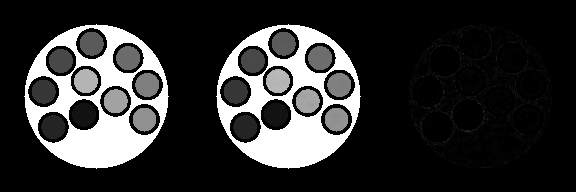

In [138]:
bart saxpy -- -1.0 subspace_T1map phan_ref_T1s subspace_diff_T1map
bart join 1 phan_ref_T1s subspace_T1map subspace_diff_T1map subspace_comparison
imshow subspace_comparison
python3 save_maps.py subspace_comparison viridis 0 2.0 subspace_comparison.png

### 2. In-vivo brain data

### 2.1 Load data

In [49]:
wget -q https://zenodo.org/record/4060287/files/IR-FLASH.cfl
wget -q https://zenodo.org/record/4060287/files/IR-FLASH.hdr

In [126]:
bart show -m IR-FLASH
READ=`bart show -d 0 IR-FLASH`
SPOKES=`bart show -d 2 IR-FLASH`
COILS=`bart show -d 3 IR-FLASH`
TIME=`bart show -d 10 IR-FLASH`
NBR2=$((READ/2))

Type: complex float
Dimensions: 16
AoD:	512	1	1	16	1	1	1	1	1	1	1020	1	1	1	1	1


### 2.2 Linear subspace reconstruction

### 2.2.1 Generation of golden-angle-based radial trajectory, gradient delays and data compression

In [127]:
GA=7
bart traj -r -c -D -G -x$READ -y1 -s$GA -t$((SPOKES*TIME)) traj

#reshape data
bart transpose 0 1 IR-FLASH ksp

# use steady-state data to do gradient-delay correction
nstate=100

bart extract 10 $((SPOKES*TIME-nstate)) $((SPOKES*TIME)) traj traj_extract
bart extract 10 $((SPOKES*TIME-nstate)) $((SPOKES*TIME)) ksp ksp_extract

bart transpose 10 2 traj_extract traj_extract1
bart transpose 10 2 ksp_extract ksp_extract1

bart traj -D -r -c -G -x$READ -y1 -s$GA -t$((SPOKES*TIME)) -q $(bart estdelay -R traj_extract1 ksp_extract1) trajn

# data compression
bart cc -A -p 8 ksp ksp_cc

Done.


### 2.2 Coil sensitivity estimation (by NLINV) using steady-state data

In [128]:
bart extract 10 $((SPOKES*TIME-300)) $((SPOKES*TIME)) trajn traj_state
bart extract 10 $((SPOKES*TIME-300)) $((SPOKES*TIME)) ksp_cc ksp_cc_state
bart transpose 2 10 traj_state traj_state1
bart transpose 2 10 ksp_cc_state ksp_cc_state1

ITER=12
DEBUG=4
bart nlinv -d$DEBUG -i$ITER -a1000 -t traj_state1 ksp_cc_state1 reco_nlinv sens_nlinv
bart resize -c 0 $READ 1 $READ sens_nlinv sens_nlinv1
bart scale 20. sens_nlinv1 sens

Est. image size: 512 514 1
nufft kernel dims: [  1 512 300   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
nufft psf dims:    [1024 1028   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
nufft traj dims:   [  3 512 300   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
Allocating 153600 (vs. 1206272) + 1052672
ksp : [  1 512 300   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
cim : [1024 1028   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
traj: [  3 512 300   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
ksp : [  1 512 300   8   1   1   1   1   1   1   1   1   1   1   1   1 ]
cim : [1024 1028   1   8   1   1   1   1   1   1   1   1   1   1   1   1 ]
traj: [  3 512 300   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
Scaling: 133.175537
Step: 0, Res: 99.999999
	 cg:   0
Step: 1, Res: 6663.066357
	 cg:   0
Step: 2, Res: 486.923266
	 cg:   0
Step: 3, Res: 486.303543
	 cg:   0
Step: 4, Res: 334.860330
	 cg:   0
Step: 5, R

### 2.3 Perform subspace-constrained reconstruction

In [129]:
bart reshape $(bart bitmask 2 5 10) $nspokes_per_frame $((SPOKES*TIME/nspokes_per_frame)) 1 trajn traj

bart reshape $(bart bitmask 4 5 10) $nspokes_per_frame $((SPOKES*TIME/nspokes_per_frame)) 1 ksp_cc ksp_cc1
bart transpose 4 2 ksp_cc1 ksp_cc2

ITER=100
REG=0.0015

bart pics -SeH -d5 -RW:$(bart bitmask 0 1):$(bart bitmask 6):$REG -i$ITER -t traj -B basis_${nCoe} ksp_cc2 sens subspace_reco
bart resize -c 0 $NBR2 1 $NBR2 subspace_reco coeff_maps

Basis: [512 512   1   8   1 102   4   1   1   1   1   1   1   1   1   1 ]
Max:   [512 512   1   8   1   1   4   1   1   1   1   1   1   1   1   1 ]
Hogwild stepsize
[  1 512  10   8   1 102   4   1   1   1   1   1   1   1   1   1 ]
[512 512   1   8   1   1   4   1   1   1   1   1   1   1   1   1 ]
ksp : [  1 512  10   8   1 102   4   1   1   1   1   1   1   1   1   1 ]
cim : [512 512   1   8   1   1   4   1   1   1   1   1   1   1   1   1 ]
traj: [  3 512  10   1   1 102   1   1   1   1   1   1   1   1   1   1 ]
wgh : [  1 512  10   1   1 102   1   1   1   1   1   1   1   1   1   1 ]
bas : [  1   1   1   1   1 102   4   1   1   1   1   1   1   1   1   1 ]
NUFFT: Toeplitz mode
psf_dims: [512 512   1   1   1 102   1   1   1   1   1   1   1   1   1   1 ]
nufft kernel dims: [  1 512  10   1   1   4   4   1   1   1   1   1   1   1   1   1   1 102 ]
nufft psf dims:    [1024 1024   1   1   1   4   4   1   1   1   1   1   1   1   1   1   1   1 ]
nufft traj dims:   [  3 512  10   1   1   1   1 

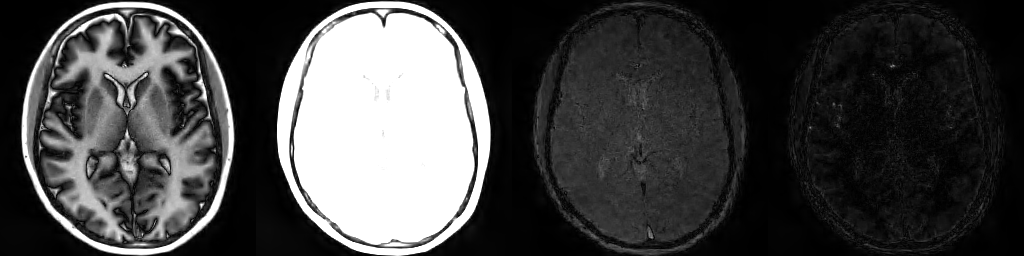

In [131]:
# Display all the coefficient maps
bart reshape $(bart bitmask 1 6) $((NBR2*nCoe)) 1 coeff_maps subspace_maps
bart flip $(bart bitmask 0) subspace_maps subspace_maps1
imshow subspace_maps1

### 2.4 Project the reconstructed coefficient maps to images and perform pixel-wise fitting to obtain T1 map

In [132]:
bart fmac -s $(bart bitmask 6) basis_${nCoe} coeff_maps imgs
python3 mapping_piecewise.py imgs T1 TI maps

bart extract 2 0 3 maps tmp1
bart transpose 2 6 tmp1 tmp2

bart looklocker -t0.1 -D15.3e-3 tmp2 tmp3
bart scale 0.5 tmp3 subspace_brain_T1map

Pixel: (0, 0)
Pixel: (0, 1)
Pixel: (0, 2)
Pixel: (0, 3)
Pixel: (0, 4)
Pixel: (0, 5)
Pixel: (0, 6)
Pixel: (0, 7)
Pixel: (0, 8)
Pixel: (0, 9)
Pixel: (0, 10)
Pixel: (0, 11)
Pixel: (0, 12)
Pixel: (0, 13)
Pixel: (0, 14)
Pixel: (0, 15)
Pixel: (0, 16)
Pixel: (0, 17)
Pixel: (0, 18)
Pixel: (0, 19)
Pixel: (0, 20)
Pixel: (0, 21)
Pixel: (0, 22)
Pixel: (0, 23)
Pixel: (0, 24)
Pixel: (0, 25)
Pixel: (0, 26)
Pixel: (0, 27)
Pixel: (0, 28)
Pixel: (0, 29)
Pixel: (0, 30)
Pixel: (0, 31)
Pixel: (0, 32)
Pixel: (0, 33)
Pixel: (0, 34)
Pixel: (0, 35)
Pixel: (0, 36)
Pixel: (0, 37)
Pixel: (0, 38)
Pixel: (0, 39)
Pixel: (0, 40)
Pixel: (0, 41)
Pixel: (0, 42)
Pixel: (0, 43)
Pixel: (0, 44)
Pixel: (0, 45)
Pixel: (0, 46)
Pixel: (0, 47)
Pixel: (0, 48)
Pixel: (0, 49)
Pixel: (0, 50)
Pixel: (0, 51)
Pixel: (0, 52)
Pixel: (0, 53)
Pixel: (0, 54)
Pixel: (0, 55)
Pixel: (0, 56)
Pixel: (0, 57)
Pixel: (0, 58)
Pixel: (0, 59)
Pixel: (0, 60)
Pixel: (0, 61)
Pixel: (0, 62)
Pixel: (0, 63)
Pixel: (0, 64)
Pixel: (0, 65)
Pixel: (0, 66)
Pixel

Pixel: (2, 16)
Pixel: (2, 17)
Pixel: (2, 18)
Pixel: (2, 19)
Pixel: (2, 20)
Pixel: (2, 21)
Pixel: (2, 22)
Pixel: (2, 23)
Pixel: (2, 24)
Pixel: (2, 25)
Pixel: (2, 26)
Pixel: (2, 27)
Pixel: (2, 28)
Pixel: (2, 29)
Pixel: (2, 30)
Pixel: (2, 31)
Pixel: (2, 32)
Pixel: (2, 33)
Pixel: (2, 34)
Pixel: (2, 35)
Pixel: (2, 36)
Pixel: (2, 37)
Pixel: (2, 38)
Pixel: (2, 39)
Pixel: (2, 40)
Pixel: (2, 41)
Pixel: (2, 42)
Pixel: (2, 43)
Pixel: (2, 44)
Pixel: (2, 45)
Pixel: (2, 46)
Pixel: (2, 47)
Pixel: (2, 48)
Pixel: (2, 49)
Pixel: (2, 50)
Pixel: (2, 51)
Pixel: (2, 52)
Pixel: (2, 53)
Pixel: (2, 54)
Pixel: (2, 55)
Pixel: (2, 56)
Pixel: (2, 57)
Pixel: (2, 58)
Pixel: (2, 59)
Pixel: (2, 60)
Pixel: (2, 61)
Pixel: (2, 62)
Pixel: (2, 63)
Pixel: (2, 64)
Pixel: (2, 65)
Pixel: (2, 66)
Pixel: (2, 67)
Pixel: (2, 68)
Pixel: (2, 69)
Pixel: (2, 70)
Pixel: (2, 71)
Pixel: (2, 72)
Pixel: (2, 73)
Pixel: (2, 74)
Pixel: (2, 75)
Pixel: (2, 76)
Pixel: (2, 77)
Pixel: (2, 78)
Pixel: (2, 79)
Pixel: (2, 80)
Pixel: (2, 81)
Pixel: (2,

Pixel: (4, 31)
Pixel: (4, 32)
Pixel: (4, 33)
Pixel: (4, 34)
Pixel: (4, 35)
Pixel: (4, 36)
Pixel: (4, 37)
Pixel: (4, 38)
Pixel: (4, 39)
Pixel: (4, 40)
Pixel: (4, 41)
Pixel: (4, 42)
Pixel: (4, 43)
Pixel: (4, 44)
Pixel: (4, 45)
Pixel: (4, 46)
Pixel: (4, 47)
Pixel: (4, 48)
Pixel: (4, 49)
Pixel: (4, 50)
Pixel: (4, 51)
Pixel: (4, 52)
Pixel: (4, 53)
Pixel: (4, 54)
Pixel: (4, 55)
Pixel: (4, 56)
Pixel: (4, 57)
Pixel: (4, 58)
Pixel: (4, 59)
Pixel: (4, 60)
Pixel: (4, 61)
Pixel: (4, 62)
Pixel: (4, 63)
Pixel: (4, 64)
Pixel: (4, 65)
Pixel: (4, 66)
Pixel: (4, 67)
Pixel: (4, 68)
Pixel: (4, 69)
Pixel: (4, 70)
Pixel: (4, 71)
Pixel: (4, 72)
Pixel: (4, 73)
Pixel: (4, 74)
Pixel: (4, 75)
Pixel: (4, 76)
Pixel: (4, 77)
Pixel: (4, 78)
Pixel: (4, 79)
Pixel: (4, 80)
Pixel: (4, 81)
Pixel: (4, 82)
Pixel: (4, 83)
Pixel: (4, 84)
Pixel: (4, 85)
Pixel: (4, 86)
Pixel: (4, 87)
Pixel: (4, 88)
Pixel: (4, 89)
Pixel: (4, 90)
Pixel: (4, 91)
Pixel: (4, 92)
Pixel: (4, 93)
Pixel: (4, 94)
Pixel: (4, 95)
Pixel: (4, 96)
Pixel: (4,

Pixel: (6, 46)
Pixel: (6, 47)
Pixel: (6, 48)
Pixel: (6, 49)
Pixel: (6, 50)
Pixel: (6, 51)
Pixel: (6, 52)
Pixel: (6, 53)
Pixel: (6, 54)
Pixel: (6, 55)
Pixel: (6, 56)
Pixel: (6, 57)
Pixel: (6, 58)
Pixel: (6, 59)
Pixel: (6, 60)
Pixel: (6, 61)
Pixel: (6, 62)
Pixel: (6, 63)
Pixel: (6, 64)
Pixel: (6, 65)
Pixel: (6, 66)
Pixel: (6, 67)
Pixel: (6, 68)
Pixel: (6, 69)
Pixel: (6, 70)
Pixel: (6, 71)
Pixel: (6, 72)
Pixel: (6, 73)
Pixel: (6, 74)
Pixel: (6, 75)
Pixel: (6, 76)
Pixel: (6, 77)
Pixel: (6, 78)
Pixel: (6, 79)
Pixel: (6, 80)
Pixel: (6, 81)
Pixel: (6, 82)
Pixel: (6, 83)
Pixel: (6, 84)
Pixel: (6, 85)
Pixel: (6, 86)
Pixel: (6, 87)
Pixel: (6, 88)
Pixel: (6, 89)
Pixel: (6, 90)
Pixel: (6, 91)
Pixel: (6, 92)
Pixel: (6, 93)
Pixel: (6, 94)
Pixel: (6, 95)
Pixel: (6, 96)
Pixel: (6, 97)
Pixel: (6, 98)
Pixel: (6, 99)
Pixel: (6, 100)
Pixel: (6, 101)
Pixel: (6, 102)
Pixel: (6, 103)
Pixel: (6, 104)
Pixel: (6, 105)
Pixel: (6, 106)
Pixel: (6, 107)
Pixel: (6, 108)
Pixel: (6, 109)
Pixel: (6, 110)
Pixel: (6, 111

Pixel: (8, 61)
Pixel: (8, 62)
Pixel: (8, 63)
Pixel: (8, 64)
Pixel: (8, 65)
Pixel: (8, 66)
Pixel: (8, 67)
Pixel: (8, 68)
Pixel: (8, 69)
Pixel: (8, 70)
Pixel: (8, 71)
Pixel: (8, 72)
Pixel: (8, 73)
Pixel: (8, 74)
Pixel: (8, 75)
Pixel: (8, 76)
Pixel: (8, 77)
Pixel: (8, 78)
Pixel: (8, 79)
Pixel: (8, 80)
Pixel: (8, 81)
Pixel: (8, 82)
Pixel: (8, 83)
Pixel: (8, 84)
Pixel: (8, 85)
Pixel: (8, 86)
Pixel: (8, 87)
Pixel: (8, 88)
Pixel: (8, 89)
Pixel: (8, 90)
Pixel: (8, 91)
Pixel: (8, 92)
Pixel: (8, 93)
Pixel: (8, 94)
Pixel: (8, 95)
Pixel: (8, 96)
Pixel: (8, 97)
Pixel: (8, 98)
Pixel: (8, 99)
Pixel: (8, 100)
Pixel: (8, 101)
Pixel: (8, 102)
Pixel: (8, 103)
Pixel: (8, 104)
Pixel: (8, 105)
Pixel: (8, 106)
Pixel: (8, 107)
Pixel: (8, 108)
Pixel: (8, 109)
Pixel: (8, 110)
Pixel: (8, 111)
Pixel: (8, 112)
Pixel: (8, 113)
Pixel: (8, 114)
Pixel: (8, 115)
Pixel: (8, 116)
Pixel: (8, 117)
Pixel: (8, 118)
Pixel: (8, 119)
Pixel: (8, 120)
Pixel: (8, 121)
Pixel: (8, 122)
Pixel: (8, 123)
Pixel: (8, 124)
Pixel: (8, 125)

Pixel: (10, 71)
Pixel: (10, 72)
Pixel: (10, 73)
Pixel: (10, 74)
Pixel: (10, 75)
Pixel: (10, 76)
Pixel: (10, 77)
Pixel: (10, 78)
Pixel: (10, 79)
Pixel: (10, 80)
Pixel: (10, 81)
Pixel: (10, 82)
Pixel: (10, 83)
Pixel: (10, 84)
Pixel: (10, 85)
Pixel: (10, 86)
Pixel: (10, 87)
Pixel: (10, 88)
Pixel: (10, 89)
Pixel: (10, 90)
Pixel: (10, 91)
Pixel: (10, 92)
Pixel: (10, 93)
Pixel: (10, 94)
Pixel: (10, 95)
Pixel: (10, 96)
Pixel: (10, 97)
Pixel: (10, 98)
Pixel: (10, 99)
Pixel: (10, 100)
Pixel: (10, 101)
Pixel: (10, 102)
Pixel: (10, 103)
Pixel: (10, 104)
Pixel: (10, 105)
Pixel: (10, 106)
Pixel: (10, 107)
Pixel: (10, 108)
Pixel: (10, 109)
Pixel: (10, 110)
Pixel: (10, 111)
Pixel: (10, 112)
Pixel: (10, 113)
Pixel: (10, 114)
Pixel: (10, 115)
Pixel: (10, 116)
Pixel: (10, 117)
Pixel: (10, 118)
Pixel: (10, 119)
Pixel: (10, 120)
Pixel: (10, 121)
Pixel: (10, 122)
Pixel: (10, 123)
Pixel: (10, 124)
Pixel: (10, 125)
Pixel: (10, 126)
Pixel: (10, 127)
Pixel: (10, 128)
Pixel: (10, 129)
Pixel: (10, 130)
Pixel: (1

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Pixel: (16, 207)
Pixel: (16, 208)
Pixel: (16, 209)
Pixel: (16, 210)
Pixel: (16, 211)
Pixel: (16, 212)
Pixel: (16, 213)
Pixel: (16, 214)
Pixel: (16, 215)
Pixel: (16, 216)
Pixel: (16, 217)
Pixel: (16, 218)
Pixel: (16, 219)
Pixel: (16, 220)
Pixel: (16, 221)
Pixel: (16, 222)
Pixel: (16, 223)
Pixel: (16, 224)
Pixel: (16, 225)
Pixel: (16, 226)
Pixel: (16, 227)
Pixel: (16, 228)
Pixel: (16, 229)
Pixel: (16, 230)
Pixel: (16, 231)
Pixel: (16, 232)
Pixel: (16, 233)
Pixel: (16, 234)
Pixel: (16, 235)
Pixel: (16, 236)
Pixel: (16, 237)
Pixel: (16, 238)
Pixel: (16, 239)
Pixel: (16, 240)
Pixel: (16, 241)
Pixel: (16, 242)
Pixel: (16, 243)
Pixel: (16, 244)
Pixel: (16, 245)
Pixel: (16, 246)
Pixel: (16, 247)
Pixel: (16, 248)
Pixel: (16, 249)
Pixel: (16, 250)
Pixel: (16, 251)
Pixel: (16, 252)
Pixel: (16, 253)
Pixel: (16, 254)
Pixel: (16, 255)
Pixel: (17, 0)
Pixel: (17, 1)
Pixel: (17, 2)
Pixel: (17, 3)
Pixel: (17, 4)
Pixel: (17, 5)
Pixel: (17, 6)
Pixel: (17, 7)
Pixel: (17, 8)
Pixel: (17, 9)
Pixel: (17, 10)
P

Pixel: (18, 190)
Pixel: (18, 191)
Pixel: (18, 192)
Pixel: (18, 193)
Pixel: (18, 194)
Pixel: (18, 195)
Pixel: (18, 196)
Pixel: (18, 197)
Pixel: (18, 198)
Pixel: (18, 199)
Pixel: (18, 200)
Pixel: (18, 201)
Pixel: (18, 202)
Pixel: (18, 203)
Pixel: (18, 204)
Pixel: (18, 205)
Pixel: (18, 206)
Pixel: (18, 207)
Pixel: (18, 208)
Pixel: (18, 209)
Pixel: (18, 210)
Pixel: (18, 211)
Pixel: (18, 212)
Pixel: (18, 213)
Pixel: (18, 214)
Pixel: (18, 215)
Pixel: (18, 216)
Pixel: (18, 217)
Pixel: (18, 218)
Pixel: (18, 219)
Pixel: (18, 220)
Pixel: (18, 221)
Pixel: (18, 222)
Pixel: (18, 223)
Pixel: (18, 224)
Pixel: (18, 225)
Pixel: (18, 226)
Pixel: (18, 227)
Pixel: (18, 228)
Pixel: (18, 229)
Pixel: (18, 230)
Pixel: (18, 231)
Pixel: (18, 232)
Pixel: (18, 233)
Pixel: (18, 234)
Pixel: (18, 235)
Pixel: (18, 236)
Pixel: (18, 237)
Pixel: (18, 238)
Pixel: (18, 239)
Pixel: (18, 240)
Pixel: (18, 241)
Pixel: (18, 242)
Pixel: (18, 243)
Pixel: (18, 244)
Pixel: (18, 245)
Pixel: (18, 246)
Pixel: (18, 247)
Pixel: (18, 24

Pixel: (20, 173)
Pixel: (20, 174)
Pixel: (20, 175)
Pixel: (20, 176)
Pixel: (20, 177)
Pixel: (20, 178)
Pixel: (20, 179)
Pixel: (20, 180)
Pixel: (20, 181)
Pixel: (20, 182)
Pixel: (20, 183)
Pixel: (20, 184)
Pixel: (20, 185)
Pixel: (20, 186)
Pixel: (20, 187)
Pixel: (20, 188)
Pixel: (20, 189)
Pixel: (20, 190)
Pixel: (20, 191)
Pixel: (20, 192)
Pixel: (20, 193)
Pixel: (20, 194)
Pixel: (20, 195)
Pixel: (20, 196)
Pixel: (20, 197)
Pixel: (20, 198)
Pixel: (20, 199)
Pixel: (20, 200)
Pixel: (20, 201)
Pixel: (20, 202)
Pixel: (20, 203)
Pixel: (20, 204)
Pixel: (20, 205)
Pixel: (20, 206)
Pixel: (20, 207)
Pixel: (20, 208)
Pixel: (20, 209)
Pixel: (20, 210)
Pixel: (20, 211)
Pixel: (20, 212)
Pixel: (20, 213)
Pixel: (20, 214)
Pixel: (20, 215)
Pixel: (20, 216)
Pixel: (20, 217)
Pixel: (20, 218)
Pixel: (20, 219)
Pixel: (20, 220)
Pixel: (20, 221)
Pixel: (20, 222)
Pixel: (20, 223)
Pixel: (20, 224)
Pixel: (20, 225)
Pixel: (20, 226)
Pixel: (20, 227)
Pixel: (20, 228)
Pixel: (20, 229)
Pixel: (20, 230)
Pixel: (20, 23

Pixel: (22, 156)
Pixel: (22, 157)
Pixel: (22, 158)
Pixel: (22, 159)
Pixel: (22, 160)
Pixel: (22, 161)
Pixel: (22, 162)
Pixel: (22, 163)
Pixel: (22, 164)
Pixel: (22, 165)
Pixel: (22, 166)
Pixel: (22, 167)
Pixel: (22, 168)
Pixel: (22, 169)
Pixel: (22, 170)
Pixel: (22, 171)
Pixel: (22, 172)
Pixel: (22, 173)
Pixel: (22, 174)
Pixel: (22, 175)
Pixel: (22, 176)
Pixel: (22, 177)
Pixel: (22, 178)
Pixel: (22, 179)
Pixel: (22, 180)
Pixel: (22, 181)
Pixel: (22, 182)
Pixel: (22, 183)
Pixel: (22, 184)
Pixel: (22, 185)
Pixel: (22, 186)
Pixel: (22, 187)
Pixel: (22, 188)
Pixel: (22, 189)
Pixel: (22, 190)
Pixel: (22, 191)
Pixel: (22, 192)
Pixel: (22, 193)
Pixel: (22, 194)
Pixel: (22, 195)
Pixel: (22, 196)
Pixel: (22, 197)
Pixel: (22, 198)
Pixel: (22, 199)
Pixel: (22, 200)
Pixel: (22, 201)
Pixel: (22, 202)
Pixel: (22, 203)
Pixel: (22, 204)
Pixel: (22, 205)
Pixel: (22, 206)
Pixel: (22, 207)
Pixel: (22, 208)
Pixel: (22, 209)
Pixel: (22, 210)
Pixel: (22, 211)
Pixel: (22, 212)
Pixel: (22, 213)
Pixel: (22, 21

Pixel: (24, 139)
Pixel: (24, 140)
Pixel: (24, 141)
Pixel: (24, 142)
Pixel: (24, 143)
Pixel: (24, 144)
Pixel: (24, 145)
Pixel: (24, 146)
Pixel: (24, 147)
Pixel: (24, 148)
Pixel: (24, 149)
Pixel: (24, 150)
Pixel: (24, 151)
Pixel: (24, 152)
Pixel: (24, 153)
Pixel: (24, 154)
Pixel: (24, 155)
Pixel: (24, 156)
Pixel: (24, 157)
Pixel: (24, 158)
Pixel: (24, 159)
Pixel: (24, 160)
Pixel: (24, 161)
Pixel: (24, 162)
Pixel: (24, 163)
Pixel: (24, 164)
Pixel: (24, 165)
Pixel: (24, 166)
Pixel: (24, 167)
Pixel: (24, 168)
Pixel: (24, 169)
Pixel: (24, 170)
Pixel: (24, 171)
Pixel: (24, 172)
Pixel: (24, 173)
Pixel: (24, 174)
Pixel: (24, 175)
Pixel: (24, 176)
Pixel: (24, 177)
Pixel: (24, 178)
Pixel: (24, 179)
Pixel: (24, 180)
Pixel: (24, 181)
Pixel: (24, 182)
Pixel: (24, 183)
Pixel: (24, 184)
Pixel: (24, 185)
Pixel: (24, 186)
Pixel: (24, 187)
Pixel: (24, 188)
Pixel: (24, 189)
Pixel: (24, 190)
Pixel: (24, 191)
Pixel: (24, 192)
Pixel: (24, 193)
Pixel: (24, 194)
Pixel: (24, 195)
Pixel: (24, 196)
Pixel: (24, 19

Pixel: (26, 122)
Pixel: (26, 123)
Pixel: (26, 124)
Pixel: (26, 125)
Pixel: (26, 126)
Pixel: (26, 127)
Pixel: (26, 128)
Pixel: (26, 129)
Pixel: (26, 130)
Pixel: (26, 131)
Pixel: (26, 132)
Pixel: (26, 133)
Pixel: (26, 134)
Pixel: (26, 135)
Pixel: (26, 136)
Pixel: (26, 137)
Pixel: (26, 138)
Pixel: (26, 139)
Pixel: (26, 140)
Pixel: (26, 141)
Pixel: (26, 142)
Pixel: (26, 143)
Pixel: (26, 144)
Pixel: (26, 145)
Pixel: (26, 146)
Pixel: (26, 147)
Pixel: (26, 148)
Pixel: (26, 149)
Pixel: (26, 150)
Pixel: (26, 151)
Pixel: (26, 152)
Pixel: (26, 153)
Pixel: (26, 154)
Pixel: (26, 155)
Pixel: (26, 156)
Pixel: (26, 157)
Pixel: (26, 158)
Pixel: (26, 159)
Pixel: (26, 160)
Pixel: (26, 161)
Pixel: (26, 162)
Pixel: (26, 163)
Pixel: (26, 164)
Pixel: (26, 165)
Pixel: (26, 166)
Pixel: (26, 167)
Pixel: (26, 168)
Pixel: (26, 169)
Pixel: (26, 170)
Pixel: (26, 171)
Pixel: (26, 172)
Pixel: (26, 173)
Pixel: (26, 174)
Pixel: (26, 175)
Pixel: (26, 176)
Pixel: (26, 177)
Pixel: (26, 178)
Pixel: (26, 179)
Pixel: (26, 18

Pixel: (28, 105)
Pixel: (28, 106)
Pixel: (28, 107)
Pixel: (28, 108)
Pixel: (28, 109)
Pixel: (28, 110)
Pixel: (28, 111)
Pixel: (28, 112)
Pixel: (28, 113)
Pixel: (28, 114)
Pixel: (28, 115)
Pixel: (28, 116)
Pixel: (28, 117)
Pixel: (28, 118)
Pixel: (28, 119)
Pixel: (28, 120)
Pixel: (28, 121)
Pixel: (28, 122)
Pixel: (28, 123)
Pixel: (28, 124)
Pixel: (28, 125)
Pixel: (28, 126)
Pixel: (28, 127)
Pixel: (28, 128)
Pixel: (28, 129)
Pixel: (28, 130)
Pixel: (28, 131)
Pixel: (28, 132)
Pixel: (28, 133)
Pixel: (28, 134)


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Pixel: (38, 146)
Pixel: (38, 147)
Pixel: (38, 148)
Pixel: (38, 149)
Pixel: (38, 150)
Pixel: (38, 151)
Pixel: (38, 152)
Pixel: (38, 153)
Pixel: (38, 154)
Pixel: (38, 155)
Pixel: (38, 156)
Pixel: (38, 157)
Pixel: (38, 158)
Pixel: (38, 159)
Pixel: (38, 160)
Pixel: (38, 161)
Pixel: (38, 162)
Pixel: (38, 163)
Pixel: (38, 164)
Pixel: (38, 165)
Pixel: (38, 166)
Pixel: (38, 167)
Pixel: (38, 168)
Pixel: (38, 169)
Pixel: (38, 170)
Pixel: (38, 171)
Pixel: (38, 172)
Pixel: (38, 173)
Pixel: (38, 174)
Pixel: (38, 175)
Pixel: (38, 176)
Pixel: (38, 177)
Pixel: (38, 178)
Pixel: (38, 179)
Pixel: (38, 180)
Pixel: (38, 181)
Pixel: (38, 182)
Pixel: (38, 183)
Pixel: (38, 184)
Pixel: (38, 185)
Pixel: (38, 186)
Pixel: (38, 187)
Pixel: (38, 188)
Pixel: (38, 189)
Pixel: (38, 190)
Pixel: (38, 191)
Pixel: (38, 192)
Pixel: (38, 193)
Pixel: (38, 194)
Pixel: (38, 195)
Pixel: (38, 196)
Pixel: (38, 197)
Pixel: (38, 198)
Pixel: (38, 199)
Pixel: (38, 200)
Pixel: (38, 201)
Pixel: (38, 202)
Pixel: (38, 203)
Pixel: (38, 20

Pixel: (40, 129)
Pixel: (40, 130)
Pixel: (40, 131)
Pixel: (40, 132)
Pixel: (40, 133)
Pixel: (40, 134)
Pixel: (40, 135)
Pixel: (40, 136)
Pixel: (40, 137)
Pixel: (40, 138)
Pixel: (40, 139)
Pixel: (40, 140)
Pixel: (40, 141)
Pixel: (40, 142)
Pixel: (40, 143)
Pixel: (40, 144)
Pixel: (40, 145)
Pixel: (40, 146)
Pixel: (40, 147)
Pixel: (40, 148)
Pixel: (40, 149)
Pixel: (40, 150)
Pixel: (40, 151)
Pixel: (40, 152)
Pixel: (40, 153)
Pixel: (40, 154)
Pixel: (40, 155)
Pixel: (40, 156)
Pixel: (40, 157)
Pixel: (40, 158)
Pixel: (40, 159)
Pixel: (40, 160)
Pixel: (40, 161)
Pixel: (40, 162)
Pixel: (40, 163)
Pixel: (40, 164)
Pixel: (40, 165)
Pixel: (40, 166)
Pixel: (40, 167)
Pixel: (40, 168)
Pixel: (40, 169)
Pixel: (40, 170)
Pixel: (40, 171)
Pixel: (40, 172)
Pixel: (40, 173)
Pixel: (40, 174)
Pixel: (40, 175)
Pixel: (40, 176)
Pixel: (40, 177)
Pixel: (40, 178)
Pixel: (40, 179)
Pixel: (40, 180)
Pixel: (40, 181)
Pixel: (40, 182)
Pixel: (40, 183)
Pixel: (40, 184)
Pixel: (40, 185)
Pixel: (40, 186)
Pixel: (40, 18

Pixel: (42, 112)
Pixel: (42, 113)
Pixel: (42, 114)
Pixel: (42, 115)
Pixel: (42, 116)
Pixel: (42, 117)
Pixel: (42, 118)
Pixel: (42, 119)
Pixel: (42, 120)
Pixel: (42, 121)
Pixel: (42, 122)
Pixel: (42, 123)
Pixel: (42, 124)
Pixel: (42, 125)
Pixel: (42, 126)
Pixel: (42, 127)
Pixel: (42, 128)
Pixel: (42, 129)
Pixel: (42, 130)
Pixel: (42, 131)
Pixel: (42, 132)
Pixel: (42, 133)
Pixel: (42, 134)
Pixel: (42, 135)
Pixel: (42, 136)
Pixel: (42, 137)
Pixel: (42, 138)
Pixel: (42, 139)
Pixel: (42, 140)
Pixel: (42, 141)
Pixel: (42, 142)
Pixel: (42, 143)
Pixel: (42, 144)
Pixel: (42, 145)
Pixel: (42, 146)
Pixel: (42, 147)
Pixel: (42, 148)
Pixel: (42, 149)
Pixel: (42, 150)
Pixel: (42, 151)
Pixel: (42, 152)
Pixel: (42, 153)
Pixel: (42, 154)
Pixel: (42, 155)
Pixel: (42, 156)
Pixel: (42, 157)
Pixel: (42, 158)
Pixel: (42, 159)
Pixel: (42, 160)
Pixel: (42, 161)
Pixel: (42, 162)
Pixel: (42, 163)
Pixel: (42, 164)
Pixel: (42, 165)
Pixel: (42, 166)
Pixel: (42, 167)
Pixel: (42, 168)
Pixel: (42, 169)
Pixel: (42, 17

Pixel: (44, 95)
Pixel: (44, 96)
Pixel: (44, 97)
Pixel: (44, 98)
Pixel: (44, 99)
Pixel: (44, 100)
Pixel: (44, 101)
Pixel: (44, 102)
Pixel: (44, 103)
Pixel: (44, 104)
Pixel: (44, 105)
Pixel: (44, 106)
Pixel: (44, 107)
Pixel: (44, 108)
Pixel: (44, 109)
Pixel: (44, 110)
Pixel: (44, 111)
Pixel: (44, 112)
Pixel: (44, 113)
Pixel: (44, 114)
Pixel: (44, 115)
Pixel: (44, 116)
Pixel: (44, 117)
Pixel: (44, 118)
Pixel: (44, 119)
Pixel: (44, 120)
Pixel: (44, 121)
Pixel: (44, 122)
Pixel: (44, 123)
Pixel: (44, 124)
Pixel: (44, 125)
Pixel: (44, 126)
Pixel: (44, 127)
Pixel: (44, 128)
Pixel: (44, 129)
Pixel: (44, 130)
Pixel: (44, 131)
Pixel: (44, 132)
Pixel: (44, 133)
Pixel: (44, 134)
Pixel: (44, 135)
Pixel: (44, 136)
Pixel: (44, 137)
Pixel: (44, 138)
Pixel: (44, 139)
Pixel: (44, 140)
Pixel: (44, 141)
Pixel: (44, 142)
Pixel: (44, 143)
Pixel: (44, 144)
Pixel: (44, 145)
Pixel: (44, 146)
Pixel: (44, 147)
Pixel: (44, 148)
Pixel: (44, 149)
Pixel: (44, 150)
Pixel: (44, 151)
Pixel: (44, 152)
Pixel: (44, 153)
Pi

Pixel: (46, 77)
Pixel: (46, 78)
Pixel: (46, 79)
Pixel: (46, 80)
Pixel: (46, 81)
Pixel: (46, 82)
Pixel: (46, 83)
Pixel: (46, 84)
Pixel: (46, 85)
Pixel: (46, 86)
Pixel: (46, 87)
Pixel: (46, 88)
Pixel: (46, 89)
Pixel: (46, 90)
Pixel: (46, 91)
Pixel: (46, 92)
Pixel: (46, 93)
Pixel: (46, 94)
Pixel: (46, 95)
Pixel: (46, 96)
Pixel: (46, 97)
Pixel: (46, 98)
Pixel: (46, 99)
Pixel: (46, 100)
Pixel: (46, 101)
Pixel: (46, 102)
Pixel: (46, 103)
Pixel: (46, 104)
Pixel: (46, 105)
Pixel: (46, 106)
Pixel: (46, 107)
Pixel: (46, 108)
Pixel: (46, 109)
Pixel: (46, 110)
Pixel: (46, 111)
Pixel: (46, 112)
Pixel: (46, 113)
Pixel: (46, 114)
Pixel: (46, 115)
Pixel: (46, 116)
Pixel: (46, 117)
Pixel: (46, 118)
Pixel: (46, 119)
Pixel: (46, 120)
Pixel: (46, 121)
Pixel: (46, 122)
Pixel: (46, 123)
Pixel: (46, 124)
Pixel: (46, 125)
Pixel: (46, 126)
Pixel: (46, 127)
Pixel: (46, 128)
Pixel: (46, 129)
Pixel: (46, 130)
Pixel: (46, 131)
Pixel: (46, 132)
Pixel: (46, 133)
Pixel: (46, 134)
Pixel: (46, 135)
Pixel: (46, 136)
Pix

Pixel: (48, 59)
Pixel: (48, 60)
Pixel: (48, 61)
Pixel: (48, 62)
Pixel: (48, 63)
Pixel: (48, 64)
Pixel: (48, 65)
Pixel: (48, 66)
Pixel: (48, 67)
Pixel: (48, 68)
Pixel: (48, 69)
Pixel: (48, 70)
Pixel: (48, 71)
Pixel: (48, 72)
Pixel: (48, 73)
Pixel: (48, 74)
Pixel: (48, 75)
Pixel: (48, 76)
Pixel: (48, 77)
Pixel: (48, 78)
Pixel: (48, 79)
Pixel: (48, 80)
Pixel: (48, 81)
Pixel: (48, 82)
Pixel: (48, 83)
Pixel: (48, 84)
Pixel: (48, 85)
Pixel: (48, 86)
Pixel: (48, 87)
Pixel: (48, 88)
Pixel: (48, 89)
Pixel: (48, 90)
Pixel: (48, 91)
Pixel: (48, 92)
Pixel: (48, 93)
Pixel: (48, 94)
Pixel: (48, 95)
Pixel: (48, 96)
Pixel: (48, 97)
Pixel: (48, 98)
Pixel: (48, 99)
Pixel: (48, 100)
Pixel: (48, 101)
Pixel: (48, 102)
Pixel: (48, 103)
Pixel: (48, 104)
Pixel: (48, 105)
Pixel: (48, 106)
Pixel: (48, 107)
Pixel: (48, 108)
Pixel: (48, 109)
Pixel: (48, 110)
Pixel: (48, 111)
Pixel: (48, 112)
Pixel: (48, 113)
Pixel: (48, 114)
Pixel: (48, 115)
Pixel: (48, 116)
Pixel: (48, 117)
Pixel: (48, 118)
Pixel: (48, 119)
Pixe

Pixel: (50, 41)
Pixel: (50, 42)
Pixel: (50, 43)
Pixel: (50, 44)
Pixel: (50, 45)
Pixel: (50, 46)
Pixel: (50, 47)
Pixel: (50, 48)
Pixel: (50, 49)
Pixel: (50, 50)
Pixel: (50, 51)
Pixel: (50, 52)
Pixel: (50, 53)
Pixel: (50, 54)
Pixel: (50, 55)
Pixel: (50, 56)
Pixel: (50, 57)
Pixel: (50, 58)
Pixel: (50, 59)
Pixel: (50, 60)
Pixel: (50, 61)
Pixel: (50, 62)
Pixel: (50, 63)
Pixel: (50, 64)
Pixel: (50, 65)
Pixel: (50, 66)
Pixel: (50, 67)
Pixel: (50, 68)
Pixel: (50, 69)
Pixel: (50, 70)
Pixel: (50, 71)
Pixel: (50, 72)
Pixel: (50, 73)


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Pixel: (60, 158)
Pixel: (60, 159)
Pixel: (60, 160)
Pixel: (60, 161)
Pixel: (60, 162)
Pixel: (60, 163)
Pixel: (60, 164)
Pixel: (60, 165)
Pixel: (60, 166)
Pixel: (60, 167)
Pixel: (60, 168)
Pixel: (60, 169)
Pixel: (60, 170)
Pixel: (60, 171)
Pixel: (60, 172)
Pixel: (60, 173)
Pixel: (60, 174)
Pixel: (60, 175)
Pixel: (60, 176)
Pixel: (60, 177)
Pixel: (60, 178)
Pixel: (60, 179)
Pixel: (60, 180)
Pixel: (60, 181)
Pixel: (60, 182)
Pixel: (60, 183)
Pixel: (60, 184)
Pixel: (60, 185)
Pixel: (60, 186)
Pixel: (60, 187)
Pixel: (60, 188)
Pixel: (60, 189)
Pixel: (60, 190)
Pixel: (60, 191)
Pixel: (60, 192)
Pixel: (60, 193)
Pixel: (60, 194)
Pixel: (60, 195)
Pixel: (60, 196)
Pixel: (60, 197)
Pixel: (60, 198)
Pixel: (60, 199)
Pixel: (60, 200)
Pixel: (60, 201)
Pixel: (60, 202)
Pixel: (60, 203)
Pixel: (60, 204)
Pixel: (60, 205)
Pixel: (60, 206)
Pixel: (60, 207)
Pixel: (60, 208)
Pixel: (60, 209)
Pixel: (60, 210)
Pixel: (60, 211)
Pixel: (60, 212)
Pixel: (60, 213)
Pixel: (60, 214)
Pixel: (60, 215)
Pixel: (60, 21

Pixel: (62, 141)
Pixel: (62, 142)
Pixel: (62, 143)
Pixel: (62, 144)
Pixel: (62, 145)
Pixel: (62, 146)
Pixel: (62, 147)
Pixel: (62, 148)
Pixel: (62, 149)
Pixel: (62, 150)
Pixel: (62, 151)
Pixel: (62, 152)
Pixel: (62, 153)
Pixel: (62, 154)
Pixel: (62, 155)
Pixel: (62, 156)
Pixel: (62, 157)
Pixel: (62, 158)
Pixel: (62, 159)
Pixel: (62, 160)
Pixel: (62, 161)
Pixel: (62, 162)
Pixel: (62, 163)
Pixel: (62, 164)
Pixel: (62, 165)
Pixel: (62, 166)
Pixel: (62, 167)
Pixel: (62, 168)
Pixel: (62, 169)
Pixel: (62, 170)
Pixel: (62, 171)
Pixel: (62, 172)
Pixel: (62, 173)
Pixel: (62, 174)
Pixel: (62, 175)
Pixel: (62, 176)
Pixel: (62, 177)
Pixel: (62, 178)
Pixel: (62, 179)
Pixel: (62, 180)
Pixel: (62, 181)
Pixel: (62, 182)
Pixel: (62, 183)
Pixel: (62, 184)
Pixel: (62, 185)
Pixel: (62, 186)
Pixel: (62, 187)
Pixel: (62, 188)
Pixel: (62, 189)
Pixel: (62, 190)
Pixel: (62, 191)
Pixel: (62, 192)
Pixel: (62, 193)
Pixel: (62, 194)
Pixel: (62, 195)
Pixel: (62, 196)
Pixel: (62, 197)
Pixel: (62, 198)
Pixel: (62, 19

Pixel: (64, 124)
Pixel: (64, 125)
Pixel: (64, 126)
Pixel: (64, 127)
Pixel: (64, 128)
Pixel: (64, 129)
Pixel: (64, 130)
Pixel: (64, 131)
Pixel: (64, 132)
Pixel: (64, 133)
Pixel: (64, 134)
Pixel: (64, 135)
Pixel: (64, 136)
Pixel: (64, 137)
Pixel: (64, 138)
Pixel: (64, 139)
Pixel: (64, 140)
Pixel: (64, 141)
Pixel: (64, 142)
Pixel: (64, 143)
Pixel: (64, 144)
Pixel: (64, 145)
Pixel: (64, 146)
Pixel: (64, 147)
Pixel: (64, 148)
Pixel: (64, 149)
Pixel: (64, 150)
Pixel: (64, 151)
Pixel: (64, 152)
Pixel: (64, 153)
Pixel: (64, 154)
Pixel: (64, 155)
Pixel: (64, 156)
Pixel: (64, 157)
Pixel: (64, 158)
Pixel: (64, 159)
Pixel: (64, 160)
Pixel: (64, 161)
Pixel: (64, 162)
Pixel: (64, 163)
Pixel: (64, 164)
Pixel: (64, 165)
Pixel: (64, 166)
Pixel: (64, 167)
Pixel: (64, 168)
Pixel: (64, 169)
Pixel: (64, 170)
Pixel: (64, 171)
Pixel: (64, 172)
Pixel: (64, 173)
Pixel: (64, 174)
Pixel: (64, 175)
Pixel: (64, 176)
Pixel: (64, 177)
Pixel: (64, 178)
Pixel: (64, 179)
Pixel: (64, 180)
Pixel: (64, 181)
Pixel: (64, 18

Pixel: (66, 107)
Pixel: (66, 108)
Pixel: (66, 109)
Pixel: (66, 110)
Pixel: (66, 111)
Pixel: (66, 112)
Pixel: (66, 113)
Pixel: (66, 114)
Pixel: (66, 115)
Pixel: (66, 116)
Pixel: (66, 117)
Pixel: (66, 118)
Pixel: (66, 119)
Pixel: (66, 120)
Pixel: (66, 121)
Pixel: (66, 122)
Pixel: (66, 123)
Pixel: (66, 124)
Pixel: (66, 125)
Pixel: (66, 126)
Pixel: (66, 127)
Pixel: (66, 128)
Pixel: (66, 129)
Pixel: (66, 130)
Pixel: (66, 131)
Pixel: (66, 132)
Pixel: (66, 133)
Pixel: (66, 134)
Pixel: (66, 135)
Pixel: (66, 136)
Pixel: (66, 137)
Pixel: (66, 138)
Pixel: (66, 139)
Pixel: (66, 140)
Pixel: (66, 141)
Pixel: (66, 142)
Pixel: (66, 143)
Pixel: (66, 144)
Pixel: (66, 145)
Pixel: (66, 146)
Pixel: (66, 147)
Pixel: (66, 148)
Pixel: (66, 149)
Pixel: (66, 150)
Pixel: (66, 151)
Pixel: (66, 152)
Pixel: (66, 153)
Pixel: (66, 154)
Pixel: (66, 155)
Pixel: (66, 156)
Pixel: (66, 157)
Pixel: (66, 158)
Pixel: (66, 159)
Pixel: (66, 160)
Pixel: (66, 161)
Pixel: (66, 162)
Pixel: (66, 163)
Pixel: (66, 164)
Pixel: (66, 16

Pixel: (68, 90)
Pixel: (68, 91)
Pixel: (68, 92)
Pixel: (68, 93)
Pixel: (68, 94)
Pixel: (68, 95)
Pixel: (68, 96)
Pixel: (68, 97)
Pixel: (68, 98)
Pixel: (68, 99)
Pixel: (68, 100)
Pixel: (68, 101)
Pixel: (68, 102)
Pixel: (68, 103)
Pixel: (68, 104)
Pixel: (68, 105)
Pixel: (68, 106)
Pixel: (68, 107)
Pixel: (68, 108)
Pixel: (68, 109)
Pixel: (68, 110)
Pixel: (68, 111)
Pixel: (68, 112)
Pixel: (68, 113)
Pixel: (68, 114)
Pixel: (68, 115)
Pixel: (68, 116)
Pixel: (68, 117)
Pixel: (68, 118)
Pixel: (68, 119)
Pixel: (68, 120)
Pixel: (68, 121)
Pixel: (68, 122)
Pixel: (68, 123)
Pixel: (68, 124)
Pixel: (68, 125)
Pixel: (68, 126)
Pixel: (68, 127)
Pixel: (68, 128)
Pixel: (68, 129)
Pixel: (68, 130)
Pixel: (68, 131)
Pixel: (68, 132)
Pixel: (68, 133)
Pixel: (68, 134)
Pixel: (68, 135)
Pixel: (68, 136)
Pixel: (68, 137)
Pixel: (68, 138)
Pixel: (68, 139)
Pixel: (68, 140)
Pixel: (68, 141)
Pixel: (68, 142)
Pixel: (68, 143)
Pixel: (68, 144)
Pixel: (68, 145)
Pixel: (68, 146)
Pixel: (68, 147)
Pixel: (68, 148)
Pixel: 

Pixel: (70, 72)
Pixel: (70, 73)
Pixel: (70, 74)
Pixel: (70, 75)
Pixel: (70, 76)
Pixel: (70, 77)
Pixel: (70, 78)
Pixel: (70, 79)
Pixel: (70, 80)
Pixel: (70, 81)
Pixel: (70, 82)
Pixel: (70, 83)
Pixel: (70, 84)
Pixel: (70, 85)
Pixel: (70, 86)
Pixel: (70, 87)
Pixel: (70, 88)
Pixel: (70, 89)
Pixel: (70, 90)
Pixel: (70, 91)
Pixel: (70, 92)
Pixel: (70, 93)
Pixel: (70, 94)
Pixel: (70, 95)
Pixel: (70, 96)
Pixel: (70, 97)
Pixel: (70, 98)
Pixel: (70, 99)
Pixel: (70, 100)
Pixel: (70, 101)
Pixel: (70, 102)
Pixel: (70, 103)
Pixel: (70, 104)
Pixel: (70, 105)
Pixel: (70, 106)
Pixel: (70, 107)
Pixel: (70, 108)
Pixel: (70, 109)
Pixel: (70, 110)
Pixel: (70, 111)
Pixel: (70, 112)
Pixel: (70, 113)
Pixel: (70, 114)
Pixel: (70, 115)
Pixel: (70, 116)
Pixel: (70, 117)
Pixel: (70, 118)
Pixel: (70, 119)
Pixel: (70, 120)
Pixel: (70, 121)
Pixel: (70, 122)
Pixel: (70, 123)
Pixel: (70, 124)
Pixel: (70, 125)
Pixel: (70, 126)
Pixel: (70, 127)
Pixel: (70, 128)
Pixel: (70, 129)
Pixel: (70, 130)
Pixel: (70, 131)
Pixel: (

Pixel: (72, 54)
Pixel: (72, 55)
Pixel: (72, 56)
Pixel: (72, 57)
Pixel: (72, 58)
Pixel: (72, 59)
Pixel: (72, 60)
Pixel: (72, 61)
Pixel: (72, 62)
Pixel: (72, 63)
Pixel: (72, 64)
Pixel: (72, 65)
Pixel: (72, 66)
Pixel: (72, 67)
Pixel: (72, 68)
Pixel: (72, 69)
Pixel: (72, 70)
Pixel: (72, 71)
Pixel: (72, 72)
Pixel: (72, 73)
Pixel: (72, 74)
Pixel: (72, 75)
Pixel: (72, 76)
Pixel: (72, 77)
Pixel: (72, 78)
Pixel: (72, 79)
Pixel: (72, 80)
Pixel: (72, 81)
Pixel: (72, 82)
Pixel: (72, 83)
Pixel: (72, 84)
Pixel: (72, 85)


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Pixel: (81, 254)
Pixel: (81, 255)
Pixel: (82, 0)
Pixel: (82, 1)
Pixel: (82, 2)
Pixel: (82, 3)
Pixel: (82, 4)
Pixel: (82, 5)
Pixel: (82, 6)
Pixel: (82, 7)
Pixel: (82, 8)
Pixel: (82, 9)
Pixel: (82, 10)
Pixel: (82, 11)
Pixel: (82, 12)
Pixel: (82, 13)
Pixel: (82, 14)
Pixel: (82, 15)
Pixel: (82, 16)
Pixel: (82, 17)
Pixel: (82, 18)
Pixel: (82, 19)
Pixel: (82, 20)
Pixel: (82, 21)
Pixel: (82, 22)
Pixel: (82, 23)
Pixel: (82, 24)
Pixel: (82, 25)
Pixel: (82, 26)
Pixel: (82, 27)
Pixel: (82, 28)
Pixel: (82, 29)
Pixel: (82, 30)
Pixel: (82, 31)
Pixel: (82, 32)
Pixel: (82, 33)
Pixel: (82, 34)
Pixel: (82, 35)
Pixel: (82, 36)
Pixel: (82, 37)
Pixel: (82, 38)
Pixel: (82, 39)
Pixel: (82, 40)
Pixel: (82, 41)
Pixel: (82, 42)
Pixel: (82, 43)
Pixel: (82, 44)
Pixel: (82, 45)
Pixel: (82, 46)
Pixel: (82, 47)
Pixel: (82, 48)
Pixel: (82, 49)
Pixel: (82, 50)
Pixel: (82, 51)
Pixel: (82, 52)
Pixel: (82, 53)
Pixel: (82, 54)
Pixel: (82, 55)
Pixel: (82, 56)
Pixel: (82, 57)
Pixel: (82, 58)
Pixel: (82, 59)
Pixel: (82, 60)


Pixel: (83, 237)
Pixel: (83, 238)
Pixel: (83, 239)
Pixel: (83, 240)
Pixel: (83, 241)
Pixel: (83, 242)
Pixel: (83, 243)
Pixel: (83, 244)
Pixel: (83, 245)
Pixel: (83, 246)
Pixel: (83, 247)
Pixel: (83, 248)
Pixel: (83, 249)
Pixel: (83, 250)
Pixel: (83, 251)
Pixel: (83, 252)
Pixel: (83, 253)
Pixel: (83, 254)
Pixel: (83, 255)
Pixel: (84, 0)
Pixel: (84, 1)
Pixel: (84, 2)
Pixel: (84, 3)
Pixel: (84, 4)
Pixel: (84, 5)
Pixel: (84, 6)
Pixel: (84, 7)
Pixel: (84, 8)
Pixel: (84, 9)
Pixel: (84, 10)
Pixel: (84, 11)
Pixel: (84, 12)
Pixel: (84, 13)
Pixel: (84, 14)
Pixel: (84, 15)
Pixel: (84, 16)
Pixel: (84, 17)
Pixel: (84, 18)
Pixel: (84, 19)
Pixel: (84, 20)
Pixel: (84, 21)
Pixel: (84, 22)
Pixel: (84, 23)
Pixel: (84, 24)
Pixel: (84, 25)
Pixel: (84, 26)
Pixel: (84, 27)
Pixel: (84, 28)
Pixel: (84, 29)
Pixel: (84, 30)
Pixel: (84, 31)
Pixel: (84, 32)
Pixel: (84, 33)
Pixel: (84, 34)
Pixel: (84, 35)
Pixel: (84, 36)
Pixel: (84, 37)
Pixel: (84, 38)
Pixel: (84, 39)
Pixel: (84, 40)
Pixel: (84, 41)
Pixel: (84, 42)

Pixel: (85, 220)
Pixel: (85, 221)
Pixel: (85, 222)
Pixel: (85, 223)
Pixel: (85, 224)
Pixel: (85, 225)
Pixel: (85, 226)
Pixel: (85, 227)
Pixel: (85, 228)
Pixel: (85, 229)
Pixel: (85, 230)
Pixel: (85, 231)
Pixel: (85, 232)
Pixel: (85, 233)
Pixel: (85, 234)
Pixel: (85, 235)
Pixel: (85, 236)
Pixel: (85, 237)
Pixel: (85, 238)
Pixel: (85, 239)
Pixel: (85, 240)
Pixel: (85, 241)
Pixel: (85, 242)
Pixel: (85, 243)
Pixel: (85, 244)
Pixel: (85, 245)
Pixel: (85, 246)
Pixel: (85, 247)
Pixel: (85, 248)
Pixel: (85, 249)
Pixel: (85, 250)
Pixel: (85, 251)
Pixel: (85, 252)
Pixel: (85, 253)
Pixel: (85, 254)
Pixel: (85, 255)
Pixel: (86, 0)
Pixel: (86, 1)
Pixel: (86, 2)
Pixel: (86, 3)
Pixel: (86, 4)
Pixel: (86, 5)
Pixel: (86, 6)
Pixel: (86, 7)
Pixel: (86, 8)
Pixel: (86, 9)
Pixel: (86, 10)
Pixel: (86, 11)
Pixel: (86, 12)
Pixel: (86, 13)
Pixel: (86, 14)
Pixel: (86, 15)
Pixel: (86, 16)
Pixel: (86, 17)
Pixel: (86, 18)
Pixel: (86, 19)
Pixel: (86, 20)
Pixel: (86, 21)
Pixel: (86, 22)
Pixel: (86, 23)
Pixel: (86, 24

Pixel: (87, 203)
Pixel: (87, 204)
Pixel: (87, 205)
Pixel: (87, 206)
Pixel: (87, 207)
Pixel: (87, 208)
Pixel: (87, 209)
Pixel: (87, 210)
Pixel: (87, 211)
Pixel: (87, 212)
Pixel: (87, 213)
Pixel: (87, 214)
Pixel: (87, 215)
Pixel: (87, 216)
Pixel: (87, 217)
Pixel: (87, 218)
Pixel: (87, 219)
Pixel: (87, 220)
Pixel: (87, 221)
Pixel: (87, 222)
Pixel: (87, 223)
Pixel: (87, 224)
Pixel: (87, 225)
Pixel: (87, 226)
Pixel: (87, 227)
Pixel: (87, 228)
Pixel: (87, 229)
Pixel: (87, 230)
Pixel: (87, 231)
Pixel: (87, 232)
Pixel: (87, 233)
Pixel: (87, 234)
Pixel: (87, 235)
Pixel: (87, 236)
Pixel: (87, 237)
Pixel: (87, 238)
Pixel: (87, 239)
Pixel: (87, 240)
Pixel: (87, 241)
Pixel: (87, 242)
Pixel: (87, 243)
Pixel: (87, 244)
Pixel: (87, 245)
Pixel: (87, 246)
Pixel: (87, 247)
Pixel: (87, 248)
Pixel: (87, 249)
Pixel: (87, 250)
Pixel: (87, 251)
Pixel: (87, 252)
Pixel: (87, 253)
Pixel: (87, 254)
Pixel: (87, 255)
Pixel: (88, 0)
Pixel: (88, 1)
Pixel: (88, 2)
Pixel: (88, 3)
Pixel: (88, 4)
Pixel: (88, 5)
Pixel: (8

Pixel: (89, 186)
Pixel: (89, 187)
Pixel: (89, 188)
Pixel: (89, 189)
Pixel: (89, 190)
Pixel: (89, 191)
Pixel: (89, 192)
Pixel: (89, 193)
Pixel: (89, 194)
Pixel: (89, 195)
Pixel: (89, 196)
Pixel: (89, 197)
Pixel: (89, 198)
Pixel: (89, 199)
Pixel: (89, 200)
Pixel: (89, 201)
Pixel: (89, 202)
Pixel: (89, 203)
Pixel: (89, 204)
Pixel: (89, 205)
Pixel: (89, 206)
Pixel: (89, 207)
Pixel: (89, 208)
Pixel: (89, 209)
Pixel: (89, 210)
Pixel: (89, 211)
Pixel: (89, 212)
Pixel: (89, 213)
Pixel: (89, 214)
Pixel: (89, 215)
Pixel: (89, 216)
Pixel: (89, 217)
Pixel: (89, 218)
Pixel: (89, 219)
Pixel: (89, 220)
Pixel: (89, 221)
Pixel: (89, 222)
Pixel: (89, 223)
Pixel: (89, 224)
Pixel: (89, 225)
Pixel: (89, 226)
Pixel: (89, 227)
Pixel: (89, 228)
Pixel: (89, 229)
Pixel: (89, 230)
Pixel: (89, 231)
Pixel: (89, 232)
Pixel: (89, 233)
Pixel: (89, 234)
Pixel: (89, 235)
Pixel: (89, 236)
Pixel: (89, 237)
Pixel: (89, 238)
Pixel: (89, 239)
Pixel: (89, 240)
Pixel: (89, 241)
Pixel: (89, 242)
Pixel: (89, 243)
Pixel: (89, 24

Pixel: (91, 169)
Pixel: (91, 170)
Pixel: (91, 171)
Pixel: (91, 172)
Pixel: (91, 173)
Pixel: (91, 174)
Pixel: (91, 175)
Pixel: (91, 176)
Pixel: (91, 177)
Pixel: (91, 178)
Pixel: (91, 179)
Pixel: (91, 180)
Pixel: (91, 181)
Pixel: (91, 182)
Pixel: (91, 183)
Pixel: (91, 184)
Pixel: (91, 185)
Pixel: (91, 186)
Pixel: (91, 187)
Pixel: (91, 188)
Pixel: (91, 189)
Pixel: (91, 190)
Pixel: (91, 191)
Pixel: (91, 192)
Pixel: (91, 193)
Pixel: (91, 194)
Pixel: (91, 195)
Pixel: (91, 196)
Pixel: (91, 197)
Pixel: (91, 198)
Pixel: (91, 199)
Pixel: (91, 200)
Pixel: (91, 201)
Pixel: (91, 202)
Pixel: (91, 203)
Pixel: (91, 204)
Pixel: (91, 205)
Pixel: (91, 206)
Pixel: (91, 207)
Pixel: (91, 208)
Pixel: (91, 209)
Pixel: (91, 210)
Pixel: (91, 211)
Pixel: (91, 212)
Pixel: (91, 213)
Pixel: (91, 214)
Pixel: (91, 215)
Pixel: (91, 216)
Pixel: (91, 217)
Pixel: (91, 218)
Pixel: (91, 219)
Pixel: (91, 220)
Pixel: (91, 221)
Pixel: (91, 222)
Pixel: (91, 223)
Pixel: (91, 224)
Pixel: (91, 225)
Pixel: (91, 226)
Pixel: (91, 22

Pixel: (93, 152)
Pixel: (93, 153)
Pixel: (93, 154)
Pixel: (93, 155)
Pixel: (93, 156)
Pixel: (93, 157)
Pixel: (93, 158)
Pixel: (93, 159)
Pixel: (93, 160)
Pixel: (93, 161)
Pixel: (93, 162)
Pixel: (93, 163)
Pixel: (93, 164)
Pixel: (93, 165)
Pixel: (93, 166)
Pixel: (93, 167)
Pixel: (93, 168)
Pixel: (93, 169)
Pixel: (93, 170)
Pixel: (93, 171)
Pixel: (93, 172)
Pixel: (93, 173)
Pixel: (93, 174)
Pixel: (93, 175)
Pixel: (93, 176)
Pixel: (93, 177)
Pixel: (93, 178)
Pixel: (93, 179)
Pixel: (93, 180)
Pixel: (93, 181)


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Pixel: (103, 112)
Pixel: (103, 113)
Pixel: (103, 114)
Pixel: (103, 115)
Pixel: (103, 116)
Pixel: (103, 117)
Pixel: (103, 118)
Pixel: (103, 119)
Pixel: (103, 120)
Pixel: (103, 121)
Pixel: (103, 122)
Pixel: (103, 123)
Pixel: (103, 124)
Pixel: (103, 125)
Pixel: (103, 126)
Pixel: (103, 127)
Pixel: (103, 128)
Pixel: (103, 129)
Pixel: (103, 130)
Pixel: (103, 131)
Pixel: (103, 132)
Pixel: (103, 133)
Pixel: (103, 134)
Pixel: (103, 135)
Pixel: (103, 136)
Pixel: (103, 137)
Pixel: (103, 138)
Pixel: (103, 139)
Pixel: (103, 140)
Pixel: (103, 141)
Pixel: (103, 142)
Pixel: (103, 143)
Pixel: (103, 144)
Pixel: (103, 145)
Pixel: (103, 146)
Pixel: (103, 147)
Pixel: (103, 148)
Pixel: (103, 149)
Pixel: (103, 150)
Pixel: (103, 151)
Pixel: (103, 152)
Pixel: (103, 153)
Pixel: (103, 154)
Pixel: (103, 155)
Pixel: (103, 156)
Pixel: (103, 157)
Pixel: (103, 158)
Pixel: (103, 159)
Pixel: (103, 160)
Pixel: (103, 161)
Pixel: (103, 162)
Pixel: (103, 163)
Pixel: (103, 164)
Pixel: (103, 165)
Pixel: (103, 166)
Pixel: (10

Pixel: (105, 66)
Pixel: (105, 67)
Pixel: (105, 68)
Pixel: (105, 69)
Pixel: (105, 70)
Pixel: (105, 71)
Pixel: (105, 72)
Pixel: (105, 73)
Pixel: (105, 74)
Pixel: (105, 75)
Pixel: (105, 76)
Pixel: (105, 77)
Pixel: (105, 78)
Pixel: (105, 79)
Pixel: (105, 80)
Pixel: (105, 81)
Pixel: (105, 82)
Pixel: (105, 83)
Pixel: (105, 84)
Pixel: (105, 85)
Pixel: (105, 86)
Pixel: (105, 87)
Pixel: (105, 88)
Pixel: (105, 89)
Pixel: (105, 90)
Pixel: (105, 91)
Pixel: (105, 92)
Pixel: (105, 93)
Pixel: (105, 94)
Pixel: (105, 95)
Pixel: (105, 96)
Pixel: (105, 97)
Pixel: (105, 98)
Pixel: (105, 99)
Pixel: (105, 100)
Pixel: (105, 101)
Pixel: (105, 102)
Pixel: (105, 103)
Pixel: (105, 104)
Pixel: (105, 105)
Pixel: (105, 106)
Pixel: (105, 107)
Pixel: (105, 108)
Pixel: (105, 109)
Pixel: (105, 110)
Pixel: (105, 111)
Pixel: (105, 112)
Pixel: (105, 113)
Pixel: (105, 114)
Pixel: (105, 115)
Pixel: (105, 116)
Pixel: (105, 117)
Pixel: (105, 118)
Pixel: (105, 119)
Pixel: (105, 120)
Pixel: (105, 121)
Pixel: (105, 122)
Pixel: (

Pixel: (107, 19)
Pixel: (107, 20)
Pixel: (107, 21)
Pixel: (107, 22)
Pixel: (107, 23)
Pixel: (107, 24)
Pixel: (107, 25)
Pixel: (107, 26)
Pixel: (107, 27)
Pixel: (107, 28)
Pixel: (107, 29)
Pixel: (107, 30)
Pixel: (107, 31)
Pixel: (107, 32)
Pixel: (107, 33)
Pixel: (107, 34)
Pixel: (107, 35)
Pixel: (107, 36)
Pixel: (107, 37)
Pixel: (107, 38)
Pixel: (107, 39)
Pixel: (107, 40)
Pixel: (107, 41)
Pixel: (107, 42)
Pixel: (107, 43)
Pixel: (107, 44)
Pixel: (107, 45)
Pixel: (107, 46)
Pixel: (107, 47)
Pixel: (107, 48)
Pixel: (107, 49)
Pixel: (107, 50)
Pixel: (107, 51)
Pixel: (107, 52)
Pixel: (107, 53)
Pixel: (107, 54)
Pixel: (107, 55)
Pixel: (107, 56)
Pixel: (107, 57)
Pixel: (107, 58)
Pixel: (107, 59)
Pixel: (107, 60)
Pixel: (107, 61)
Pixel: (107, 62)
Pixel: (107, 63)
Pixel: (107, 64)
Pixel: (107, 65)
Pixel: (107, 66)
Pixel: (107, 67)
Pixel: (107, 68)
Pixel: (107, 69)
Pixel: (107, 70)
Pixel: (107, 71)
Pixel: (107, 72)
Pixel: (107, 73)
Pixel: (107, 74)
Pixel: (107, 75)
Pixel: (107, 76)
Pixel: (107, 7

Pixel: (108, 229)
Pixel: (108, 230)
Pixel: (108, 231)
Pixel: (108, 232)
Pixel: (108, 233)
Pixel: (108, 234)
Pixel: (108, 235)
Pixel: (108, 236)
Pixel: (108, 237)
Pixel: (108, 238)
Pixel: (108, 239)
Pixel: (108, 240)
Pixel: (108, 241)
Pixel: (108, 242)
Pixel: (108, 243)
Pixel: (108, 244)
Pixel: (108, 245)
Pixel: (108, 246)
Pixel: (108, 247)
Pixel: (108, 248)
Pixel: (108, 249)
Pixel: (108, 250)
Pixel: (108, 251)
Pixel: (108, 252)
Pixel: (108, 253)
Pixel: (108, 254)
Pixel: (108, 255)
Pixel: (109, 0)
Pixel: (109, 1)
Pixel: (109, 2)
Pixel: (109, 3)
Pixel: (109, 4)
Pixel: (109, 5)
Pixel: (109, 6)
Pixel: (109, 7)
Pixel: (109, 8)
Pixel: (109, 9)
Pixel: (109, 10)
Pixel: (109, 11)
Pixel: (109, 12)
Pixel: (109, 13)
Pixel: (109, 14)
Pixel: (109, 15)
Pixel: (109, 16)
Pixel: (109, 17)
Pixel: (109, 18)
Pixel: (109, 19)
Pixel: (109, 20)
Pixel: (109, 21)
Pixel: (109, 22)
Pixel: (109, 23)
Pixel: (109, 24)
Pixel: (109, 25)
Pixel: (109, 26)
Pixel: (109, 27)
Pixel: (109, 28)
Pixel: (109, 29)
Pixel: (109, 3

Pixel: (110, 185)
Pixel: (110, 186)
Pixel: (110, 187)
Pixel: (110, 188)
Pixel: (110, 189)
Pixel: (110, 190)
Pixel: (110, 191)
Pixel: (110, 192)
Pixel: (110, 193)
Pixel: (110, 194)
Pixel: (110, 195)
Pixel: (110, 196)
Pixel: (110, 197)
Pixel: (110, 198)
Pixel: (110, 199)
Pixel: (110, 200)
Pixel: (110, 201)
Pixel: (110, 202)
Pixel: (110, 203)
Pixel: (110, 204)
Pixel: (110, 205)
Pixel: (110, 206)
Pixel: (110, 207)
Pixel: (110, 208)
Pixel: (110, 209)
Pixel: (110, 210)
Pixel: (110, 211)
Pixel: (110, 212)
Pixel: (110, 213)
Pixel: (110, 214)
Pixel: (110, 215)
Pixel: (110, 216)
Pixel: (110, 217)
Pixel: (110, 218)
Pixel: (110, 219)
Pixel: (110, 220)
Pixel: (110, 221)
Pixel: (110, 222)
Pixel: (110, 223)
Pixel: (110, 224)
Pixel: (110, 225)
Pixel: (110, 226)
Pixel: (110, 227)
Pixel: (110, 228)
Pixel: (110, 229)
Pixel: (110, 230)
Pixel: (110, 231)
Pixel: (110, 232)
Pixel: (110, 233)
Pixel: (110, 234)
Pixel: (110, 235)
Pixel: (110, 236)
Pixel: (110, 237)
Pixel: (110, 238)
Pixel: (110, 239)
Pixel: (11

Pixel: (112, 141)
Pixel: (112, 142)
Pixel: (112, 143)
Pixel: (112, 144)
Pixel: (112, 145)
Pixel: (112, 146)
Pixel: (112, 147)
Pixel: (112, 148)
Pixel: (112, 149)
Pixel: (112, 150)
Pixel: (112, 151)
Pixel: (112, 152)
Pixel: (112, 153)
Pixel: (112, 154)
Pixel: (112, 155)
Pixel: (112, 156)
Pixel: (112, 157)
Pixel: (112, 158)
Pixel: (112, 159)
Pixel: (112, 160)
Pixel: (112, 161)
Pixel: (112, 162)
Pixel: (112, 163)
Pixel: (112, 164)
Pixel: (112, 165)
Pixel: (112, 166)
Pixel: (112, 167)
Pixel: (112, 168)
Pixel: (112, 169)
Pixel: (112, 170)
Pixel: (112, 171)
Pixel: (112, 172)
Pixel: (112, 173)
Pixel: (112, 174)
Pixel: (112, 175)
Pixel: (112, 176)
Pixel: (112, 177)
Pixel: (112, 178)
Pixel: (112, 179)
Pixel: (112, 180)
Pixel: (112, 181)
Pixel: (112, 182)
Pixel: (112, 183)
Pixel: (112, 184)
Pixel: (112, 185)
Pixel: (112, 186)
Pixel: (112, 187)
Pixel: (112, 188)
Pixel: (112, 189)
Pixel: (112, 190)
Pixel: (112, 191)
Pixel: (112, 192)
Pixel: (112, 193)
Pixel: (112, 194)
Pixel: (112, 195)
Pixel: (11

Pixel: (114, 97)
Pixel: (114, 98)
Pixel: (114, 99)
Pixel: (114, 100)
Pixel: (114, 101)
Pixel: (114, 102)
Pixel: (114, 103)
Pixel: (114, 104)
Pixel: (114, 105)
Pixel: (114, 106)
Pixel: (114, 107)
Pixel: (114, 108)
Pixel: (114, 109)
Pixel: (114, 110)
Pixel: (114, 111)
Pixel: (114, 112)
Pixel: (114, 113)
Pixel: (114, 114)
Pixel: (114, 115)
Pixel: (114, 116)
Pixel: (114, 117)
Pixel: (114, 118)
Pixel: (114, 119)
Pixel: (114, 120)
Pixel: (114, 121)
Pixel: (114, 122)
Pixel: (114, 123)
Pixel: (114, 124)
Pixel: (114, 125)
Pixel: (114, 126)
Pixel: (114, 127)
Pixel: (114, 128)
Pixel: (114, 129)
Pixel: (114, 130)
Pixel: (114, 131)
Pixel: (114, 132)
Pixel: (114, 133)
Pixel: (114, 134)
Pixel: (114, 135)
Pixel: (114, 136)
Pixel: (114, 137)
Pixel: (114, 138)
Pixel: (114, 139)
Pixel: (114, 140)
Pixel: (114, 141)
Pixel: (114, 142)
Pixel: (114, 143)
Pixel: (114, 144)
Pixel: (114, 145)
Pixel: (114, 146)
Pixel: (114, 147)
Pixel: (114, 148)
Pixel: (114, 149)
Pixel: (114, 150)
Pixel: (114, 151)
Pixel: (114, 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Pixel: (122, 219)
Pixel: (122, 220)
Pixel: (122, 221)
Pixel: (122, 222)
Pixel: (122, 223)
Pixel: (122, 224)
Pixel: (122, 225)
Pixel: (122, 226)
Pixel: (122, 227)
Pixel: (122, 228)
Pixel: (122, 229)
Pixel: (122, 230)
Pixel: (122, 231)
Pixel: (122, 232)
Pixel: (122, 233)
Pixel: (122, 234)
Pixel: (122, 235)
Pixel: (122, 236)
Pixel: (122, 237)
Pixel: (122, 238)
Pixel: (122, 239)
Pixel: (122, 240)
Pixel: (122, 241)
Pixel: (122, 242)
Pixel: (122, 243)
Pixel: (122, 244)
Pixel: (122, 245)
Pixel: (122, 246)
Pixel: (122, 247)
Pixel: (122, 248)
Pixel: (122, 249)
Pixel: (122, 250)
Pixel: (122, 251)
Pixel: (122, 252)
Pixel: (122, 253)
Pixel: (122, 254)
Pixel: (122, 255)
Pixel: (123, 0)
Pixel: (123, 1)
Pixel: (123, 2)
Pixel: (123, 3)
Pixel: (123, 4)
Pixel: (123, 5)
Pixel: (123, 6)
Pixel: (123, 7)
Pixel: (123, 8)
Pixel: (123, 9)
Pixel: (123, 10)
Pixel: (123, 11)
Pixel: (123, 12)
Pixel: (123, 13)
Pixel: (123, 14)
Pixel: (123, 15)
Pixel: (123, 16)
Pixel: (123, 17)
Pixel: (123, 18)
Pixel: (123, 19)
Pixe

Pixel: (124, 175)
Pixel: (124, 176)
Pixel: (124, 177)
Pixel: (124, 178)
Pixel: (124, 179)
Pixel: (124, 180)
Pixel: (124, 181)
Pixel: (124, 182)
Pixel: (124, 183)
Pixel: (124, 184)
Pixel: (124, 185)
Pixel: (124, 186)
Pixel: (124, 187)
Pixel: (124, 188)
Pixel: (124, 189)
Pixel: (124, 190)
Pixel: (124, 191)
Pixel: (124, 192)
Pixel: (124, 193)
Pixel: (124, 194)
Pixel: (124, 195)
Pixel: (124, 196)
Pixel: (124, 197)
Pixel: (124, 198)
Pixel: (124, 199)
Pixel: (124, 200)
Pixel: (124, 201)
Pixel: (124, 202)
Pixel: (124, 203)
Pixel: (124, 204)
Pixel: (124, 205)
Pixel: (124, 206)
Pixel: (124, 207)
Pixel: (124, 208)
Pixel: (124, 209)
Pixel: (124, 210)
Pixel: (124, 211)
Pixel: (124, 212)
Pixel: (124, 213)
Pixel: (124, 214)
Pixel: (124, 215)
Pixel: (124, 216)
Pixel: (124, 217)
Pixel: (124, 218)
Pixel: (124, 219)
Pixel: (124, 220)
Pixel: (124, 221)
Pixel: (124, 222)
Pixel: (124, 223)
Pixel: (124, 224)
Pixel: (124, 225)
Pixel: (124, 226)
Pixel: (124, 227)
Pixel: (124, 228)
Pixel: (124, 229)
Pixel: (12

Pixel: (126, 131)
Pixel: (126, 132)
Pixel: (126, 133)
Pixel: (126, 134)
Pixel: (126, 135)
Pixel: (126, 136)
Pixel: (126, 137)
Pixel: (126, 138)
Pixel: (126, 139)
Pixel: (126, 140)
Pixel: (126, 141)
Pixel: (126, 142)
Pixel: (126, 143)
Pixel: (126, 144)
Pixel: (126, 145)
Pixel: (126, 146)
Pixel: (126, 147)
Pixel: (126, 148)
Pixel: (126, 149)
Pixel: (126, 150)
Pixel: (126, 151)
Pixel: (126, 152)
Pixel: (126, 153)
Pixel: (126, 154)
Pixel: (126, 155)
Pixel: (126, 156)
Pixel: (126, 157)
Pixel: (126, 158)
Pixel: (126, 159)
Pixel: (126, 160)
Pixel: (126, 161)
Pixel: (126, 162)
Pixel: (126, 163)
Pixel: (126, 164)
Pixel: (126, 165)
Pixel: (126, 166)
Pixel: (126, 167)
Pixel: (126, 168)
Pixel: (126, 169)
Pixel: (126, 170)
Pixel: (126, 171)
Pixel: (126, 172)
Pixel: (126, 173)
Pixel: (126, 174)
Pixel: (126, 175)
Pixel: (126, 176)
Pixel: (126, 177)
Pixel: (126, 178)
Pixel: (126, 179)
Pixel: (126, 180)
Pixel: (126, 181)
Pixel: (126, 182)
Pixel: (126, 183)
Pixel: (126, 184)
Pixel: (126, 185)
Pixel: (12

Pixel: (128, 86)
Pixel: (128, 87)
Pixel: (128, 88)
Pixel: (128, 89)
Pixel: (128, 90)
Pixel: (128, 91)
Pixel: (128, 92)
Pixel: (128, 93)
Pixel: (128, 94)
Pixel: (128, 95)
Pixel: (128, 96)
Pixel: (128, 97)
Pixel: (128, 98)
Pixel: (128, 99)
Pixel: (128, 100)
Pixel: (128, 101)
Pixel: (128, 102)
Pixel: (128, 103)
Pixel: (128, 104)
Pixel: (128, 105)
Pixel: (128, 106)
Pixel: (128, 107)
Pixel: (128, 108)
Pixel: (128, 109)
Pixel: (128, 110)
Pixel: (128, 111)
Pixel: (128, 112)
Pixel: (128, 113)
Pixel: (128, 114)
Pixel: (128, 115)
Pixel: (128, 116)
Pixel: (128, 117)
Pixel: (128, 118)
Pixel: (128, 119)
Pixel: (128, 120)
Pixel: (128, 121)
Pixel: (128, 122)
Pixel: (128, 123)
Pixel: (128, 124)
Pixel: (128, 125)
Pixel: (128, 126)
Pixel: (128, 127)
Pixel: (128, 128)
Pixel: (128, 129)
Pixel: (128, 130)
Pixel: (128, 131)
Pixel: (128, 132)
Pixel: (128, 133)
Pixel: (128, 134)
Pixel: (128, 135)
Pixel: (128, 136)
Pixel: (128, 137)
Pixel: (128, 138)
Pixel: (128, 139)
Pixel: (128, 140)
Pixel: (128, 141)
Pixel:

Pixel: (130, 39)
Pixel: (130, 40)
Pixel: (130, 41)
Pixel: (130, 42)
Pixel: (130, 43)
Pixel: (130, 44)
Pixel: (130, 45)
Pixel: (130, 46)
Pixel: (130, 47)
Pixel: (130, 48)
Pixel: (130, 49)
Pixel: (130, 50)
Pixel: (130, 51)
Pixel: (130, 52)
Pixel: (130, 53)
Pixel: (130, 54)
Pixel: (130, 55)
Pixel: (130, 56)
Pixel: (130, 57)
Pixel: (130, 58)
Pixel: (130, 59)
Pixel: (130, 60)
Pixel: (130, 61)
Pixel: (130, 62)
Pixel: (130, 63)
Pixel: (130, 64)
Pixel: (130, 65)
Pixel: (130, 66)
Pixel: (130, 67)
Pixel: (130, 68)
Pixel: (130, 69)
Pixel: (130, 70)
Pixel: (130, 71)
Pixel: (130, 72)
Pixel: (130, 73)
Pixel: (130, 74)
Pixel: (130, 75)
Pixel: (130, 76)
Pixel: (130, 77)
Pixel: (130, 78)
Pixel: (130, 79)
Pixel: (130, 80)
Pixel: (130, 81)
Pixel: (130, 82)
Pixel: (130, 83)
Pixel: (130, 84)
Pixel: (130, 85)
Pixel: (130, 86)
Pixel: (130, 87)
Pixel: (130, 88)
Pixel: (130, 89)
Pixel: (130, 90)
Pixel: (130, 91)
Pixel: (130, 92)
Pixel: (130, 93)
Pixel: (130, 94)
Pixel: (130, 95)
Pixel: (130, 96)
Pixel: (130, 9

Pixel: (131, 248)
Pixel: (131, 249)
Pixel: (131, 250)
Pixel: (131, 251)
Pixel: (131, 252)
Pixel: (131, 253)
Pixel: (131, 254)
Pixel: (131, 255)
Pixel: (132, 0)
Pixel: (132, 1)
Pixel: (132, 2)
Pixel: (132, 3)
Pixel: (132, 4)
Pixel: (132, 5)
Pixel: (132, 6)
Pixel: (132, 7)
Pixel: (132, 8)
Pixel: (132, 9)
Pixel: (132, 10)
Pixel: (132, 11)
Pixel: (132, 12)
Pixel: (132, 13)
Pixel: (132, 14)
Pixel: (132, 15)
Pixel: (132, 16)
Pixel: (132, 17)
Pixel: (132, 18)
Pixel: (132, 19)
Pixel: (132, 20)
Pixel: (132, 21)
Pixel: (132, 22)
Pixel: (132, 23)
Pixel: (132, 24)
Pixel: (132, 25)
Pixel: (132, 26)
Pixel: (132, 27)
Pixel: (132, 28)
Pixel: (132, 29)
Pixel: (132, 30)
Pixel: (132, 31)
Pixel: (132, 32)
Pixel: (132, 33)
Pixel: (132, 34)
Pixel: (132, 35)
Pixel: (132, 36)
Pixel: (132, 37)
Pixel: (132, 38)
Pixel: (132, 39)
Pixel: (132, 40)
Pixel: (132, 41)
Pixel: (132, 42)
Pixel: (132, 43)
Pixel: (132, 44)
Pixel: (132, 45)
Pixel: (132, 46)
Pixel: (132, 47)
Pixel: (132, 48)
Pixel: (132, 49)
Pixel: (132, 50)

Pixel: (133, 204)
Pixel: (133, 205)
Pixel: (133, 206)
Pixel: (133, 207)
Pixel: (133, 208)
Pixel: (133, 209)
Pixel: (133, 210)
Pixel: (133, 211)
Pixel: (133, 212)
Pixel: (133, 213)
Pixel: (133, 214)
Pixel: (133, 215)
Pixel: (133, 216)
Pixel: (133, 217)
Pixel: (133, 218)
Pixel: (133, 219)
Pixel: (133, 220)
Pixel: (133, 221)
Pixel: (133, 222)
Pixel: (133, 223)
Pixel: (133, 224)
Pixel: (133, 225)
Pixel: (133, 226)
Pixel: (133, 227)
Pixel: (133, 228)
Pixel: (133, 229)
Pixel: (133, 230)
Pixel: (133, 231)
Pixel: (133, 232)
Pixel: (133, 233)
Pixel: (133, 234)
Pixel: (133, 235)
Pixel: (133, 236)
Pixel: (133, 237)
Pixel: (133, 238)
Pixel: (133, 239)
Pixel: (133, 240)
Pixel: (133, 241)
Pixel: (133, 242)
Pixel: (133, 243)
Pixel: (133, 244)
Pixel: (133, 245)
Pixel: (133, 246)
Pixel: (133, 247)
Pixel: (133, 248)
Pixel: (133, 249)
Pixel: (133, 250)
Pixel: (133, 251)
Pixel: (133, 252)
Pixel: (133, 253)
Pixel: (133, 254)
Pixel: (133, 255)
Pixel: (134, 0)
Pixel: (134, 1)
Pixel: (134, 2)
Pixel: (134, 3)


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Pixel: (144, 231)
Pixel: (144, 232)
Pixel: (144, 233)
Pixel: (144, 234)
Pixel: (144, 235)
Pixel: (144, 236)
Pixel: (144, 237)
Pixel: (144, 238)
Pixel: (144, 239)
Pixel: (144, 240)
Pixel: (144, 241)
Pixel: (144, 242)
Pixel: (144, 243)
Pixel: (144, 244)
Pixel: (144, 245)
Pixel: (144, 246)
Pixel: (144, 247)
Pixel: (144, 248)
Pixel: (144, 249)
Pixel: (144, 250)
Pixel: (144, 251)
Pixel: (144, 252)
Pixel: (144, 253)
Pixel: (144, 254)
Pixel: (144, 255)
Pixel: (145, 0)
Pixel: (145, 1)
Pixel: (145, 2)
Pixel: (145, 3)
Pixel: (145, 4)
Pixel: (145, 5)
Pixel: (145, 6)
Pixel: (145, 7)
Pixel: (145, 8)
Pixel: (145, 9)
Pixel: (145, 10)
Pixel: (145, 11)
Pixel: (145, 12)
Pixel: (145, 13)
Pixel: (145, 14)
Pixel: (145, 15)
Pixel: (145, 16)
Pixel: (145, 17)
Pixel: (145, 18)
Pixel: (145, 19)
Pixel: (145, 20)
Pixel: (145, 21)
Pixel: (145, 22)
Pixel: (145, 23)
Pixel: (145, 24)
Pixel: (145, 25)
Pixel: (145, 26)
Pixel: (145, 27)
Pixel: (145, 28)
Pixel: (145, 29)
Pixel: (145, 30)
Pixel: (145, 31)
Pixel: (145, 32)

Pixel: (146, 187)
Pixel: (146, 188)
Pixel: (146, 189)
Pixel: (146, 190)
Pixel: (146, 191)
Pixel: (146, 192)
Pixel: (146, 193)
Pixel: (146, 194)
Pixel: (146, 195)
Pixel: (146, 196)
Pixel: (146, 197)
Pixel: (146, 198)
Pixel: (146, 199)
Pixel: (146, 200)
Pixel: (146, 201)
Pixel: (146, 202)
Pixel: (146, 203)
Pixel: (146, 204)
Pixel: (146, 205)
Pixel: (146, 206)
Pixel: (146, 207)
Pixel: (146, 208)
Pixel: (146, 209)
Pixel: (146, 210)
Pixel: (146, 211)
Pixel: (146, 212)
Pixel: (146, 213)
Pixel: (146, 214)
Pixel: (146, 215)
Pixel: (146, 216)
Pixel: (146, 217)
Pixel: (146, 218)
Pixel: (146, 219)
Pixel: (146, 220)
Pixel: (146, 221)
Pixel: (146, 222)
Pixel: (146, 223)
Pixel: (146, 224)
Pixel: (146, 225)
Pixel: (146, 226)
Pixel: (146, 227)
Pixel: (146, 228)
Pixel: (146, 229)
Pixel: (146, 230)
Pixel: (146, 231)
Pixel: (146, 232)
Pixel: (146, 233)
Pixel: (146, 234)
Pixel: (146, 235)
Pixel: (146, 236)
Pixel: (146, 237)
Pixel: (146, 238)
Pixel: (146, 239)
Pixel: (146, 240)
Pixel: (146, 241)
Pixel: (14

Pixel: (148, 143)
Pixel: (148, 144)
Pixel: (148, 145)
Pixel: (148, 146)
Pixel: (148, 147)
Pixel: (148, 148)
Pixel: (148, 149)
Pixel: (148, 150)
Pixel: (148, 151)
Pixel: (148, 152)
Pixel: (148, 153)
Pixel: (148, 154)
Pixel: (148, 155)
Pixel: (148, 156)
Pixel: (148, 157)
Pixel: (148, 158)
Pixel: (148, 159)
Pixel: (148, 160)
Pixel: (148, 161)
Pixel: (148, 162)
Pixel: (148, 163)
Pixel: (148, 164)
Pixel: (148, 165)
Pixel: (148, 166)
Pixel: (148, 167)
Pixel: (148, 168)
Pixel: (148, 169)
Pixel: (148, 170)
Pixel: (148, 171)
Pixel: (148, 172)
Pixel: (148, 173)
Pixel: (148, 174)
Pixel: (148, 175)
Pixel: (148, 176)
Pixel: (148, 177)
Pixel: (148, 178)
Pixel: (148, 179)
Pixel: (148, 180)
Pixel: (148, 181)
Pixel: (148, 182)
Pixel: (148, 183)
Pixel: (148, 184)
Pixel: (148, 185)
Pixel: (148, 186)
Pixel: (148, 187)
Pixel: (148, 188)
Pixel: (148, 189)
Pixel: (148, 190)
Pixel: (148, 191)
Pixel: (148, 192)
Pixel: (148, 193)
Pixel: (148, 194)
Pixel: (148, 195)
Pixel: (148, 196)
Pixel: (148, 197)
Pixel: (14

Pixel: (150, 99)
Pixel: (150, 100)
Pixel: (150, 101)
Pixel: (150, 102)
Pixel: (150, 103)
Pixel: (150, 104)
Pixel: (150, 105)
Pixel: (150, 106)
Pixel: (150, 107)
Pixel: (150, 108)
Pixel: (150, 109)
Pixel: (150, 110)
Pixel: (150, 111)
Pixel: (150, 112)
Pixel: (150, 113)
Pixel: (150, 114)
Pixel: (150, 115)
Pixel: (150, 116)
Pixel: (150, 117)
Pixel: (150, 118)
Pixel: (150, 119)
Pixel: (150, 120)
Pixel: (150, 121)
Pixel: (150, 122)
Pixel: (150, 123)
Pixel: (150, 124)
Pixel: (150, 125)
Pixel: (150, 126)
Pixel: (150, 127)
Pixel: (150, 128)
Pixel: (150, 129)
Pixel: (150, 130)
Pixel: (150, 131)
Pixel: (150, 132)
Pixel: (150, 133)
Pixel: (150, 134)
Pixel: (150, 135)
Pixel: (150, 136)
Pixel: (150, 137)
Pixel: (150, 138)
Pixel: (150, 139)
Pixel: (150, 140)
Pixel: (150, 141)
Pixel: (150, 142)
Pixel: (150, 143)
Pixel: (150, 144)
Pixel: (150, 145)
Pixel: (150, 146)
Pixel: (150, 147)
Pixel: (150, 148)
Pixel: (150, 149)
Pixel: (150, 150)
Pixel: (150, 151)
Pixel: (150, 152)
Pixel: (150, 153)
Pixel: (150

Pixel: (152, 52)
Pixel: (152, 53)
Pixel: (152, 54)
Pixel: (152, 55)
Pixel: (152, 56)
Pixel: (152, 57)
Pixel: (152, 58)
Pixel: (152, 59)
Pixel: (152, 60)
Pixel: (152, 61)
Pixel: (152, 62)
Pixel: (152, 63)
Pixel: (152, 64)
Pixel: (152, 65)
Pixel: (152, 66)
Pixel: (152, 67)
Pixel: (152, 68)
Pixel: (152, 69)
Pixel: (152, 70)
Pixel: (152, 71)
Pixel: (152, 72)
Pixel: (152, 73)
Pixel: (152, 74)
Pixel: (152, 75)
Pixel: (152, 76)
Pixel: (152, 77)
Pixel: (152, 78)
Pixel: (152, 79)
Pixel: (152, 80)
Pixel: (152, 81)
Pixel: (152, 82)
Pixel: (152, 83)
Pixel: (152, 84)
Pixel: (152, 85)
Pixel: (152, 86)
Pixel: (152, 87)
Pixel: (152, 88)
Pixel: (152, 89)
Pixel: (152, 90)
Pixel: (152, 91)
Pixel: (152, 92)
Pixel: (152, 93)
Pixel: (152, 94)
Pixel: (152, 95)
Pixel: (152, 96)
Pixel: (152, 97)
Pixel: (152, 98)
Pixel: (152, 99)
Pixel: (152, 100)
Pixel: (152, 101)
Pixel: (152, 102)
Pixel: (152, 103)
Pixel: (152, 104)
Pixel: (152, 105)
Pixel: (152, 106)
Pixel: (152, 107)
Pixel: (152, 108)
Pixel: (152, 109)
Pixe

Pixel: (154, 5)
Pixel: (154, 6)
Pixel: (154, 7)
Pixel: (154, 8)
Pixel: (154, 9)
Pixel: (154, 10)
Pixel: (154, 11)
Pixel: (154, 12)
Pixel: (154, 13)
Pixel: (154, 14)
Pixel: (154, 15)
Pixel: (154, 16)
Pixel: (154, 17)
Pixel: (154, 18)
Pixel: (154, 19)
Pixel: (154, 20)
Pixel: (154, 21)
Pixel: (154, 22)
Pixel: (154, 23)
Pixel: (154, 24)
Pixel: (154, 25)
Pixel: (154, 26)
Pixel: (154, 27)
Pixel: (154, 28)
Pixel: (154, 29)
Pixel: (154, 30)
Pixel: (154, 31)
Pixel: (154, 32)
Pixel: (154, 33)
Pixel: (154, 34)
Pixel: (154, 35)
Pixel: (154, 36)
Pixel: (154, 37)
Pixel: (154, 38)
Pixel: (154, 39)
Pixel: (154, 40)
Pixel: (154, 41)
Pixel: (154, 42)
Pixel: (154, 43)
Pixel: (154, 44)
Pixel: (154, 45)
Pixel: (154, 46)
Pixel: (154, 47)
Pixel: (154, 48)
Pixel: (154, 49)
Pixel: (154, 50)
Pixel: (154, 51)
Pixel: (154, 52)
Pixel: (154, 53)
Pixel: (154, 54)
Pixel: (154, 55)
Pixel: (154, 56)
Pixel: (154, 57)
Pixel: (154, 58)
Pixel: (154, 59)
Pixel: (154, 60)
Pixel: (154, 61)
Pixel: (154, 62)
Pixel: (154, 63)
Pi

Pixel: (155, 216)
Pixel: (155, 217)
Pixel: (155, 218)
Pixel: (155, 219)
Pixel: (155, 220)
Pixel: (155, 221)
Pixel: (155, 222)
Pixel: (155, 223)
Pixel: (155, 224)
Pixel: (155, 225)
Pixel: (155, 226)
Pixel: (155, 227)
Pixel: (155, 228)
Pixel: (155, 229)
Pixel: (155, 230)
Pixel: (155, 231)
Pixel: (155, 232)
Pixel: (155, 233)
Pixel: (155, 234)
Pixel: (155, 235)
Pixel: (155, 236)
Pixel: (155, 237)
Pixel: (155, 238)
Pixel: (155, 239)
Pixel: (155, 240)
Pixel: (155, 241)
Pixel: (155, 242)
Pixel: (155, 243)
Pixel: (155, 244)
Pixel: (155, 245)
Pixel: (155, 246)
Pixel: (155, 247)
Pixel: (155, 248)
Pixel: (155, 249)
Pixel: (155, 250)
Pixel: (155, 251)
Pixel: (155, 252)
Pixel: (155, 253)
Pixel: (155, 254)
Pixel: (155, 255)
Pixel: (156, 0)
Pixel: (156, 1)
Pixel: (156, 2)
Pixel: (156, 3)
Pixel: (156, 4)
Pixel: (156, 5)
Pixel: (156, 6)
Pixel: (156, 7)
Pixel: (156, 8)
Pixel: (156, 9)
Pixel: (156, 10)
Pixel: (156, 11)
Pixel: (156, 12)
Pixel: (156, 13)
Pixel: (156, 14)
Pixel: (156, 15)
Pixel: (156, 16)
P

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Pixel: (165, 191)
Pixel: (165, 192)
Pixel: (165, 193)
Pixel: (165, 194)
Pixel: (165, 195)
Pixel: (165, 196)
Pixel: (165, 197)
Pixel: (165, 198)
Pixel: (165, 199)
Pixel: (165, 200)
Pixel: (165, 201)
Pixel: (165, 202)
Pixel: (165, 203)
Pixel: (165, 204)
Pixel: (165, 205)
Pixel: (165, 206)
Pixel: (165, 207)
Pixel: (165, 208)
Pixel: (165, 209)
Pixel: (165, 210)
Pixel: (165, 211)
Pixel: (165, 212)
Pixel: (165, 213)
Pixel: (165, 214)
Pixel: (165, 215)
Pixel: (165, 216)
Pixel: (165, 217)
Pixel: (165, 218)
Pixel: (165, 219)
Pixel: (165, 220)
Pixel: (165, 221)
Pixel: (165, 222)
Pixel: (165, 223)
Pixel: (165, 224)
Pixel: (165, 225)
Pixel: (165, 226)
Pixel: (165, 227)
Pixel: (165, 228)
Pixel: (165, 229)
Pixel: (165, 230)
Pixel: (165, 231)
Pixel: (165, 232)
Pixel: (165, 233)
Pixel: (165, 234)
Pixel: (165, 235)
Pixel: (165, 236)
Pixel: (165, 237)
Pixel: (165, 238)
Pixel: (165, 239)
Pixel: (165, 240)
Pixel: (165, 241)
Pixel: (165, 242)
Pixel: (165, 243)
Pixel: (165, 244)
Pixel: (165, 245)
Pixel: (16

Pixel: (167, 147)
Pixel: (167, 148)
Pixel: (167, 149)
Pixel: (167, 150)
Pixel: (167, 151)
Pixel: (167, 152)
Pixel: (167, 153)
Pixel: (167, 154)
Pixel: (167, 155)
Pixel: (167, 156)
Pixel: (167, 157)
Pixel: (167, 158)
Pixel: (167, 159)
Pixel: (167, 160)
Pixel: (167, 161)
Pixel: (167, 162)
Pixel: (167, 163)
Pixel: (167, 164)
Pixel: (167, 165)
Pixel: (167, 166)
Pixel: (167, 167)
Pixel: (167, 168)
Pixel: (167, 169)
Pixel: (167, 170)
Pixel: (167, 171)
Pixel: (167, 172)
Pixel: (167, 173)
Pixel: (167, 174)
Pixel: (167, 175)
Pixel: (167, 176)
Pixel: (167, 177)
Pixel: (167, 178)
Pixel: (167, 179)
Pixel: (167, 180)
Pixel: (167, 181)
Pixel: (167, 182)
Pixel: (167, 183)
Pixel: (167, 184)
Pixel: (167, 185)
Pixel: (167, 186)
Pixel: (167, 187)
Pixel: (167, 188)
Pixel: (167, 189)
Pixel: (167, 190)
Pixel: (167, 191)
Pixel: (167, 192)
Pixel: (167, 193)
Pixel: (167, 194)
Pixel: (167, 195)
Pixel: (167, 196)
Pixel: (167, 197)
Pixel: (167, 198)
Pixel: (167, 199)
Pixel: (167, 200)
Pixel: (167, 201)
Pixel: (16

Pixel: (169, 103)
Pixel: (169, 104)
Pixel: (169, 105)
Pixel: (169, 106)
Pixel: (169, 107)
Pixel: (169, 108)
Pixel: (169, 109)
Pixel: (169, 110)
Pixel: (169, 111)
Pixel: (169, 112)
Pixel: (169, 113)
Pixel: (169, 114)
Pixel: (169, 115)
Pixel: (169, 116)
Pixel: (169, 117)
Pixel: (169, 118)
Pixel: (169, 119)
Pixel: (169, 120)
Pixel: (169, 121)
Pixel: (169, 122)
Pixel: (169, 123)
Pixel: (169, 124)
Pixel: (169, 125)
Pixel: (169, 126)
Pixel: (169, 127)
Pixel: (169, 128)
Pixel: (169, 129)
Pixel: (169, 130)
Pixel: (169, 131)
Pixel: (169, 132)
Pixel: (169, 133)
Pixel: (169, 134)
Pixel: (169, 135)
Pixel: (169, 136)
Pixel: (169, 137)
Pixel: (169, 138)
Pixel: (169, 139)
Pixel: (169, 140)
Pixel: (169, 141)
Pixel: (169, 142)
Pixel: (169, 143)
Pixel: (169, 144)
Pixel: (169, 145)
Pixel: (169, 146)
Pixel: (169, 147)
Pixel: (169, 148)
Pixel: (169, 149)
Pixel: (169, 150)
Pixel: (169, 151)
Pixel: (169, 152)
Pixel: (169, 153)
Pixel: (169, 154)
Pixel: (169, 155)
Pixel: (169, 156)
Pixel: (169, 157)
Pixel: (16

Pixel: (171, 56)
Pixel: (171, 57)
Pixel: (171, 58)
Pixel: (171, 59)
Pixel: (171, 60)
Pixel: (171, 61)
Pixel: (171, 62)
Pixel: (171, 63)
Pixel: (171, 64)
Pixel: (171, 65)
Pixel: (171, 66)
Pixel: (171, 67)
Pixel: (171, 68)
Pixel: (171, 69)
Pixel: (171, 70)
Pixel: (171, 71)
Pixel: (171, 72)
Pixel: (171, 73)
Pixel: (171, 74)
Pixel: (171, 75)
Pixel: (171, 76)
Pixel: (171, 77)
Pixel: (171, 78)
Pixel: (171, 79)
Pixel: (171, 80)
Pixel: (171, 81)
Pixel: (171, 82)
Pixel: (171, 83)
Pixel: (171, 84)
Pixel: (171, 85)
Pixel: (171, 86)
Pixel: (171, 87)
Pixel: (171, 88)
Pixel: (171, 89)
Pixel: (171, 90)
Pixel: (171, 91)
Pixel: (171, 92)
Pixel: (171, 93)
Pixel: (171, 94)
Pixel: (171, 95)
Pixel: (171, 96)
Pixel: (171, 97)
Pixel: (171, 98)
Pixel: (171, 99)
Pixel: (171, 100)
Pixel: (171, 101)
Pixel: (171, 102)
Pixel: (171, 103)
Pixel: (171, 104)
Pixel: (171, 105)
Pixel: (171, 106)
Pixel: (171, 107)
Pixel: (171, 108)
Pixel: (171, 109)
Pixel: (171, 110)
Pixel: (171, 111)
Pixel: (171, 112)
Pixel: (171, 113)


Pixel: (173, 9)
Pixel: (173, 10)
Pixel: (173, 11)
Pixel: (173, 12)
Pixel: (173, 13)
Pixel: (173, 14)
Pixel: (173, 15)
Pixel: (173, 16)
Pixel: (173, 17)
Pixel: (173, 18)
Pixel: (173, 19)
Pixel: (173, 20)
Pixel: (173, 21)
Pixel: (173, 22)
Pixel: (173, 23)
Pixel: (173, 24)
Pixel: (173, 25)
Pixel: (173, 26)
Pixel: (173, 27)
Pixel: (173, 28)
Pixel: (173, 29)
Pixel: (173, 30)
Pixel: (173, 31)
Pixel: (173, 32)
Pixel: (173, 33)
Pixel: (173, 34)
Pixel: (173, 35)
Pixel: (173, 36)
Pixel: (173, 37)
Pixel: (173, 38)
Pixel: (173, 39)
Pixel: (173, 40)
Pixel: (173, 41)
Pixel: (173, 42)
Pixel: (173, 43)
Pixel: (173, 44)
Pixel: (173, 45)
Pixel: (173, 46)
Pixel: (173, 47)
Pixel: (173, 48)
Pixel: (173, 49)
Pixel: (173, 50)
Pixel: (173, 51)
Pixel: (173, 52)
Pixel: (173, 53)
Pixel: (173, 54)
Pixel: (173, 55)
Pixel: (173, 56)
Pixel: (173, 57)
Pixel: (173, 58)
Pixel: (173, 59)
Pixel: (173, 60)
Pixel: (173, 61)
Pixel: (173, 62)
Pixel: (173, 63)
Pixel: (173, 64)
Pixel: (173, 65)
Pixel: (173, 66)
Pixel: (173, 67

Pixel: (174, 220)
Pixel: (174, 221)
Pixel: (174, 222)
Pixel: (174, 223)
Pixel: (174, 224)
Pixel: (174, 225)
Pixel: (174, 226)
Pixel: (174, 227)
Pixel: (174, 228)
Pixel: (174, 229)
Pixel: (174, 230)
Pixel: (174, 231)
Pixel: (174, 232)
Pixel: (174, 233)
Pixel: (174, 234)
Pixel: (174, 235)
Pixel: (174, 236)
Pixel: (174, 237)
Pixel: (174, 238)
Pixel: (174, 239)
Pixel: (174, 240)
Pixel: (174, 241)
Pixel: (174, 242)
Pixel: (174, 243)
Pixel: (174, 244)
Pixel: (174, 245)
Pixel: (174, 246)
Pixel: (174, 247)
Pixel: (174, 248)
Pixel: (174, 249)
Pixel: (174, 250)
Pixel: (174, 251)
Pixel: (174, 252)
Pixel: (174, 253)
Pixel: (174, 254)
Pixel: (174, 255)
Pixel: (175, 0)
Pixel: (175, 1)
Pixel: (175, 2)
Pixel: (175, 3)
Pixel: (175, 4)
Pixel: (175, 5)
Pixel: (175, 6)
Pixel: (175, 7)
Pixel: (175, 8)
Pixel: (175, 9)
Pixel: (175, 10)
Pixel: (175, 11)
Pixel: (175, 12)
Pixel: (175, 13)
Pixel: (175, 14)
Pixel: (175, 15)
Pixel: (175, 16)
Pixel: (175, 17)
Pixel: (175, 18)
Pixel: (175, 19)
Pixel: (175, 20)
Pixel

Pixel: (176, 176)
Pixel: (176, 177)
Pixel: (176, 178)
Pixel: (176, 179)
Pixel: (176, 180)
Pixel: (176, 181)
Pixel: (176, 182)
Pixel: (176, 183)
Pixel: (176, 184)
Pixel: (176, 185)
Pixel: (176, 186)
Pixel: (176, 187)
Pixel: (176, 188)
Pixel: (176, 189)
Pixel: (176, 190)
Pixel: (176, 191)
Pixel: (176, 192)
Pixel: (176, 193)
Pixel: (176, 194)
Pixel: (176, 195)
Pixel: (176, 196)
Pixel: (176, 197)
Pixel: (176, 198)
Pixel: (176, 199)
Pixel: (176, 200)
Pixel: (176, 201)
Pixel: (176, 202)
Pixel: (176, 203)
Pixel: (176, 204)
Pixel: (176, 205)
Pixel: (176, 206)
Pixel: (176, 207)
Pixel: (176, 208)
Pixel: (176, 209)
Pixel: (176, 210)
Pixel: (176, 211)
Pixel: (176, 212)
Pixel: (176, 213)
Pixel: (176, 214)
Pixel: (176, 215)
Pixel: (176, 216)
Pixel: (176, 217)
Pixel: (176, 218)
Pixel: (176, 219)
Pixel: (176, 220)
Pixel: (176, 221)
Pixel: (176, 222)
Pixel: (176, 223)
Pixel: (176, 224)
Pixel: (176, 225)
Pixel: (176, 226)
Pixel: (176, 227)
Pixel: (176, 228)
Pixel: (176, 229)
Pixel: (176, 230)
Pixel: (17

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Pixel: (187, 9)
Pixel: (187, 10)
Pixel: (187, 11)
Pixel: (187, 12)
Pixel: (187, 13)
Pixel: (187, 14)
Pixel: (187, 15)
Pixel: (187, 16)
Pixel: (187, 17)
Pixel: (187, 18)
Pixel: (187, 19)
Pixel: (187, 20)
Pixel: (187, 21)
Pixel: (187, 22)
Pixel: (187, 23)
Pixel: (187, 24)
Pixel: (187, 25)
Pixel: (187, 26)
Pixel: (187, 27)
Pixel: (187, 28)
Pixel: (187, 29)
Pixel: (187, 30)
Pixel: (187, 31)
Pixel: (187, 32)
Pixel: (187, 33)
Pixel: (187, 34)
Pixel: (187, 35)
Pixel: (187, 36)
Pixel: (187, 37)
Pixel: (187, 38)
Pixel: (187, 39)
Pixel: (187, 40)
Pixel: (187, 41)
Pixel: (187, 42)
Pixel: (187, 43)
Pixel: (187, 44)
Pixel: (187, 45)
Pixel: (187, 46)
Pixel: (187, 47)
Pixel: (187, 48)
Pixel: (187, 49)
Pixel: (187, 50)
Pixel: (187, 51)
Pixel: (187, 52)
Pixel: (187, 53)
Pixel: (187, 54)
Pixel: (187, 55)
Pixel: (187, 56)
Pixel: (187, 57)
Pixel: (187, 58)
Pixel: (187, 59)
Pixel: (187, 60)
Pixel: (187, 61)
Pixel: (187, 62)
Pixel: (187, 63)
Pixel: (187, 64)
Pixel: (187, 65)
Pixel: (187, 66)
Pixel: (187, 67

Pixel: (188, 220)
Pixel: (188, 221)
Pixel: (188, 222)
Pixel: (188, 223)
Pixel: (188, 224)
Pixel: (188, 225)
Pixel: (188, 226)
Pixel: (188, 227)
Pixel: (188, 228)
Pixel: (188, 229)
Pixel: (188, 230)
Pixel: (188, 231)
Pixel: (188, 232)
Pixel: (188, 233)
Pixel: (188, 234)
Pixel: (188, 235)
Pixel: (188, 236)
Pixel: (188, 237)
Pixel: (188, 238)
Pixel: (188, 239)
Pixel: (188, 240)
Pixel: (188, 241)
Pixel: (188, 242)
Pixel: (188, 243)
Pixel: (188, 244)
Pixel: (188, 245)
Pixel: (188, 246)
Pixel: (188, 247)
Pixel: (188, 248)
Pixel: (188, 249)
Pixel: (188, 250)
Pixel: (188, 251)
Pixel: (188, 252)
Pixel: (188, 253)
Pixel: (188, 254)
Pixel: (188, 255)
Pixel: (189, 0)
Pixel: (189, 1)
Pixel: (189, 2)
Pixel: (189, 3)
Pixel: (189, 4)
Pixel: (189, 5)
Pixel: (189, 6)
Pixel: (189, 7)
Pixel: (189, 8)
Pixel: (189, 9)
Pixel: (189, 10)
Pixel: (189, 11)
Pixel: (189, 12)
Pixel: (189, 13)
Pixel: (189, 14)
Pixel: (189, 15)
Pixel: (189, 16)
Pixel: (189, 17)
Pixel: (189, 18)
Pixel: (189, 19)
Pixel: (189, 20)
Pixel

Pixel: (190, 176)
Pixel: (190, 177)
Pixel: (190, 178)
Pixel: (190, 179)
Pixel: (190, 180)
Pixel: (190, 181)
Pixel: (190, 182)
Pixel: (190, 183)
Pixel: (190, 184)
Pixel: (190, 185)
Pixel: (190, 186)
Pixel: (190, 187)
Pixel: (190, 188)
Pixel: (190, 189)
Pixel: (190, 190)
Pixel: (190, 191)
Pixel: (190, 192)
Pixel: (190, 193)
Pixel: (190, 194)
Pixel: (190, 195)
Pixel: (190, 196)
Pixel: (190, 197)
Pixel: (190, 198)
Pixel: (190, 199)
Pixel: (190, 200)
Pixel: (190, 201)
Pixel: (190, 202)
Pixel: (190, 203)
Pixel: (190, 204)
Pixel: (190, 205)
Pixel: (190, 206)
Pixel: (190, 207)
Pixel: (190, 208)
Pixel: (190, 209)
Pixel: (190, 210)
Pixel: (190, 211)
Pixel: (190, 212)
Pixel: (190, 213)
Pixel: (190, 214)
Pixel: (190, 215)
Pixel: (190, 216)
Pixel: (190, 217)
Pixel: (190, 218)
Pixel: (190, 219)
Pixel: (190, 220)
Pixel: (190, 221)
Pixel: (190, 222)
Pixel: (190, 223)
Pixel: (190, 224)
Pixel: (190, 225)
Pixel: (190, 226)
Pixel: (190, 227)
Pixel: (190, 228)
Pixel: (190, 229)
Pixel: (190, 230)
Pixel: (19

Pixel: (192, 132)
Pixel: (192, 133)
Pixel: (192, 134)
Pixel: (192, 135)
Pixel: (192, 136)
Pixel: (192, 137)
Pixel: (192, 138)
Pixel: (192, 139)
Pixel: (192, 140)
Pixel: (192, 141)
Pixel: (192, 142)
Pixel: (192, 143)
Pixel: (192, 144)
Pixel: (192, 145)
Pixel: (192, 146)
Pixel: (192, 147)
Pixel: (192, 148)
Pixel: (192, 149)
Pixel: (192, 150)
Pixel: (192, 151)
Pixel: (192, 152)
Pixel: (192, 153)
Pixel: (192, 154)
Pixel: (192, 155)
Pixel: (192, 156)
Pixel: (192, 157)
Pixel: (192, 158)
Pixel: (192, 159)
Pixel: (192, 160)
Pixel: (192, 161)
Pixel: (192, 162)
Pixel: (192, 163)
Pixel: (192, 164)
Pixel: (192, 165)
Pixel: (192, 166)
Pixel: (192, 167)
Pixel: (192, 168)
Pixel: (192, 169)
Pixel: (192, 170)
Pixel: (192, 171)
Pixel: (192, 172)
Pixel: (192, 173)
Pixel: (192, 174)
Pixel: (192, 175)
Pixel: (192, 176)
Pixel: (192, 177)
Pixel: (192, 178)
Pixel: (192, 179)
Pixel: (192, 180)
Pixel: (192, 181)
Pixel: (192, 182)
Pixel: (192, 183)
Pixel: (192, 184)
Pixel: (192, 185)
Pixel: (192, 186)
Pixel: (19

Pixel: (194, 87)
Pixel: (194, 88)
Pixel: (194, 89)
Pixel: (194, 90)
Pixel: (194, 91)
Pixel: (194, 92)
Pixel: (194, 93)
Pixel: (194, 94)
Pixel: (194, 95)
Pixel: (194, 96)
Pixel: (194, 97)
Pixel: (194, 98)
Pixel: (194, 99)
Pixel: (194, 100)
Pixel: (194, 101)
Pixel: (194, 102)
Pixel: (194, 103)
Pixel: (194, 104)
Pixel: (194, 105)
Pixel: (194, 106)
Pixel: (194, 107)
Pixel: (194, 108)
Pixel: (194, 109)
Pixel: (194, 110)
Pixel: (194, 111)
Pixel: (194, 112)
Pixel: (194, 113)
Pixel: (194, 114)
Pixel: (194, 115)
Pixel: (194, 116)
Pixel: (194, 117)
Pixel: (194, 118)
Pixel: (194, 119)
Pixel: (194, 120)
Pixel: (194, 121)
Pixel: (194, 122)
Pixel: (194, 123)
Pixel: (194, 124)
Pixel: (194, 125)
Pixel: (194, 126)
Pixel: (194, 127)
Pixel: (194, 128)
Pixel: (194, 129)
Pixel: (194, 130)
Pixel: (194, 131)
Pixel: (194, 132)
Pixel: (194, 133)
Pixel: (194, 134)
Pixel: (194, 135)
Pixel: (194, 136)
Pixel: (194, 137)
Pixel: (194, 138)
Pixel: (194, 139)
Pixel: (194, 140)
Pixel: (194, 141)
Pixel: (194, 142)
Pixel

Pixel: (196, 40)
Pixel: (196, 41)
Pixel: (196, 42)
Pixel: (196, 43)
Pixel: (196, 44)
Pixel: (196, 45)
Pixel: (196, 46)
Pixel: (196, 47)
Pixel: (196, 48)
Pixel: (196, 49)
Pixel: (196, 50)
Pixel: (196, 51)
Pixel: (196, 52)
Pixel: (196, 53)
Pixel: (196, 54)
Pixel: (196, 55)
Pixel: (196, 56)
Pixel: (196, 57)
Pixel: (196, 58)
Pixel: (196, 59)
Pixel: (196, 60)
Pixel: (196, 61)
Pixel: (196, 62)
Pixel: (196, 63)
Pixel: (196, 64)
Pixel: (196, 65)
Pixel: (196, 66)
Pixel: (196, 67)
Pixel: (196, 68)
Pixel: (196, 69)
Pixel: (196, 70)
Pixel: (196, 71)
Pixel: (196, 72)
Pixel: (196, 73)
Pixel: (196, 74)
Pixel: (196, 75)
Pixel: (196, 76)
Pixel: (196, 77)
Pixel: (196, 78)
Pixel: (196, 79)
Pixel: (196, 80)
Pixel: (196, 81)
Pixel: (196, 82)
Pixel: (196, 83)
Pixel: (196, 84)
Pixel: (196, 85)
Pixel: (196, 86)
Pixel: (196, 87)
Pixel: (196, 88)
Pixel: (196, 89)
Pixel: (196, 90)
Pixel: (196, 91)
Pixel: (196, 92)
Pixel: (196, 93)
Pixel: (196, 94)
Pixel: (196, 95)
Pixel: (196, 96)
Pixel: (196, 97)
Pixel: (196, 9

Pixel: (197, 249)
Pixel: (197, 250)
Pixel: (197, 251)
Pixel: (197, 252)
Pixel: (197, 253)
Pixel: (197, 254)
Pixel: (197, 255)
Pixel: (198, 0)
Pixel: (198, 1)
Pixel: (198, 2)
Pixel: (198, 3)
Pixel: (198, 4)
Pixel: (198, 5)
Pixel: (198, 6)
Pixel: (198, 7)
Pixel: (198, 8)
Pixel: (198, 9)
Pixel: (198, 10)
Pixel: (198, 11)
Pixel: (198, 12)
Pixel: (198, 13)
Pixel: (198, 14)
Pixel: (198, 15)
Pixel: (198, 16)
Pixel: (198, 17)
Pixel: (198, 18)
Pixel: (198, 19)
Pixel: (198, 20)
Pixel: (198, 21)
Pixel: (198, 22)
Pixel: (198, 23)
Pixel: (198, 24)
Pixel: (198, 25)
Pixel: (198, 26)
Pixel: (198, 27)
Pixel: (198, 28)
Pixel: (198, 29)
Pixel: (198, 30)
Pixel: (198, 31)
Pixel: (198, 32)
Pixel: (198, 33)
Pixel: (198, 34)
Pixel: (198, 35)
Pixel: (198, 36)
Pixel: (198, 37)
Pixel: (198, 38)
Pixel: (198, 39)
Pixel: (198, 40)
Pixel: (198, 41)
Pixel: (198, 42)
Pixel: (198, 43)
Pixel: (198, 44)
Pixel: (198, 45)
Pixel: (198, 46)
Pixel: (198, 47)
Pixel: (198, 48)
Pixel: (198, 49)
Pixel: (198, 50)
Pixel: (198, 51)


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Pixel: (208, 3)
Pixel: (208, 4)
Pixel: (208, 5)
Pixel: (208, 6)
Pixel: (208, 7)
Pixel: (208, 8)
Pixel: (208, 9)
Pixel: (208, 10)
Pixel: (208, 11)
Pixel: (208, 12)
Pixel: (208, 13)
Pixel: (208, 14)
Pixel: (208, 15)
Pixel: (208, 16)
Pixel: (208, 17)
Pixel: (208, 18)
Pixel: (208, 19)
Pixel: (208, 20)
Pixel: (208, 21)
Pixel: (208, 22)
Pixel: (208, 23)
Pixel: (208, 24)
Pixel: (208, 25)
Pixel: (208, 26)
Pixel: (208, 27)
Pixel: (208, 28)
Pixel: (208, 29)
Pixel: (208, 30)
Pixel: (208, 31)
Pixel: (208, 32)
Pixel: (208, 33)
Pixel: (208, 34)
Pixel: (208, 35)
Pixel: (208, 36)
Pixel: (208, 37)
Pixel: (208, 38)
Pixel: (208, 39)
Pixel: (208, 40)
Pixel: (208, 41)
Pixel: (208, 42)
Pixel: (208, 43)
Pixel: (208, 44)
Pixel: (208, 45)
Pixel: (208, 46)
Pixel: (208, 47)
Pixel: (208, 48)
Pixel: (208, 49)
Pixel: (208, 50)
Pixel: (208, 51)
Pixel: (208, 52)
Pixel: (208, 53)
Pixel: (208, 54)
Pixel: (208, 55)
Pixel: (208, 56)
Pixel: (208, 57)
Pixel: (208, 58)
Pixel: (208, 59)
Pixel: (208, 60)
Pixel: (208, 61)
Pixe

Pixel: (209, 215)
Pixel: (209, 216)
Pixel: (209, 217)
Pixel: (209, 218)
Pixel: (209, 219)
Pixel: (209, 220)
Pixel: (209, 221)
Pixel: (209, 222)
Pixel: (209, 223)
Pixel: (209, 224)
Pixel: (209, 225)
Pixel: (209, 226)
Pixel: (209, 227)
Pixel: (209, 228)
Pixel: (209, 229)
Pixel: (209, 230)
Pixel: (209, 231)
Pixel: (209, 232)
Pixel: (209, 233)
Pixel: (209, 234)
Pixel: (209, 235)
Pixel: (209, 236)
Pixel: (209, 237)
Pixel: (209, 238)
Pixel: (209, 239)
Pixel: (209, 240)
Pixel: (209, 241)
Pixel: (209, 242)
Pixel: (209, 243)
Pixel: (209, 244)
Pixel: (209, 245)
Pixel: (209, 246)
Pixel: (209, 247)
Pixel: (209, 248)
Pixel: (209, 249)
Pixel: (209, 250)
Pixel: (209, 251)
Pixel: (209, 252)
Pixel: (209, 253)
Pixel: (209, 254)
Pixel: (209, 255)
Pixel: (210, 0)
Pixel: (210, 1)
Pixel: (210, 2)
Pixel: (210, 3)
Pixel: (210, 4)
Pixel: (210, 5)
Pixel: (210, 6)
Pixel: (210, 7)
Pixel: (210, 8)
Pixel: (210, 9)
Pixel: (210, 10)
Pixel: (210, 11)
Pixel: (210, 12)
Pixel: (210, 13)
Pixel: (210, 14)
Pixel: (210, 15)


Pixel: (211, 171)
Pixel: (211, 172)
Pixel: (211, 173)
Pixel: (211, 174)
Pixel: (211, 175)
Pixel: (211, 176)
Pixel: (211, 177)
Pixel: (211, 178)
Pixel: (211, 179)
Pixel: (211, 180)
Pixel: (211, 181)
Pixel: (211, 182)
Pixel: (211, 183)
Pixel: (211, 184)
Pixel: (211, 185)
Pixel: (211, 186)
Pixel: (211, 187)
Pixel: (211, 188)
Pixel: (211, 189)
Pixel: (211, 190)
Pixel: (211, 191)
Pixel: (211, 192)
Pixel: (211, 193)
Pixel: (211, 194)
Pixel: (211, 195)
Pixel: (211, 196)
Pixel: (211, 197)
Pixel: (211, 198)
Pixel: (211, 199)
Pixel: (211, 200)
Pixel: (211, 201)
Pixel: (211, 202)
Pixel: (211, 203)
Pixel: (211, 204)
Pixel: (211, 205)
Pixel: (211, 206)
Pixel: (211, 207)
Pixel: (211, 208)
Pixel: (211, 209)
Pixel: (211, 210)
Pixel: (211, 211)
Pixel: (211, 212)
Pixel: (211, 213)
Pixel: (211, 214)
Pixel: (211, 215)
Pixel: (211, 216)
Pixel: (211, 217)
Pixel: (211, 218)
Pixel: (211, 219)
Pixel: (211, 220)
Pixel: (211, 221)
Pixel: (211, 222)
Pixel: (211, 223)
Pixel: (211, 224)
Pixel: (211, 225)
Pixel: (21

Pixel: (213, 127)
Pixel: (213, 128)
Pixel: (213, 129)
Pixel: (213, 130)
Pixel: (213, 131)
Pixel: (213, 132)
Pixel: (213, 133)
Pixel: (213, 134)
Pixel: (213, 135)
Pixel: (213, 136)
Pixel: (213, 137)
Pixel: (213, 138)
Pixel: (213, 139)
Pixel: (213, 140)
Pixel: (213, 141)
Pixel: (213, 142)
Pixel: (213, 143)
Pixel: (213, 144)
Pixel: (213, 145)
Pixel: (213, 146)
Pixel: (213, 147)
Pixel: (213, 148)
Pixel: (213, 149)
Pixel: (213, 150)
Pixel: (213, 151)
Pixel: (213, 152)
Pixel: (213, 153)
Pixel: (213, 154)
Pixel: (213, 155)
Pixel: (213, 156)
Pixel: (213, 157)
Pixel: (213, 158)
Pixel: (213, 159)
Pixel: (213, 160)
Pixel: (213, 161)
Pixel: (213, 162)
Pixel: (213, 163)
Pixel: (213, 164)
Pixel: (213, 165)
Pixel: (213, 166)
Pixel: (213, 167)
Pixel: (213, 168)
Pixel: (213, 169)
Pixel: (213, 170)
Pixel: (213, 171)
Pixel: (213, 172)
Pixel: (213, 173)
Pixel: (213, 174)
Pixel: (213, 175)
Pixel: (213, 176)
Pixel: (213, 177)
Pixel: (213, 178)
Pixel: (213, 179)
Pixel: (213, 180)
Pixel: (213, 181)
Pixel: (21

Pixel: (215, 82)
Pixel: (215, 83)
Pixel: (215, 84)
Pixel: (215, 85)
Pixel: (215, 86)
Pixel: (215, 87)
Pixel: (215, 88)
Pixel: (215, 89)
Pixel: (215, 90)
Pixel: (215, 91)
Pixel: (215, 92)
Pixel: (215, 93)
Pixel: (215, 94)
Pixel: (215, 95)
Pixel: (215, 96)
Pixel: (215, 97)
Pixel: (215, 98)
Pixel: (215, 99)
Pixel: (215, 100)
Pixel: (215, 101)
Pixel: (215, 102)
Pixel: (215, 103)
Pixel: (215, 104)
Pixel: (215, 105)
Pixel: (215, 106)
Pixel: (215, 107)
Pixel: (215, 108)
Pixel: (215, 109)
Pixel: (215, 110)
Pixel: (215, 111)
Pixel: (215, 112)
Pixel: (215, 113)
Pixel: (215, 114)
Pixel: (215, 115)
Pixel: (215, 116)
Pixel: (215, 117)
Pixel: (215, 118)
Pixel: (215, 119)
Pixel: (215, 120)
Pixel: (215, 121)
Pixel: (215, 122)
Pixel: (215, 123)
Pixel: (215, 124)
Pixel: (215, 125)
Pixel: (215, 126)
Pixel: (215, 127)
Pixel: (215, 128)
Pixel: (215, 129)
Pixel: (215, 130)
Pixel: (215, 131)
Pixel: (215, 132)
Pixel: (215, 133)
Pixel: (215, 134)
Pixel: (215, 135)
Pixel: (215, 136)
Pixel: (215, 137)
Pixel: (21

Pixel: (217, 35)
Pixel: (217, 36)
Pixel: (217, 37)
Pixel: (217, 38)
Pixel: (217, 39)
Pixel: (217, 40)
Pixel: (217, 41)
Pixel: (217, 42)
Pixel: (217, 43)
Pixel: (217, 44)
Pixel: (217, 45)
Pixel: (217, 46)
Pixel: (217, 47)
Pixel: (217, 48)
Pixel: (217, 49)
Pixel: (217, 50)
Pixel: (217, 51)
Pixel: (217, 52)
Pixel: (217, 53)
Pixel: (217, 54)
Pixel: (217, 55)
Pixel: (217, 56)
Pixel: (217, 57)
Pixel: (217, 58)
Pixel: (217, 59)
Pixel: (217, 60)
Pixel: (217, 61)
Pixel: (217, 62)
Pixel: (217, 63)
Pixel: (217, 64)
Pixel: (217, 65)
Pixel: (217, 66)
Pixel: (217, 67)
Pixel: (217, 68)
Pixel: (217, 69)
Pixel: (217, 70)
Pixel: (217, 71)
Pixel: (217, 72)
Pixel: (217, 73)
Pixel: (217, 74)
Pixel: (217, 75)
Pixel: (217, 76)
Pixel: (217, 77)
Pixel: (217, 78)
Pixel: (217, 79)
Pixel: (217, 80)
Pixel: (217, 81)
Pixel: (217, 82)
Pixel: (217, 83)
Pixel: (217, 84)
Pixel: (217, 85)
Pixel: (217, 86)
Pixel: (217, 87)
Pixel: (217, 88)
Pixel: (217, 89)
Pixel: (217, 90)
Pixel: (217, 91)
Pixel: (217, 92)
Pixel: (217, 9

Pixel: (218, 244)
Pixel: (218, 245)
Pixel: (218, 246)
Pixel: (218, 247)
Pixel: (218, 248)
Pixel: (218, 249)
Pixel: (218, 250)
Pixel: (218, 251)
Pixel: (218, 252)
Pixel: (218, 253)
Pixel: (218, 254)
Pixel: (218, 255)
Pixel: (219, 0)
Pixel: (219, 1)
Pixel: (219, 2)
Pixel: (219, 3)
Pixel: (219, 4)
Pixel: (219, 5)
Pixel: (219, 6)
Pixel: (219, 7)
Pixel: (219, 8)
Pixel: (219, 9)
Pixel: (219, 10)
Pixel: (219, 11)
Pixel: (219, 12)
Pixel: (219, 13)
Pixel: (219, 14)
Pixel: (219, 15)
Pixel: (219, 16)
Pixel: (219, 17)
Pixel: (219, 18)
Pixel: (219, 19)
Pixel: (219, 20)
Pixel: (219, 21)
Pixel: (219, 22)
Pixel: (219, 23)
Pixel: (219, 24)
Pixel: (219, 25)
Pixel: (219, 26)
Pixel: (219, 27)
Pixel: (219, 28)
Pixel: (219, 29)
Pixel: (219, 30)
Pixel: (219, 31)
Pixel: (219, 32)
Pixel: (219, 33)
Pixel: (219, 34)
Pixel: (219, 35)
Pixel: (219, 36)
Pixel: (219, 37)
Pixel: (219, 38)
Pixel: (219, 39)
Pixel: (219, 40)
Pixel: (219, 41)
Pixel: (219, 42)
Pixel: (219, 43)
Pixel: (219, 44)
Pixel: (219, 45)
Pixel: (219,

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Pixel: (229, 120)
Pixel: (229, 121)
Pixel: (229, 122)
Pixel: (229, 123)
Pixel: (229, 124)
Pixel: (229, 125)
Pixel: (229, 126)
Pixel: (229, 127)
Pixel: (229, 128)
Pixel: (229, 129)
Pixel: (229, 130)
Pixel: (229, 131)
Pixel: (229, 132)
Pixel: (229, 133)
Pixel: (229, 134)
Pixel: (229, 135)
Pixel: (229, 136)
Pixel: (229, 137)
Pixel: (229, 138)
Pixel: (229, 139)
Pixel: (229, 140)
Pixel: (229, 141)
Pixel: (229, 142)
Pixel: (229, 143)
Pixel: (229, 144)
Pixel: (229, 145)
Pixel: (229, 146)
Pixel: (229, 147)
Pixel: (229, 148)
Pixel: (229, 149)
Pixel: (229, 150)
Pixel: (229, 151)
Pixel: (229, 152)
Pixel: (229, 153)
Pixel: (229, 154)
Pixel: (229, 155)
Pixel: (229, 156)
Pixel: (229, 157)
Pixel: (229, 158)
Pixel: (229, 159)
Pixel: (229, 160)
Pixel: (229, 161)
Pixel: (229, 162)
Pixel: (229, 163)
Pixel: (229, 164)
Pixel: (229, 165)
Pixel: (229, 166)
Pixel: (229, 167)
Pixel: (229, 168)
Pixel: (229, 169)
Pixel: (229, 170)
Pixel: (229, 171)
Pixel: (229, 172)
Pixel: (229, 173)
Pixel: (229, 174)
Pixel: (22

Pixel: (231, 74)
Pixel: (231, 75)
Pixel: (231, 76)
Pixel: (231, 77)
Pixel: (231, 78)
Pixel: (231, 79)
Pixel: (231, 80)
Pixel: (231, 81)
Pixel: (231, 82)
Pixel: (231, 83)
Pixel: (231, 84)
Pixel: (231, 85)
Pixel: (231, 86)
Pixel: (231, 87)
Pixel: (231, 88)
Pixel: (231, 89)
Pixel: (231, 90)
Pixel: (231, 91)
Pixel: (231, 92)
Pixel: (231, 93)
Pixel: (231, 94)
Pixel: (231, 95)
Pixel: (231, 96)
Pixel: (231, 97)
Pixel: (231, 98)
Pixel: (231, 99)
Pixel: (231, 100)
Pixel: (231, 101)
Pixel: (231, 102)
Pixel: (231, 103)
Pixel: (231, 104)
Pixel: (231, 105)
Pixel: (231, 106)
Pixel: (231, 107)
Pixel: (231, 108)
Pixel: (231, 109)
Pixel: (231, 110)
Pixel: (231, 111)
Pixel: (231, 112)
Pixel: (231, 113)
Pixel: (231, 114)
Pixel: (231, 115)
Pixel: (231, 116)
Pixel: (231, 117)
Pixel: (231, 118)
Pixel: (231, 119)
Pixel: (231, 120)
Pixel: (231, 121)
Pixel: (231, 122)
Pixel: (231, 123)
Pixel: (231, 124)
Pixel: (231, 125)
Pixel: (231, 126)
Pixel: (231, 127)
Pixel: (231, 128)
Pixel: (231, 129)
Pixel: (231, 130)


Pixel: (233, 27)
Pixel: (233, 28)
Pixel: (233, 29)
Pixel: (233, 30)
Pixel: (233, 31)
Pixel: (233, 32)
Pixel: (233, 33)
Pixel: (233, 34)
Pixel: (233, 35)
Pixel: (233, 36)
Pixel: (233, 37)
Pixel: (233, 38)
Pixel: (233, 39)
Pixel: (233, 40)
Pixel: (233, 41)
Pixel: (233, 42)
Pixel: (233, 43)
Pixel: (233, 44)
Pixel: (233, 45)
Pixel: (233, 46)
Pixel: (233, 47)
Pixel: (233, 48)
Pixel: (233, 49)
Pixel: (233, 50)
Pixel: (233, 51)
Pixel: (233, 52)
Pixel: (233, 53)
Pixel: (233, 54)
Pixel: (233, 55)
Pixel: (233, 56)
Pixel: (233, 57)
Pixel: (233, 58)
Pixel: (233, 59)
Pixel: (233, 60)
Pixel: (233, 61)
Pixel: (233, 62)
Pixel: (233, 63)
Pixel: (233, 64)
Pixel: (233, 65)
Pixel: (233, 66)
Pixel: (233, 67)
Pixel: (233, 68)
Pixel: (233, 69)
Pixel: (233, 70)
Pixel: (233, 71)
Pixel: (233, 72)
Pixel: (233, 73)
Pixel: (233, 74)
Pixel: (233, 75)
Pixel: (233, 76)
Pixel: (233, 77)
Pixel: (233, 78)
Pixel: (233, 79)
Pixel: (233, 80)
Pixel: (233, 81)
Pixel: (233, 82)
Pixel: (233, 83)
Pixel: (233, 84)
Pixel: (233, 8

Pixel: (234, 237)
Pixel: (234, 238)
Pixel: (234, 239)
Pixel: (234, 240)
Pixel: (234, 241)
Pixel: (234, 242)
Pixel: (234, 243)
Pixel: (234, 244)
Pixel: (234, 245)
Pixel: (234, 246)
Pixel: (234, 247)
Pixel: (234, 248)
Pixel: (234, 249)
Pixel: (234, 250)
Pixel: (234, 251)
Pixel: (234, 252)
Pixel: (234, 253)
Pixel: (234, 254)
Pixel: (234, 255)
Pixel: (235, 0)
Pixel: (235, 1)
Pixel: (235, 2)
Pixel: (235, 3)
Pixel: (235, 4)
Pixel: (235, 5)
Pixel: (235, 6)
Pixel: (235, 7)
Pixel: (235, 8)
Pixel: (235, 9)
Pixel: (235, 10)
Pixel: (235, 11)
Pixel: (235, 12)
Pixel: (235, 13)
Pixel: (235, 14)
Pixel: (235, 15)
Pixel: (235, 16)
Pixel: (235, 17)
Pixel: (235, 18)
Pixel: (235, 19)
Pixel: (235, 20)
Pixel: (235, 21)
Pixel: (235, 22)
Pixel: (235, 23)
Pixel: (235, 24)
Pixel: (235, 25)
Pixel: (235, 26)
Pixel: (235, 27)
Pixel: (235, 28)
Pixel: (235, 29)
Pixel: (235, 30)
Pixel: (235, 31)
Pixel: (235, 32)
Pixel: (235, 33)
Pixel: (235, 34)
Pixel: (235, 35)
Pixel: (235, 36)
Pixel: (235, 37)
Pixel: (235, 38)
Pixel

Pixel: (236, 193)
Pixel: (236, 194)
Pixel: (236, 195)
Pixel: (236, 196)
Pixel: (236, 197)
Pixel: (236, 198)
Pixel: (236, 199)
Pixel: (236, 200)
Pixel: (236, 201)
Pixel: (236, 202)
Pixel: (236, 203)
Pixel: (236, 204)
Pixel: (236, 205)
Pixel: (236, 206)
Pixel: (236, 207)
Pixel: (236, 208)
Pixel: (236, 209)
Pixel: (236, 210)
Pixel: (236, 211)
Pixel: (236, 212)
Pixel: (236, 213)
Pixel: (236, 214)
Pixel: (236, 215)
Pixel: (236, 216)
Pixel: (236, 217)
Pixel: (236, 218)
Pixel: (236, 219)
Pixel: (236, 220)
Pixel: (236, 221)
Pixel: (236, 222)
Pixel: (236, 223)
Pixel: (236, 224)
Pixel: (236, 225)
Pixel: (236, 226)
Pixel: (236, 227)
Pixel: (236, 228)
Pixel: (236, 229)
Pixel: (236, 230)
Pixel: (236, 231)
Pixel: (236, 232)
Pixel: (236, 233)
Pixel: (236, 234)
Pixel: (236, 235)
Pixel: (236, 236)
Pixel: (236, 237)
Pixel: (236, 238)
Pixel: (236, 239)
Pixel: (236, 240)
Pixel: (236, 241)
Pixel: (236, 242)
Pixel: (236, 243)
Pixel: (236, 244)
Pixel: (236, 245)
Pixel: (236, 246)
Pixel: (236, 247)
Pixel: (23

Pixel: (238, 149)
Pixel: (238, 150)
Pixel: (238, 151)
Pixel: (238, 152)
Pixel: (238, 153)
Pixel: (238, 154)
Pixel: (238, 155)
Pixel: (238, 156)
Pixel: (238, 157)
Pixel: (238, 158)
Pixel: (238, 159)
Pixel: (238, 160)
Pixel: (238, 161)
Pixel: (238, 162)
Pixel: (238, 163)
Pixel: (238, 164)
Pixel: (238, 165)
Pixel: (238, 166)
Pixel: (238, 167)
Pixel: (238, 168)
Pixel: (238, 169)
Pixel: (238, 170)
Pixel: (238, 171)
Pixel: (238, 172)
Pixel: (238, 173)
Pixel: (238, 174)
Pixel: (238, 175)
Pixel: (238, 176)
Pixel: (238, 177)
Pixel: (238, 178)
Pixel: (238, 179)
Pixel: (238, 180)
Pixel: (238, 181)
Pixel: (238, 182)
Pixel: (238, 183)
Pixel: (238, 184)
Pixel: (238, 185)
Pixel: (238, 186)
Pixel: (238, 187)
Pixel: (238, 188)
Pixel: (238, 189)
Pixel: (238, 190)
Pixel: (238, 191)
Pixel: (238, 192)
Pixel: (238, 193)
Pixel: (238, 194)
Pixel: (238, 195)
Pixel: (238, 196)
Pixel: (238, 197)
Pixel: (238, 198)
Pixel: (238, 199)
Pixel: (238, 200)
Pixel: (238, 201)
Pixel: (238, 202)
Pixel: (238, 203)
Pixel: (23

Pixel: (240, 105)
Pixel: (240, 106)
Pixel: (240, 107)
Pixel: (240, 108)
Pixel: (240, 109)
Pixel: (240, 110)
Pixel: (240, 111)
Pixel: (240, 112)
Pixel: (240, 113)
Pixel: (240, 114)
Pixel: (240, 115)
Pixel: (240, 116)
Pixel: (240, 117)
Pixel: (240, 118)
Pixel: (240, 119)
Pixel: (240, 120)
Pixel: (240, 121)
Pixel: (240, 122)
Pixel: (240, 123)
Pixel: (240, 124)
Pixel: (240, 125)
Pixel: (240, 126)
Pixel: (240, 127)
Pixel: (240, 128)
Pixel: (240, 129)
Pixel: (240, 130)
Pixel: (240, 131)
Pixel: (240, 132)
Pixel: (240, 133)
Pixel: (240, 134)
Pixel: (240, 135)
Pixel: (240, 136)
Pixel: (240, 137)
Pixel: (240, 138)
Pixel: (240, 139)
Pixel: (240, 140)
Pixel: (240, 141)
Pixel: (240, 142)
Pixel: (240, 143)
Pixel: (240, 144)
Pixel: (240, 145)
Pixel: (240, 146)
Pixel: (240, 147)
Pixel: (240, 148)
Pixel: (240, 149)
Pixel: (240, 150)
Pixel: (240, 151)
Pixel: (240, 152)
Pixel: (240, 153)
Pixel: (240, 154)
Pixel: (240, 155)
Pixel: (240, 156)
Pixel: (240, 157)
Pixel: (240, 158)
Pixel: (240, 159)
Pixel: (24

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Pixel: (248, 24)
Pixel: (248, 25)
Pixel: (248, 26)
Pixel: (248, 27)
Pixel: (248, 28)
Pixel: (248, 29)
Pixel: (248, 30)
Pixel: (248, 31)
Pixel: (248, 32)
Pixel: (248, 33)
Pixel: (248, 34)
Pixel: (248, 35)
Pixel: (248, 36)
Pixel: (248, 37)
Pixel: (248, 38)
Pixel: (248, 39)
Pixel: (248, 40)
Pixel: (248, 41)
Pixel: (248, 42)
Pixel: (248, 43)
Pixel: (248, 44)
Pixel: (248, 45)
Pixel: (248, 46)
Pixel: (248, 47)
Pixel: (248, 48)
Pixel: (248, 49)
Pixel: (248, 50)
Pixel: (248, 51)
Pixel: (248, 52)
Pixel: (248, 53)
Pixel: (248, 54)
Pixel: (248, 55)
Pixel: (248, 56)
Pixel: (248, 57)
Pixel: (248, 58)
Pixel: (248, 59)
Pixel: (248, 60)
Pixel: (248, 61)
Pixel: (248, 62)
Pixel: (248, 63)
Pixel: (248, 64)
Pixel: (248, 65)
Pixel: (248, 66)
Pixel: (248, 67)
Pixel: (248, 68)
Pixel: (248, 69)
Pixel: (248, 70)
Pixel: (248, 71)
Pixel: (248, 72)
Pixel: (248, 73)
Pixel: (248, 74)
Pixel: (248, 75)
Pixel: (248, 76)
Pixel: (248, 77)
Pixel: (248, 78)
Pixel: (248, 79)
Pixel: (248, 80)
Pixel: (248, 81)
Pixel: (248, 8

Pixel: (249, 234)
Pixel: (249, 235)
Pixel: (249, 236)
Pixel: (249, 237)
Pixel: (249, 238)
Pixel: (249, 239)
Pixel: (249, 240)
Pixel: (249, 241)
Pixel: (249, 242)
Pixel: (249, 243)
Pixel: (249, 244)
Pixel: (249, 245)
Pixel: (249, 246)
Pixel: (249, 247)
Pixel: (249, 248)
Pixel: (249, 249)
Pixel: (249, 250)
Pixel: (249, 251)
Pixel: (249, 252)
Pixel: (249, 253)
Pixel: (249, 254)
Pixel: (249, 255)
Pixel: (250, 0)
Pixel: (250, 1)
Pixel: (250, 2)
Pixel: (250, 3)
Pixel: (250, 4)
Pixel: (250, 5)
Pixel: (250, 6)
Pixel: (250, 7)
Pixel: (250, 8)
Pixel: (250, 9)
Pixel: (250, 10)
Pixel: (250, 11)
Pixel: (250, 12)
Pixel: (250, 13)
Pixel: (250, 14)
Pixel: (250, 15)
Pixel: (250, 16)
Pixel: (250, 17)
Pixel: (250, 18)
Pixel: (250, 19)
Pixel: (250, 20)
Pixel: (250, 21)
Pixel: (250, 22)
Pixel: (250, 23)
Pixel: (250, 24)
Pixel: (250, 25)
Pixel: (250, 26)
Pixel: (250, 27)
Pixel: (250, 28)
Pixel: (250, 29)
Pixel: (250, 30)
Pixel: (250, 31)
Pixel: (250, 32)
Pixel: (250, 33)
Pixel: (250, 34)
Pixel: (250, 35)
Pi

Pixel: (251, 190)
Pixel: (251, 191)
Pixel: (251, 192)
Pixel: (251, 193)
Pixel: (251, 194)
Pixel: (251, 195)
Pixel: (251, 196)
Pixel: (251, 197)
Pixel: (251, 198)
Pixel: (251, 199)
Pixel: (251, 200)
Pixel: (251, 201)
Pixel: (251, 202)
Pixel: (251, 203)
Pixel: (251, 204)
Pixel: (251, 205)
Pixel: (251, 206)
Pixel: (251, 207)
Pixel: (251, 208)
Pixel: (251, 209)
Pixel: (251, 210)
Pixel: (251, 211)
Pixel: (251, 212)
Pixel: (251, 213)
Pixel: (251, 214)
Pixel: (251, 215)
Pixel: (251, 216)
Pixel: (251, 217)
Pixel: (251, 218)
Pixel: (251, 219)
Pixel: (251, 220)
Pixel: (251, 221)
Pixel: (251, 222)
Pixel: (251, 223)
Pixel: (251, 224)
Pixel: (251, 225)
Pixel: (251, 226)
Pixel: (251, 227)
Pixel: (251, 228)
Pixel: (251, 229)
Pixel: (251, 230)
Pixel: (251, 231)
Pixel: (251, 232)
Pixel: (251, 233)
Pixel: (251, 234)
Pixel: (251, 235)
Pixel: (251, 236)
Pixel: (251, 237)
Pixel: (251, 238)
Pixel: (251, 239)
Pixel: (251, 240)
Pixel: (251, 241)
Pixel: (251, 242)
Pixel: (251, 243)
Pixel: (251, 244)
Pixel: (25

Pixel: (253, 146)
Pixel: (253, 147)
Pixel: (253, 148)
Pixel: (253, 149)
Pixel: (253, 150)
Pixel: (253, 151)
Pixel: (253, 152)
Pixel: (253, 153)
Pixel: (253, 154)
Pixel: (253, 155)
Pixel: (253, 156)
Pixel: (253, 157)
Pixel: (253, 158)
Pixel: (253, 159)
Pixel: (253, 160)
Pixel: (253, 161)
Pixel: (253, 162)
Pixel: (253, 163)
Pixel: (253, 164)
Pixel: (253, 165)
Pixel: (253, 166)
Pixel: (253, 167)
Pixel: (253, 168)
Pixel: (253, 169)
Pixel: (253, 170)
Pixel: (253, 171)
Pixel: (253, 172)
Pixel: (253, 173)
Pixel: (253, 174)
Pixel: (253, 175)
Pixel: (253, 176)
Pixel: (253, 177)
Pixel: (253, 178)
Pixel: (253, 179)
Pixel: (253, 180)
Pixel: (253, 181)
Pixel: (253, 182)
Pixel: (253, 183)
Pixel: (253, 184)
Pixel: (253, 185)
Pixel: (253, 186)
Pixel: (253, 187)
Pixel: (253, 188)
Pixel: (253, 189)
Pixel: (253, 190)
Pixel: (253, 191)
Pixel: (253, 192)
Pixel: (253, 193)
Pixel: (253, 194)
Pixel: (253, 195)
Pixel: (253, 196)
Pixel: (253, 197)
Pixel: (253, 198)
Pixel: (253, 199)
Pixel: (253, 200)
Pixel: (25

Pixel: (255, 102)
Pixel: (255, 103)
Pixel: (255, 104)
Pixel: (255, 105)
Pixel: (255, 106)
Pixel: (255, 107)
Pixel: (255, 108)
Pixel: (255, 109)
Pixel: (255, 110)
Pixel: (255, 111)
Pixel: (255, 112)
Pixel: (255, 113)
Pixel: (255, 114)
Pixel: (255, 115)
Pixel: (255, 116)
Pixel: (255, 117)
Pixel: (255, 118)
Pixel: (255, 119)
Pixel: (255, 120)
Pixel: (255, 121)
Pixel: (255, 122)
Pixel: (255, 123)
Pixel: (255, 124)
Pixel: (255, 125)
Pixel: (255, 126)
Pixel: (255, 127)
Pixel: (255, 128)
Pixel: (255, 129)
Pixel: (255, 130)
Pixel: (255, 131)
Pixel: (255, 132)
Pixel: (255, 133)
Pixel: (255, 134)
Pixel: (255, 135)
Pixel: (255, 136)
Pixel: (255, 137)
Pixel: (255, 138)
Pixel: (255, 139)
Pixel: (255, 140)
Pixel: (255, 141)
Pixel: (255, 142)
Pixel: (255, 143)
Pixel: (255, 144)
Pixel: (255, 145)
Pixel: (255, 146)
Pixel: (255, 147)
Pixel: (255, 148)
Pixel: (255, 149)
Pixel: (255, 150)
Pixel: (255, 151)
Pixel: (255, 152)
Pixel: (255, 153)
Pixel: (255, 154)
Pixel: (255, 155)
Pixel: (255, 156)
Pixel: (25

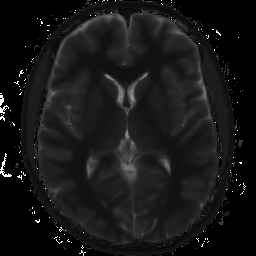

In [136]:
bart scale 0.5 tmp3 subspace_brain_T1map
bart flip $(bart bitmask 0) subspace_brain_T1map subspace_brain_T1map1
imshow subspace_brain_T1map1

python3 save_maps.py subspace_brain_T1map1 viridis 0 2.0 subspace_brain_T1map.png

In [112]:
rm *.hdr  *.cfl

192
